# Data preparation
Loads relevant packages and MIMIC datasets<br>
Extracts and engineering of relevant features<br>
Creation of a dataframe for subsequent models<br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from functools import reduce
from nettoyage_donnees import *
import duckdb

con = duckdb.connect()

In [2]:
'''
patients = load_mimic_table("patients", dataset="full", section="hosp")
admissions = load_mimic_table("admissions", dataset="full", section="hosp")
diagnoses = load_mimic_table("diagnoses_icd", dataset="full", section="hosp")

icustays = load_mimic_table("icustays", dataset="full", section="icu")
chartevents = load_mimic_table("chartevents", dataset="full", section="icu")

labevents = load_mimic_table("labevents", dataset="full", section="hosp")

inputevents = load_mimic_table("inputevents", dataset="full", section="icu")
prescriptions = load_mimic_table("prescriptions", dataset="full", section="hosp")

procedureevents = load_mimic_table("procedureevents", dataset="full", section="icu")
'''

'\npatients = load_mimic_table("patients", dataset="full", section="hosp")\nadmissions = load_mimic_table("admissions", dataset="full", section="hosp")\ndiagnoses = load_mimic_table("diagnoses_icd", dataset="full", section="hosp")\n\nicustays = load_mimic_table("icustays", dataset="full", section="icu")\nchartevents = load_mimic_table("chartevents", dataset="full", section="icu")\n\nlabevents = load_mimic_table("labevents", dataset="full", section="hosp")\n\ninputevents = load_mimic_table("inputevents", dataset="full", section="icu")\nprescriptions = load_mimic_table("prescriptions", dataset="full", section="hosp")\n\nprocedureevents = load_mimic_table("procedureevents", dataset="full", section="icu")\n'

In [3]:
# Load d_items
#d_items = load_mimic_table("d_items", dataset="demo", section="icu")

#print(d_items.shape)

In [4]:
df_demographics = con.execute(f"""
    SELECT 
        icu.stay_id,
        icu.subject_id,
        icu.hadm_id,
        icu.intime,
        icu.outtime,

        adm.admission_type,
        adm.insurance,
        adm.race,
        adm.admittime,
        adm.dischtime,

        pat.gender,
        pat.anchor_age AS age

    FROM read_csv_auto('mimic-iv-3.1/icu/icustays.csv') AS icu

    LEFT JOIN read_csv_auto('mimic-iv-3.1/hosp/admissions.csv') AS adm
        ON icu.hadm_id = adm.hadm_id

    LEFT JOIN read_csv_auto('mimic-iv-3.1/hosp/patients.csv') AS pat
        ON icu.subject_id = pat.subject_id

    WHERE pat.anchor_age >= 18
""").df()
df_demographics.head()

stay_id  subject_id   hadm_id              intime             outtime  \
0  39553978    10000032  29079034 2180-07-23 14:00:00 2180-07-23 23:50:47   
1  37081114    10000690  25860671 2150-11-02 19:37:00 2150-11-06 17:03:17   
2  39765666    10000980  26913865 2189-06-27 08:42:00 2189-06-27 20:38:27   
3  37067082    10001217  24597018 2157-11-20 19:18:02 2157-11-21 22:08:00   
4  34592300    10001217  27703517 2157-12-19 15:42:24 2157-12-20 14:27:41   

  admission_type insurance                    race           admittime  \
0       EW EMER.  Medicaid                   WHITE 2180-07-23 12:35:00   
1       EW EMER.  Medicare                   WHITE 2150-11-02 18:02:00   
2       EW EMER.  Medicare  BLACK/AFRICAN AMERICAN 2189-06-27 07:38:00   
3       EW EMER.   Private                   WHITE 2157-11-18 22:56:00   
4   DIRECT EMER.   Private                   WHITE 2157-12-18 16:58:00   

            dischtime gender  age  
0 2180-07-25 17:55:00      F   52  
1 2150-11-12 13:45:00      F   86  
2 2189-07-03 03:00:00      F   73  
3 2157-11-25 18:00:00      F   55  
4 2157-12-24 14:55:00      F   55

In [5]:
vent_ids = ITEMIDS["VENT_DURATION"]

modes      = ",".join(str(x) for x in vent_ids["modes"])
settings   = ",".join(str(x) for x in vent_ids["settings"])
intub      = ",".join(str(x) for x in vent_ids["intubation_events"])
extub      = ",".join(str(x) for x in vent_ids["extubation_events"])
niv        = ",".join(str(x) for x in vent_ids["noninvasive_events"])

# length of stay
sql_los = f"""
    SELECT 
        stay_id,
        subject_id,
        hadm_id,
        intime,
        outtime,
        EXTRACT(EPOCH FROM (outtime - intime)) / 3600 / 24 AS los_days
    FROM read_csv_auto('mimic-iv-3.1/icu/icustays.csv')
"""
df_los = con.execute(sql_los).df()

# ventilation duration
sql_vent = f"""
WITH raw AS (
    SELECT
        ce.stay_id,
        ce.charttime,
        ce.itemid,
        -- Define event type
        CASE 
            WHEN ce.itemid IN ({intub}) THEN 'INTUB'
            WHEN ce.itemid IN ({extub}) THEN 'EXTUB'
            WHEN ce.itemid IN ({modes}) THEN 'ON'
            WHEN ce.itemid IN ({settings}) THEN 'ON'
            WHEN ce.itemid IN ({niv}) THEN 'ON'
            ELSE NULL
        END AS event_type
    FROM read_csv_auto('mimic-iv-3.1/icu/chartevents.csv') AS ce
    WHERE ce.itemid IN (
        {modes}, {settings}, {intub}, {extub}, {niv}
    )
),

-- Mark ON/OFF transitions
events AS (
    SELECT
        stay_id,
        charttime,
        CASE 
            WHEN event_type = 'INTUB' THEN 1
            WHEN event_type = 'ON' THEN 1
            WHEN event_type = 'EXTUB' THEN 0
            ELSE NULL
        END AS vent_flag
    FROM raw
    WHERE event_type IS NOT NULL
),

-- Forward-fill vent state to get continuous segments
ff AS (
    SELECT
        stay_id,
        charttime,
        vent_flag,
        -- Build a cumulative window to detect OFF→ON transitions
        SUM(CASE WHEN vent_flag = 1 THEN 1 ELSE 0 END)
            OVER (PARTITION BY stay_id ORDER BY charttime) AS group_id
    FROM events
),

-- Compute duration inside each ON-segment
segments AS (
    SELECT
        stay_id,
        charttime,
        LEAD(charttime) OVER (PARTITION BY stay_id ORDER BY charttime) AS next_time,
        vent_flag
    FROM ff
)

SELECT
    s.stay_id,
    COALESCE(
        SUM(
            CASE 
                WHEN s.vent_flag = 1 THEN
                    EXTRACT(EPOCH FROM (COALESCE(s.next_time, icu.outtime) - s.charttime)) / 3600
                ELSE 0
            END
        ), 0
    ) AS vent_hours
FROM segments s
LEFT JOIN read_csv_auto('mimic-iv-3.1/icu/icustays.csv') AS icu
    ON s.stay_id = icu.stay_id
GROUP BY s.stay_id
"""
df_vent = con.execute(sql_vent).df()

# merge
df_los_vent = (
    df_los
    .merge(df_vent, on="stay_id", how="left")
)

df_los_vent["vent_hours"] = df_los_vent["vent_hours"].fillna(0)
df_los_vent["vent_days"]  = df_los_vent["vent_hours"] / 24

df_los_vent = df_los_vent.drop(columns=["hadm_id","subject_id","intime","outtime", "vent_hours"], errors="ignore")

df_los_vent.head()

stay_id  los_days  vent_days
0  39553978  0.410266   0.396377
1  37081114  3.893252   3.377280
2  39765666  0.497535   0.485035
3  37067082  1.118032   1.097917
4  34592300  0.948113   0.000000

In [6]:
# Converts Python lists to comma-separated strings
def to_csv(item_list):
    return ",".join(str(x) for x in item_list)

HR      = to_csv(ITEMIDS["HR"])
RR      = to_csv(ITEMIDS["RR"])
MAP     = to_csv(ITEMIDS["MAP"])
SPO2    = to_csv(ITEMIDS["SPO2"])
FIO2    = to_csv(ITEMIDS["FIO2"])
TEMP    = to_csv(ITEMIDS["TEMP"])
GCS_E   = to_csv(ITEMIDS["GCS_E"])
GCS_V   = to_csv(ITEMIDS["GCS_V"])
GCS_M   = to_csv(ITEMIDS["GCS_M"])

PAO2_LAB   = to_csv(ITEMIDS["LABS"]["PAO2"]["lab"])
PAO2_CHART = to_csv(ITEMIDS["LABS"]["PAO2"]["chart"])

WINDOW_H = 72

# sql query
sql = f"""
WITH icu AS (
    SELECT 
        stay_id,
        intime,
        outtime
    FROM read_csv_auto('mimic-iv-3.1/icu/icustays.csv')
),

-- ---------------------------
-- 1. CHARTEVENTS within window
-- ---------------------------
ce AS (
    SELECT
        stay_id,
        charttime,
        itemid,
        valuenum,
        value
    FROM read_csv_auto('mimic-iv-3.1/icu/chartevents.csv')
    WHERE itemid IN (
        {HR}, {RR}, {MAP}, {SPO2}, {FIO2}, {TEMP},
        {GCS_E}, {GCS_V}, {GCS_M},
        {PAO2_CHART}
    )
),

ce_window AS (
    SELECT
        ce.*,
        icu.outtime,
        icu.intime,
        CASE 
            WHEN charttime BETWEEN (icu.outtime - INTERVAL '{WINDOW_H} hours')
                              AND    icu.outtime
            THEN 1 ELSE 0 END AS in_window
    FROM ce
    JOIN icu USING (stay_id)
    WHERE charttime <= icu.outtime
),

-- ---------------------------
-- 2. LABEVENTS within window
-- ---------------------------
labs AS (
    SELECT
        subject_id,
        hadm_id,
        charttime,
        itemid,
        valuenum
    FROM read_csv_auto('mimic-iv-3.1/hosp/labevents.csv')
    WHERE itemid IN ({PAO2_LAB})
),

labs_window AS (
    SELECT
        labs.*,
        icu.stay_id,
        icu.outtime,
        CASE 
            WHEN labs.charttime BETWEEN (icu.outtime - INTERVAL '{WINDOW_H} hours')
                                   AND    icu.outtime
            THEN 1 ELSE 0 END AS in_window
    FROM labs
    JOIN read_csv_auto('mimic-iv-3.1/icu/icustays.csv') AS icu
      ON labs.subject_id = icu.subject_id
     AND labs.hadm_id    = icu.hadm_id
),

-- ---------------------------
-- 3. LAST values per stay
-- ---------------------------
last_ce AS (
    SELECT
        stay_id,
        itemid,
        valuenum,
        value,
        ROW_NUMBER() OVER (PARTITION BY stay_id, itemid 
                           ORDER BY charttime DESC) AS rn
    FROM ce_window
    WHERE in_window = 1
),

last_labs AS (
    SELECT
        stay_id,
        itemid,
        valuenum,
        ROW_NUMBER() OVER (PARTITION BY stay_id, itemid 
                           ORDER BY charttime DESC) AS rn
    FROM labs_window
    WHERE in_window = 1
),

-- ---------------------------
-- 4. Pivot vitals
-- ---------------------------
pivot_ce AS (
    SELECT
        stay_id,

        MAX(CASE WHEN itemid IN ({HR})  AND rn = 1 THEN valuenum END) AS hr,
        MAX(CASE WHEN itemid IN ({RR})  AND rn = 1 THEN valuenum END) AS rr,
        MAX(CASE WHEN itemid IN ({MAP}) AND rn = 1 THEN valuenum END) AS map,
        MAX(CASE WHEN itemid IN ({SPO2}) AND rn = 1 THEN valuenum END) AS spo2,
        MAX(CASE WHEN itemid IN ({TEMP}) AND rn = 1 THEN valuenum END) AS temp,

        MAX(CASE WHEN itemid IN ({FIO2}) AND rn = 1 THEN 
                     CASE WHEN valuenum > 1 THEN valuenum/100 ELSE valuenum END 
                 END) AS fio2,

        -- GCS E and V are numeric
        MAX(CASE WHEN itemid IN ({GCS_E}) AND rn = 1 THEN valuenum END) AS gcs_e,
        MAX(CASE WHEN itemid IN ({GCS_V}) AND rn = 1 THEN valuenum END) AS gcs_v,

        -- GCS Motor requires mapping text -> numeric
        MAX(CASE WHEN itemid IN ({GCS_M}) AND rn = 1 THEN
            CASE 
                WHEN value ILIKE '%obey%' THEN 6
                WHEN value ILIKE '%local%' THEN 5
                WHEN value ILIKE '%withdraw%' THEN 4
                WHEN value ILIKE '%flex%' THEN 3
                WHEN value ILIKE '%exten%' THEN 2
                WHEN value ILIKE '%no response%' THEN 1
                WHEN value ILIKE '%none%' THEN 1
                WHEN value ILIKE '%intubat%' THEN 1
                ELSE valuenum 
            END
        END) AS gcs_m,

        -- PaO2 from chartevents fallback
        MAX(CASE WHEN itemid IN ({PAO2_CHART}) AND rn = 1 THEN valuenum END) AS pao2_chart

    FROM last_ce
    GROUP BY stay_id
),

-- ---------------------------
-- 5. Pivot labs (PaO2)
-- ---------------------------
pivot_labs AS (
    SELECT
        stay_id,
        MAX(CASE WHEN itemid IN ({PAO2_LAB}) AND rn = 1 THEN valuenum END) AS pao2_lab
    FROM last_labs
    GROUP BY stay_id
),

-- ---------------------------
-- 6. Merge and compute derived values
-- ---------------------------
merged AS (
    SELECT
        icu.stay_id,
        hr, rr, map, spo2, temp, fio2,
        gcs_e, gcs_v, gcs_m,
        pao2_lab,
        pao2_chart,

        -- GCS total
        CASE 
            WHEN gcs_e IS NOT NULL AND gcs_v IS NOT NULL AND gcs_m IS NOT NULL
            THEN gcs_e + gcs_v + gcs_m
            ELSE NULL
        END AS gcs,

        -- Final PaO2 (prefer lab)
        COALESCE(pao2_lab, pao2_chart) AS pao2,

        -- P/F ratio
        CASE 
            WHEN COALESCE(pao2_lab, pao2_chart) IS NOT NULL 
             AND fio2 IS NOT NULL AND fio2 > 0
            THEN COALESCE(pao2_lab, pao2_chart) / fio2
            ELSE NULL
        END AS pfratio

    FROM pivot_ce
    JOIN icu USING (stay_id)
    LEFT JOIN pivot_labs USING (stay_id)
)

SELECT * FROM merged
ORDER BY stay_id;
"""

df_vitals_discharge = con.execute(sql).df()
df_vitals_discharge.head()

stay_id     hr    rr   map   spo2   temp  fio2  gcs_e  gcs_v  gcs_m  \
0  30000153   97.0  14.0  84.0  100.0  100.1   0.4    4.0    6.0    NaN   
1  30000213   81.0  22.0   NaN   96.0   98.3   0.3    5.0    6.0    NaN   
2  30000484   95.0  22.0   NaN  100.0   99.2   NaN    4.0    6.0    NaN   
3  30000646  113.0  23.0   NaN   97.0   98.0   NaN    5.0    6.0    NaN   
4  30000831  126.0  22.0   NaN   95.0   98.4   0.5    5.0    6.0    NaN   

   pao2_lab  pao2_chart  gcs   pao2     pfratio  
0     215.0       215.0  NaN  215.0  537.500000  
1      56.0        79.0  NaN   56.0  186.666667  
2      21.0         NaN  NaN   21.0         NaN  
3       NaN         NaN  NaN    NaN         NaN  
4      58.0         NaN  NaN   58.0  116.000000

In [7]:
def to_csv(lst):
    return ",".join(str(x) for x in lst)

modes      = to_csv(ITEMIDS["VENT_DURATION"]["modes"])
settings   = to_csv(ITEMIDS["VENT_DURATION"]["settings"])
intub_ids  = to_csv(ITEMIDS["VENT_DURATION"]["intubation_events"])
extub_ids  = to_csv(ITEMIDS["VENT_DURATION"]["extubation_events"])
niv_ids    = to_csv(ITEMIDS["VENT_DURATION"]["noninvasive_events"])

crrt_ids   = to_csv(ITEMIDS["SUPPORT"]["CRRT"])

# FAST flatten of vasopressors
pressor_ids = []
for v in ITEMIDS["PRESSORS"].values():
    if isinstance(v, list):
        pressor_ids.extend(v)
    else:
        pressor_ids.append(v)
pressor_ids_csv = ",".join(str(x) for x in pressor_ids)

WINDOW_H = 72

sql = f"""
WITH icu AS (
    SELECT stay_id, subject_id, hadm_id, intime, outtime
    FROM read_csv_auto('mimic-iv-3.1/icu/icustays.csv')
),

-- ----------------------------------------------------
-- CHARTEVENTS: Detect ventilation evidence
-- modes, settings, or intubation-related itemids
-- ----------------------------------------------------
ce AS (
    SELECT
        stay_id,
        itemid,
        charttime
    FROM read_csv_auto('mimic-iv-3.1/icu/chartevents.csv')
    WHERE itemid IN ({modes}, {settings})
),

ce_window AS (
    SELECT DISTINCT
        i.stay_id,
        CASE 
            WHEN ce.itemid IN ({modes}, {settings})
                 AND ce.charttime BETWEEN (i.outtime - INTERVAL '{WINDOW_H} hours') AND i.outtime
            THEN 1 ELSE 0 END AS vent_signal
    FROM icu i
    LEFT JOIN ce 
        ON ce.stay_id = i.stay_id
),

-- ----------------------------------------------------
-- PROCEDUREEVENTS: Intubation, extubation, CRRT
-- ----------------------------------------------------
proc AS (
    SELECT
        stay_id,
        itemid,
        endtime
    FROM read_csv_auto('mimic-iv-3.1/icu/procedureevents.csv')
    WHERE itemid IN ({intub_ids}, {extub_ids}, {crrt_ids})
),

proc_window AS (
    SELECT DISTINCT
        i.stay_id,

        -- ventilation via intubation evidence
        CASE 
            WHEN proc.itemid IN ({intub_ids})
                 AND proc.endtime BETWEEN (i.outtime - INTERVAL '{WINDOW_H} hours') AND i.outtime
            THEN 1 ELSE 0 END AS intub_signal,

        -- extubation
        CASE 
            WHEN proc.itemid IN ({extub_ids})
                 AND proc.endtime BETWEEN (i.outtime - INTERVAL '{WINDOW_H} hours') AND i.outtime
            THEN 1 ELSE 0 END AS extub_signal,

        -- CRRT
        CASE 
            WHEN proc.itemid IN ({crrt_ids})
                 AND proc.endtime BETWEEN (i.outtime - INTERVAL '{WINDOW_H} hours') AND i.outtime
            THEN 1 ELSE 0 END AS crrt_signal

    FROM icu i
    LEFT JOIN proc 
        ON proc.stay_id = i.stay_id
),

-- ----------------------------------------------------
-- INPUTEVENTS: Vasopressors
-- ----------------------------------------------------
iv AS (
    SELECT
        stay_id,
        itemid,
        starttime,
        endtime
    FROM read_csv_auto('mimic-iv-3.1/icu/inputevents.csv')
    WHERE itemid IN ({pressor_ids_csv})
),

iv_window AS (
    SELECT DISTINCT
        i.stay_id,
        CASE 
            WHEN iv.itemid IN ({pressor_ids_csv})
             AND iv.starttime <= i.outtime
             AND iv.endtime >= (i.outtime - INTERVAL '{WINDOW_H} hours')
            THEN 1 ELSE 0 END AS pressor_signal
    FROM icu i
    LEFT JOIN iv 
        ON iv.stay_id = i.stay_id
),

-- ----------------------------------------------------
-- Aggregate each signal into a stay-level indicator
-- ----------------------------------------------------
agg AS (
    SELECT
        i.stay_id,

        -- vent_last48: from modes/settings OR intubation evidence
        MAX(ce_window.vent_signal)       AS vent_signal,
        MAX(proc_window.intub_signal)    AS intub_signal,

        -- pressors
        MAX(iv_window.pressor_signal)    AS pressor_signal,

        -- extubation and CRRT
        MAX(proc_window.extub_signal)    AS extub_signal,
        MAX(proc_window.crrt_signal)     AS crrt_signal

    FROM icu i
    LEFT JOIN ce_window      USING (stay_id)
    LEFT JOIN proc_window    USING (stay_id)
    LEFT JOIN iv_window      USING (stay_id)
    GROUP BY stay_id
)

SELECT
    stay_id,

    -- same as python: if any ON signal → 1
    CASE WHEN COALESCE(vent_signal,0)=1 OR COALESCE(intub_signal,0)=1 
         THEN 1 ELSE 0 END AS vent_last48,

    COALESCE(pressor_signal,0) AS pressor_last48,
    COALESCE(extub_signal,0)   AS extubation_last48,
    COALESCE(crrt_signal,0)    AS crrt_last48

FROM agg
ORDER BY stay_id;
"""

df_supports_recent = con.execute(sql).df()
df_supports_recent.head()

stay_id  vent_last48  pressor_last48  extubation_last48  crrt_last48
0  30000153            1               0                  1            0
1  30000213            1               0                  1            0
2  30000484            1               1                  0            0
3  30000646            1               0                  0            0
4  30000831            1               0                  0            0

In [8]:
def to_csv(x):
    return ",".join(str(i) for i in x)

LABS = ITEMIDS["LABS"]

# Build CSV lists for each lab’s lab-itemids and chart-itemids
LAB_LAB_IDS = {lab: to_csv(src["lab"]) for lab, src in LABS.items()}
LAB_CHART_IDS = {lab: to_csv(src["chart"]) for lab, src in LABS.items()}

WINDOW_H = 72   # or 24, depending on your use case

sql_labs_lab = f"""
WITH icu AS (
    SELECT stay_id, subject_id, hadm_id, intime, outtime
    FROM read_csv_auto('mimic-iv-3.1/icu/icustays.csv')
),

labs_raw AS (
    SELECT
        i.stay_id,
        le.itemid,
        le.valuenum,
        le.charttime,
        ROW_NUMBER() OVER (
            PARTITION BY i.stay_id, le.itemid
            ORDER BY le.charttime DESC
        ) AS rn
    FROM read_csv_auto('mimic-iv-3.1/hosp/labevents.csv') AS le
    JOIN icu i
      ON le.subject_id = i.subject_id
     AND le.hadm_id    = i.hadm_id
    WHERE le.itemid IN ({",".join(LAB_LAB_IDS.values())})
      AND le.charttime BETWEEN (i.outtime - INTERVAL '{WINDOW_H} hours') AND i.outtime
),

pivoted AS (
    SELECT
        stay_id,
        {", ".join([
            f"MAX(CASE WHEN itemid IN ({LAB_LAB_IDS[lab]}) AND rn = 1 THEN valuenum END) AS {lab.lower()}_lab"
            for lab in LABS.keys()
        ])}
    FROM labs_raw
    GROUP BY stay_id
)

SELECT * FROM pivoted ORDER BY stay_id;
"""

df_labs_discharge = con.execute(sql_labs_lab).df()
df_labs_discharge.head()

stay_id  lactate_lab  creatinine_lab  bun_lab  bicarb_lab  sodium_lab  \
0  30000153          2.1             1.1     22.0        23.0       145.0   
1  30000213          0.9             3.6     61.0        24.0       139.0   
2  30000484          1.6             1.2     36.0        28.0       140.0   
3  30000646          NaN             0.5      8.0        23.0       139.0   
4  30000831          1.4             2.0     83.0        26.0       147.0   

   potassium_lab  magnesium_lab  calcium_lab  wbc_lab  hemoglobin_lab  \
0            4.8            2.2          8.0     15.2             9.8   
1            4.8            2.1          8.1      5.8             7.4   
2            4.0            2.2          8.3     18.3             9.2   
3            4.0            2.1          7.9      9.1            13.2   
4            3.1            2.9          8.8     13.0            12.7   

   platelets_lab  bilirubin_lab  inr_lab  pao2_lab  
0          162.0            NaN      1.1     215.0  
1          226.0            0.3      NaN      56.0  
2          329.0            0.3      1.3      21.0  
3          171.0            NaN      1.4       NaN  
4          392.0            0.7      1.3      58.0

In [9]:
LABS = ITEMIDS["LABS"]
VITAL_KEYS = ["HR", "RR", "MAP", "SPO2", "FIO2", "TEMP"]

def to_csv(lst):
    return ",".join(str(x) for x in lst)

# LABS: dict of {name: {"lab": [ids], "chart": [...]}}
LAB_IDCSV = {name: to_csv(info["lab"]) for name, info in LABS.items()}

# Vitals (from chartevents)
VITAL_IDCSV = {name.lower(): to_csv(ITEMIDS[name]) for name in VITAL_KEYS}

sql_lab_deltas = f"""
WITH icu AS (
    SELECT stay_id, subject_id, hadm_id, intime, outtime
    FROM read_csv_auto('mimic-iv-3.1/icu/icustays.csv')
),

-- 1) LABEVENTS joined to stays, restricted to 48h window
lab AS (
    SELECT
        i.stay_id,
        le.itemid,
        le.valuenum,
        le.charttime
    FROM read_csv_auto('mimic-iv-3.1/hosp/labevents.csv') AS le
    JOIN icu i
      ON le.subject_id = i.subject_id
     AND le.hadm_id    = i.hadm_id
    WHERE le.charttime BETWEEN (i.intime - INTERVAL '48 hours') AND i.outtime
),

-- 2) Last timestamp per stay/itemid
last_time AS (
    SELECT
        stay_id,
        itemid,
        MAX(charttime) AS last_time
    FROM lab
    GROUP BY stay_id, itemid
),

-- 3) Value at the last timestamp
last_val AS (
    SELECT
        l.stay_id,
        l.itemid,
        l.valuenum AS last_value,
        lt.last_time
    FROM lab l
    JOIN last_time lt
      ON l.stay_id = lt.stay_id
     AND l.itemid  = lt.itemid
     AND l.charttime = lt.last_time
),

-- 4) Candidate previous values ≥48h before last_time
prev_candidates AS (
    SELECT
        l.stay_id,
        l.itemid,
        l.valuenum,
        l.charttime,
        lv.last_time,
        ROW_NUMBER() OVER (
            PARTITION BY l.stay_id, l.itemid
            ORDER BY l.charttime DESC
        ) AS rn_desc
    FROM lab l
    JOIN last_val lv
      ON l.stay_id = lv.stay_id
     AND l.itemid  = lv.itemid
    WHERE l.charttime <= lv.last_time - INTERVAL '48 hours'
),

-- 5) Most recent candidate before cutoff
prev_val AS (
    SELECT
        stay_id,
        itemid,
        valuenum AS prev_value
    FROM prev_candidates
    WHERE rn_desc = 1
),

-- 6) Compute deltas
deltas AS (
    SELECT
        lv.stay_id,
        lv.itemid,
        (lv.last_value - pv.prev_value) AS delta_value
    FROM last_val lv
    LEFT JOIN prev_val pv
      ON lv.stay_id = pv.stay_id
     AND lv.itemid  = pv.itemid
)

-- 7) Pivot wide: delta_<labname>
SELECT
    stay_id,
    {", ".join([
        f"MAX(CASE WHEN itemid IN ({LAB_IDCSV[lab]}) THEN delta_value END) AS delta_{lab.lower()}"
        for lab in LABS.keys()
    ])}
FROM deltas
GROUP BY stay_id
ORDER BY stay_id;
"""

df_lab_deltas = con.execute(sql_lab_deltas).df()

In [10]:
sql_vital_deltas = f"""
WITH icu AS (
    SELECT stay_id, intime, outtime
    FROM read_csv_auto('mimic-iv-3.1/icu/icustays.csv')
),

char AS (
    SELECT
        ce.stay_id,
        ce.itemid,
        ce.valuenum,
        ce.charttime
    FROM read_csv_auto('mimic-iv-3.1/icu/chartevents.csv') AS ce
    JOIN icu USING (stay_id)
    WHERE ce.charttime BETWEEN (icu.intime - INTERVAL '48 hours') AND icu.outtime
      AND ce.itemid IN ({",".join(VITAL_IDCSV.values())})
),

last_time AS (
    SELECT stay_id, itemid, MAX(charttime) AS last_time
    FROM char GROUP BY stay_id, itemid
),

last_val AS (
    SELECT
        c.stay_id,
        c.itemid,
        c.valuenum AS last_value,
        lt.last_time
    FROM char c
    JOIN last_time lt
      ON c.stay_id = lt.stay_id
     AND c.itemid  = lt.itemid
     AND c.charttime = lt.last_time
),

prev_candidates AS (
    SELECT
        c.stay_id,
        c.itemid,
        c.valuenum,
        c.charttime,
        lv.last_time,
        ROW_NUMBER() OVER (
            PARTITION BY c.stay_id, c.itemid
            ORDER BY c.charttime DESC
        ) AS rn_desc
    FROM char c
    JOIN last_val lv USING (stay_id, itemid)
    WHERE c.charttime <= lv.last_time - INTERVAL '48 hours'
),

prev_val AS (
    SELECT stay_id, itemid, valuenum AS prev_value
    FROM prev_candidates
    WHERE rn_desc = 1
),

deltas AS (
    SELECT
        lv.stay_id,
        lv.itemid,
        (lv.last_value - pv.prev_value) AS delta_value
    FROM last_val lv
    LEFT JOIN prev_val pv USING (stay_id, itemid)
)

SELECT
    stay_id,
    {", ".join([
        f"MAX(CASE WHEN itemid IN ({VITAL_IDCSV[vital.lower()]}) THEN delta_value END) AS delta_{vital.lower()}"
        for vital in VITAL_KEYS
    ])}
FROM deltas
GROUP BY stay_id
ORDER BY stay_id;
"""

df_vitals_deltas = con.execute(sql_vital_deltas).df()

In [11]:
df_lab_deltas.head()

stay_id  delta_lactate  delta_creatinine  delta_bun  delta_bicarb  \
0  30000153            NaN               NaN        NaN           NaN   
1  30000213            NaN               NaN        NaN           NaN   
2  30000484            NaN               NaN        NaN           NaN   
3  30000646            NaN              -0.1        1.0           4.0   
4  30000831            0.0              -0.1       18.0           1.0   

   delta_sodium  delta_potassium  delta_magnesium  delta_calcium  delta_wbc  \
0           NaN              NaN              NaN            NaN        NaN   
1           NaN              NaN              NaN            NaN        NaN   
2           NaN              NaN              NaN            NaN        NaN   
3          -1.0             -0.1              0.0            1.0        1.9   
4           6.0             -0.7              0.4           -0.6       -8.3   

   delta_hemoglobin  delta_platelets  delta_bilirubin  delta_inr  delta_pao2  
0               NaN              NaN              NaN        NaN         NaN  
1               NaN              NaN              NaN        NaN         NaN  
2               NaN              NaN              NaN        NaN         NaN  
3              -0.2            -59.0              NaN       -0.2         NaN  
4              -0.6             81.0              0.3        0.1         NaN

In [12]:
df_trajectories_48h = (
    df_lab_deltas
    .merge(df_vitals_deltas, on="stay_id", how="left")
)

df_trajectories_48h.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93227 entries, 0 to 93226
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   stay_id           93227 non-null  int64  
 1   delta_lactate     14690 non-null  float64
 2   delta_creatinine  43423 non-null  float64
 3   delta_bun         43392 non-null  float64
 4   delta_bicarb      43169 non-null  float64
 5   delta_sodium      43582 non-null  float64
 6   delta_potassium   43852 non-null  float64
 7   delta_magnesium   41865 non-null  float64
 8   delta_calcium     40179 non-null  float64
 9   delta_wbc         42425 non-null  float64
 10  delta_hemoglobin  42510 non-null  float64
 11  delta_platelets   42436 non-null  float64
 12  delta_bilirubin   16197 non-null  float64
 13  delta_inr         31645 non-null  float64
 14  delta_pao2        16826 non-null  float64
 15  delta_hr          43748 non-null  float64
 16  delta_rr          43520 non-null  float6

In [13]:
# Antibiotics dictionary keys → regex pattern
antibiotic_regex = "|".join(ITEMIDS["ANTIBIOTICS"].keys())

sedative_regex = "|".join([
    "midazolam",
    "lorazepam",
    "propofol",
    "dexmed", "dexme",
    "ketamine"
])

steroid_regex = "|".join([
    "hydrocortisone",
    "methylpred", "methylprednisolone"
])

diuretic_regex = "|".join([
    "furosemide",
    "bumetanide",
    "acetazolamide"
])

# Flatten vasopressor itemids
pressor_itemids = []
for v in ITEMIDS["PRESSORS"].values():
    if isinstance(v, list):
        pressor_itemids.extend(v)
    else:
        pressor_itemids.append(v)

pressor_ids_csv = ",".join(str(x) for x in pressor_itemids)

WINDOW_H = 72

sql_meds = f"""
WITH icu AS (
    SELECT stay_id, hadm_id, outtime
    FROM read_csv_auto('mimic-iv-3.1/icu/icustays.csv')
),

-- =========================================
-- 1) VASOPRESSORS FROM INPUTEVENTS
-- =========================================
iv AS (
    SELECT
        i.stay_id,
        CASE 
            WHEN ie.itemid IN ({pressor_ids_csv})
             AND ie.starttime <= i.outtime
             AND ie.endtime   >= (i.outtime - INTERVAL '{WINDOW_H} hours')
            THEN 1 ELSE 0 END AS pressor_signal
    FROM icu i
    LEFT JOIN read_csv_auto('mimic-iv-3.1/icu/inputevents.csv') AS ie
        ON ie.stay_id = i.stay_id
),

iv_agg AS (
    SELECT stay_id, MAX(pressor_signal) AS pressor_last72
    FROM iv
    GROUP BY stay_id
),

-- =========================================
-- 2) PRESCRIPTIONS (RX MEDICATIONS)
-- =========================================
rx AS (
    SELECT
        i.stay_id,
        p.drug
    FROM icu i
    JOIN read_csv_auto('mimic-iv-3.1/hosp/prescriptions.csv') AS p
        ON p.hadm_id = i.hadm_id
    WHERE p.starttime BETWEEN (i.outtime - INTERVAL '{WINDOW_H} hours') AND i.outtime
),

rx_agg AS (
    SELECT
        stay_id,
        MAX(CASE WHEN REGEXP_MATCHES(LOWER(drug), '{antibiotic_regex}') THEN 1 ELSE 0 END) AS antibiotics_last72,
        MAX(CASE WHEN REGEXP_MATCHES(LOWER(drug), '{sedative_regex}')    THEN 1 ELSE 0 END) AS sedatives_last72,
        MAX(CASE WHEN REGEXP_MATCHES(LOWER(drug), '{steroid_regex}')     THEN 1 ELSE 0 END) AS steroids_last72,
        MAX(CASE WHEN REGEXP_MATCHES(LOWER(drug), '{diuretic_regex}')    THEN 1 ELSE 0 END) AS diuretics_last72
    FROM rx
    GROUP BY stay_id
)

-- =========================================
-- 3) COMBINE BOTH SOURCES
-- =========================================
SELECT
    i.stay_id,

    -- Flags default to 0 when missing
    COALESCE(iv_agg.pressor_last72, 0)        AS pressor_last72,
    COALESCE(rx_agg.antibiotics_last72, 0)    AS antibiotics_last72,
    COALESCE(rx_agg.sedatives_last72, 0)      AS sedatives_last72,
    COALESCE(rx_agg.steroids_last72, 0)       AS steroids_last72,
    COALESCE(rx_agg.diuretics_last72, 0)      AS diuretics_last72

FROM icu i
LEFT JOIN iv_agg USING (stay_id)
LEFT JOIN rx_agg USING (stay_id)
ORDER BY stay_id;
"""

df_meds_recent = con.execute(sql_meds).df()
df_meds_recent.head()


stay_id  pressor_last72  antibiotics_last72  sedatives_last72  \
0  30000153               0                   0                 1   
1  30000213               0                   0                 1   
2  30000484               1                   1                 0   
3  30000646               0                   1                 0   
4  30000831               0                   1                 1   

   steroids_last72  diuretics_last72  
0                0                 0  
1                0                 1  
2                0                 0  
3                0                 0  
4                0                 1

In [14]:
sql_operational = f"""
WITH icu AS (
    SELECT stay_id, outtime
    FROM read_csv_auto('mimic-iv-3.1/icu/icustays.csv')
)

SELECT
    stay_id,

    -- night discharge (20:00–23:59 and 00:00–07:59)
    CASE
        WHEN HOUR(outtime) BETWEEN 20 AND 23
          OR HOUR(outtime) BETWEEN 0 AND 7
        THEN 1 ELSE 0
    END AS night_discharge,

    -- weekend discharge (Saturday=6, Sunday=7)
    CASE
        WHEN DAYOFWEEK(outtime) IN (6,7)
        THEN 1 ELSE 0
    END AS weekend_discharge

FROM icu
ORDER BY stay_id;
"""
df_operational = con.execute(sql_operational).df()
df_operational.head()

stay_id  night_discharge  weekend_discharge
0  30000153                1                  1
1  30000213                1                  0
2  30000484                1                  0
3  30000646                0                  1
4  30000831                0                  0

In [15]:
con.execute("CREATE OR REPLACE TABLE demographics AS SELECT * FROM df_demographics")
con.execute("CREATE OR REPLACE TABLE vitals_discharge AS SELECT * FROM df_vitals_discharge")
con.execute("CREATE OR REPLACE TABLE supports_recent AS SELECT * FROM df_supports_recent")
con.execute("CREATE OR REPLACE TABLE labs_discharge AS SELECT * FROM df_labs_discharge")
con.execute("CREATE OR REPLACE TABLE trajectories_48h AS SELECT * FROM df_trajectories_48h")
con.execute("CREATE OR REPLACE TABLE meds_recent AS SELECT * FROM df_meds_recent")
con.execute("CREATE OR REPLACE TABLE operational AS SELECT * FROM df_operational")
con.execute("CREATE OR REPLACE TABLE los_vent AS SELECT * FROM df_los_vent")

In [16]:
def load_mimic_duckdb(
    con,
    table_name,
    dataset="demo",      # "demo" or "full"
    section="hosp",      # "hosp" or "icu"
    base_path="/Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/MMD6020 Fondements médecine computationnelle/Projet"  
):
    """
    Load a MIMIC-IV table directly into DuckDB.
    Automatically infers dates and uses safe typing.
    Creates a DuckDB table named <table_name>.
    """

    folder = {
        "demo": "mimic-iv-clinical-database-demo-2.2",
        "full": "mimic-iv-3.1"
    }[dataset]

    file_path = os.path.join(base_path, folder, section, f"{table_name}.csv")

    print(f"→ Loading {table_name} from: {file_path}")

    # Use DuckDB’s fast CSV reader
    con.execute(f"""
        CREATE OR REPLACE TABLE {table_name} AS
        SELECT * FROM read_csv_auto('{file_path}', SAMPLE_SIZE=-1);
    """)

    print(f"→ Table created: {table_name}")

In [17]:
df_diagnoses_icd = load_mimic_duckdb(con, "diagnoses_icd", dataset="full", section="hosp")

sql_charlson = """
WITH dx AS (
    SELECT
        hadm_id,
        icd_version,
        UPPER(
            CASE
                WHEN icd_version = 10 THEN SUBSTR(icd_code, 1, 3)
                WHEN icd_version = 9  THEN SUBSTR(SPLIT_PART(icd_code, '.', 1), 1, 3)
            END
        ) AS icd_prefix
    FROM diagnoses_icd
),

charlson_raw AS (
    SELECT
        hadm_id,

        -- 1-point conditions
        MAX(CASE WHEN (icd_version=9  AND icd_prefix ~ '^(410|412)$')
                  OR (icd_version=10 AND icd_prefix ~ '^(I21|I22|I25)$') THEN 1 ELSE 0 END) AS mi,

        MAX(CASE WHEN (icd_version=9  AND icd_prefix ~ '^(398|402|404|428)$')
                  OR (icd_version=10 AND icd_prefix ~ '^(I50|I11|I13)$') THEN 1 ELSE 0 END) AS chf,

        MAX(CASE WHEN (icd_version=9  AND icd_prefix ~ '^(440|441|443|447|557|V43)$')
                  OR (icd_version=10 AND icd_prefix ~ '^(I70|I71|I73|I77|I79|K55|Z95)$') THEN 1 ELSE 0 END) AS pvd,

        MAX(CASE WHEN (icd_version=9  AND icd_prefix ~ '^(430|431|432|433|434|435|436|437|438)$')
                  OR (icd_version=10 AND icd_prefix ~ '^(I60|I61|I62|I63|I64|I65|I66|I67|I68|I69|G45|G46)$') THEN 1 ELSE 0 END) AS cerebro,

        MAX(CASE WHEN (icd_version=9  AND icd_prefix='290')
                  OR (icd_version=10 AND icd_prefix ~ '^(F00|F01|F02|F03|G30)$') THEN 1 ELSE 0 END) AS dementia,

        MAX(CASE WHEN (icd_version=9  AND icd_prefix ~ '^(490|491|492|493|494|495|496)$')
                  OR (icd_version=10 AND icd_prefix ~ '^(J40|J41|J42|J43|J44|J45|J46|J47|J6.$)') THEN 1 ELSE 0 END) AS copd,

        MAX(CASE WHEN (icd_version=9  AND icd_prefix ~ '^(446|701|710|711|714|719)$')
                  OR (icd_version=10 AND icd_prefix ~ '^(M05|M06|M31|M32|M33|M34|M35|M36)$') THEN 1 ELSE 0 END) AS rheum,

        MAX(CASE WHEN (icd_version=9  AND icd_prefix ~ '^(531|532|533|534)$')
                  OR (icd_version=10 AND icd_prefix ~ '^(K25|K26|K27|K28)$') THEN 1 ELSE 0 END) AS pud,

        MAX(CASE WHEN (icd_version=9  AND icd_prefix ~ '^(570|571)$')
                  OR (icd_version=10 AND icd_prefix ~ '^(B18|K70|K71|K72|K73|K74)$') THEN 1 ELSE 0 END) AS mild_liver,

        MAX(CASE WHEN (icd_version=9  AND icd_prefix='250')
                   OR (icd_version=10 AND icd_prefix ~ '^(E10|E11|E12|E13|E14)$') THEN 1 ELSE 0 END) AS diabetes,

        -- 2-point conditions
        MAX(CASE WHEN (icd_version=9  AND icd_prefix ~ '^(342|343|344)$')
                  OR (icd_version=10 AND icd_prefix ~ '^(G81|G82|G04)$') THEN 1 ELSE 0 END) AS hemiplegia,

        MAX(CASE WHEN (icd_version=9  AND icd_prefix ~ '^(582|583|585|586|588)$')
                  OR (icd_version=10 AND icd_prefix ~ '^(N18|N19|N05|N25|Z49|Z94|Z99)$') THEN 1 ELSE 0 END) AS renal,

        MAX(CASE WHEN (icd_version=9  AND icd_prefix ~ '^(140|141|142|143|144|145|146|147|148|149|150|151|152|153|154|155|156|157|158|159|160|161|162|163|164|165|170|171|172|174|175|176)$')
                  OR (icd_version=10 AND icd_prefix LIKE 'C%') THEN 1 ELSE 0 END) AS malignancy,

        MAX(CASE WHEN (icd_version=9  AND icd_prefix='572')
                  OR (icd_version=10 AND icd_prefix ~ '^(I85|I86|I98|K70|K71|K72)$') THEN 1 ELSE 0 END) AS severe_liver,

        -- 6-point conditions
        MAX(CASE WHEN (icd_version=9  AND icd_prefix ~ '^(196|197|198|199)$')
                  OR (icd_version=10 AND icd_prefix ~ '^(C77|C78|C79|C80)$') THEN 1 ELSE 0 END) AS metastatic,

        MAX(CASE WHEN (icd_version=9  AND icd_prefix ~ '^(042|043|044)$')
                  OR (icd_version=10 AND icd_prefix ~ '^(B20|B21|B22|B24)$') THEN 1 ELSE 0 END) AS hiv

    FROM dx
    GROUP BY hadm_id
),

charlson AS (
    SELECT
        hadm_id,
        -- Apply weights
        (mi * 1) +
        (chf * 1) +
        (pvd * 1) +
        (cerebro * 1) +
        (dementia * 1) +
        (copd * 1) +
        (rheum * 1) +
        (pud * 1) +
        (mild_liver * 1) +
        (diabetes * 1) +
        (hemiplegia * 2) +
        (renal * 2) +
        (malignancy * 2) +
        (severe_liver * 3) +
        (metastatic * 6) +
        (hiv * 6)
        AS charlson_index
    FROM charlson_raw
)

SELECT * FROM charlson;
"""

df_charlson = con.execute(sql_charlson).df()
df_charlson.head()

con.register("charlson", df_charlson)

→ Loading diagnoses_icd from: /Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/MMD6020 Fondements médecine computationnelle/Projet/mimic-iv-3.1/hosp/diagnoses_icd.csv
→ Table created: diagnoses_icd


In [18]:
icustays = load_mimic_duckdb(con, "icustays", dataset="full", section="icu")

con.execute("PRAGMA table_info('icustays')").df()

→ Loading icustays from: /Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/MMD6020 Fondements médecine computationnelle/Projet/mimic-iv-3.1/icu/icustays.csv
→ Table created: icustays


cid            name       type  notnull dflt_value     pk
0    0      subject_id     BIGINT    False       None  False
1    1         hadm_id     BIGINT    False       None  False
2    2         stay_id     BIGINT    False       None  False
3    3  first_careunit    VARCHAR    False       None  False
4    4   last_careunit    VARCHAR    False       None  False
5    5          intime  TIMESTAMP    False       None  False
6    6         outtime  TIMESTAMP    False       None  False
7    7             los     DOUBLE    False       None  False

In [19]:
sql_create_readmit = """
CREATE OR REPLACE TABLE readmit_72h AS
WITH ordered AS (
    SELECT
        stay_id,
        subject_id,
        hadm_id,
        intime,
        outtime,
        LEAD(intime) OVER (
            PARTITION BY subject_id, hadm_id
            ORDER BY intime
        ) AS next_intime
    FROM icustays
),
flagged AS (
    SELECT
        stay_id,
        CASE
            WHEN next_intime IS NOT NULL
                 AND next_intime >= outtime
                 AND next_intime <= outtime + INTERVAL 72 HOUR
            THEN 1
            ELSE 0
        END AS readmit_72h
    FROM ordered
)
SELECT * FROM flagged;
"""

con.execute(sql_create_readmit)
df_readmit = con.execute("SELECT * FROM readmit_72h ORDER BY stay_id").df()
df_readmit.head()

stay_id  readmit_72h
0  30000153            0
1  30000213            0
2  30000484            0
3  30000646            1
4  30000831            1

In [20]:
sql_build_final = """
WITH base AS (
    SELECT stay_id FROM demographics
),

final AS (
    SELECT
        b.stay_id,

        -- 1) DEMOGRAPHICS
        d.subject_id,
        d.gender,
        d.age,
        d.race,
        d.insurance,
        d.admission_type,
        d.admittime,
        d.dischtime,
        d.intime,

        -- 2) VITALS AT DISCHARGE
        vd.hr,
        vd.rr,
        vd.map,
        vd.spo2,
        vd.temp,
        vd.fio2,
        vd.gcs,
        vd.pao2,
        vd.pfratio,

        -- 3) SUPPORTS
        sr.vent_last48,
        sr.pressor_last48,
        sr.extubation_last48,
        sr.crrt_last48,

        -- 4) LABS
        ld.* EXCLUDE(stay_id),

        -- 5) TRAJECTORIES
        t.* EXCLUDE(stay_id),

        -- 6) MEDS
        mr.pressor_last72,
        mr.antibiotics_last72,
        mr.sedatives_last72,
        mr.steroids_last72,
        mr.diuretics_last72,

        -- 7) OPERATIONAL
        op.night_discharge,
        op.weekend_discharge,

        -- 8) LOS
        lv.los_days,
        lv.vent_days,

        -- 9) CHARLSON
        COALESCE(c.charlson_index, 0) AS charlson_index,

        -- 10) READMISSION
        COALESCE(rh.readmit_72h, 0) AS readmit_72h

    FROM base b
    LEFT JOIN demographics       d  USING (stay_id)
    LEFT JOIN charlson           c  USING (hadm_id)
    LEFT JOIN vitals_discharge   vd USING (stay_id)
    LEFT JOIN supports_recent    sr USING (stay_id)
    LEFT JOIN labs_discharge     ld USING (stay_id)
    LEFT JOIN trajectories_48h   t  USING (stay_id)
    LEFT JOIN meds_recent        mr USING (stay_id)
    LEFT JOIN operational        op USING (stay_id)
    LEFT JOIN los_vent           lv USING (stay_id)
    LEFT JOIN readmit_72h        rh USING (stay_id)
)

-- Filter out <48h mechanical ventilation
SELECT *
FROM final
WHERE vent_days >= 2
ORDER BY stay_id;
"""

df_final = con.execute(sql_build_final).df()
df_final.head()

stay_id  subject_id gender  age                          race insurance  \
0  30000484    18421337      M   91       MULTIPLE RACE/ETHNICITY  Medicare   
1  30000646    12207593      M   43               ASIAN - CHINESE  Medicaid   
2  30000831    15726459      M   78                         WHITE   Private   
3  30001336    12168737      M   77                       UNKNOWN      None   
4  30001471    17461994      M   86  HISPANIC/LATINO - SALVADORAN  Medicaid   

      admission_type           admittime           dischtime  \
0           EW EMER. 2136-01-14 17:22:00 2136-01-24 16:00:00   
1           EW EMER. 2194-04-27 18:43:00 2194-05-06 02:29:00   
2             URGENT 2140-04-17 21:25:00 2140-05-18 21:00:00   
3             URGENT 2186-03-20 00:44:00 2186-03-22 19:10:00   
4  OBSERVATION ADMIT 2189-05-02 05:43:00 2189-05-05 15:38:00   

               intime  ...  antibiotics_last72  sedatives_last72  \
0 2136-01-14 17:23:32  ...                   1                 0   
1 2194-04-29 01:39:22  ...                   1                 0   
2 2140-04-17 21:26:33  ...                   1                 1   
3 2186-03-20 00:44:48  ...                   0                 0   
4 2189-05-02 06:57:00  ...                   0                 0   

   steroids_last72  diuretics_last72  night_discharge  weekend_discharge  \
0                0                 0                1                  0   
1                0                 0                0                  1   
2                0                 1                0                  0   
3                0                 1                0                  0   
4                0                 0                0                  0   

   los_days  vent_days  charlson_index  readmit_72h  
0  2.478889   2.421620               3            0  
1  4.697523   4.697083               8            1  
2  2.705139   2.598576               6            1  
3  2.778426   2.772731               5            0  
4  3.378854   3.210104               3            0  

[5 rows x 68 columns]

In [21]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39175 entries, 0 to 39174
Data columns (total 68 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   stay_id             39175 non-null  int64         
 1   subject_id          39175 non-null  int64         
 2   gender              39175 non-null  object        
 3   age                 39175 non-null  int64         
 4   race                39175 non-null  object        
 5   insurance           38644 non-null  object        
 6   admission_type      39175 non-null  object        
 7   admittime           39175 non-null  datetime64[us]
 8   dischtime           39175 non-null  datetime64[us]
 9   intime              39175 non-null  datetime64[us]
 10  hr                  39127 non-null  float64       
 11  rr                  39110 non-null  float64       
 12  map                 15990 non-null  float64       
 13  spo2                39121 non-null  float64   

In [22]:
df_clean = clean_df(df_final)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39175 entries, 0 to 39174
Data columns (total 61 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   stay_id             39175 non-null  int64         
 1   insurance           38644 non-null  object        
 2   race                39175 non-null  object        
 3   gender              39175 non-null  object        
 4   age                 39175 non-null  int64         
 5   spo2                39121 non-null  float64       
 6   fio2                24514 non-null  float64       
 7   temp                39009 non-null  float64       
 8   map                 15990 non-null  float64       
 9   gcs                 1653 non-null   float64       
 10  pao2                22944 non-null  float64       
 11  pfratio             17986 non-null  float64       
 12  vent_last48         39175 non-null  int32         
 13  pressor_last48      39175 non-null  int32     

# 2. Separation of datasets in training, validation and test datasets

In [23]:
from models import *

In [24]:
def prepare_train_val_test(
    df,
    patient_col="subject_id",
    target_col="readmit_72h",
    test_size=0.20,
    val_size=0.20,
    drop_id_cols=True,
    drop_time_cols=True,
    random_state=42
):
    """
    Random patient-level split (no temporal ordering).
    Ensures:
      - no patient appears in more than one split
      - train / val / test proportions preserved
    """

    df = df.copy()

    # ---------------------------------------------------
    # 1. Unique patient list (shuffled)
    # ---------------------------------------------------
    patient_ids = (
        df[patient_col]
        .drop_duplicates()
        .sample(frac=1, random_state=random_state)
        .reset_index(drop=True)
    )

    n = len(patient_ids)

    # ---------------------------------------------------
    # 2. Compute cut points
    # ---------------------------------------------------
    n_test = int(test_size * n)
    n_val  = int(val_size * n)

    test_ids = patient_ids.iloc[:n_test]
    val_ids  = patient_ids.iloc[n_test:n_test + n_val]
    train_ids = patient_ids.iloc[n_test + n_val:]

    # ---------------------------------------------------
    # 3. Build split DataFrames
    # ---------------------------------------------------
    df_train = df[df[patient_col].isin(train_ids)]
    df_val   = df[df[patient_col].isin(val_ids)]
    df_test  = df[df[patient_col].isin(test_ids)]

    # ---------------------------------------------------
    # 4. Sanity — Ensure no leakage
    # ---------------------------------------------------
    assert len(set(df_train[patient_col]) & set(df_val[patient_col])) == 0
    assert len(set(df_train[patient_col]) & set(df_test[patient_col])) == 0
    assert len(set(df_val[patient_col]) & set(df_test[patient_col])) == 0

    # ---------------------------------------------------
    # 5. Split X and y
    # ---------------------------------------------------
    cols_to_drop = [target_col]

    if drop_id_cols:
        for c in ["subject_id", "hadm_id", "stay_id"]:
            if c in df.columns:
                cols_to_drop.append(c)

    if drop_time_cols:
        for c in ["intime", "outtime"]:
            if c in df.columns:
                cols_to_drop.append(c)

    y_train = df_train[target_col].copy()
    y_val   = df_val[target_col].copy()
    y_test  = df_test[target_col].copy()

    X_train = df_train.drop(columns=cols_to_drop).copy()
    X_val   = df_val.drop(columns=cols_to_drop).copy()
    X_test  = df_test.drop(columns=cols_to_drop).copy()

    # ---------------------------------------------------
    # 6. Show class balance (helpful)
    # ---------------------------------------------------
    print("Split sizes (patients):")
    print(f"  Train: {len(train_ids)}")
    print(f"  Val:   {len(val_ids)}")
    print(f"  Test:  {len(test_ids)}")

    print("\nReadmit counts:")
    print(f"  Train: {y_train.sum()} / {len(y_train)} ({y_train.mean():.3%})")
    print(f"  Val:   {y_val.sum()} / {len(y_val)} ({y_val.mean():.3%})")
    print(f"  Test:  {y_test.sum()} / {len(y_test)} ({y_test.mean():.3%})")

    return X_train, X_val, X_test, y_train, y_val, y_test

In [25]:
# create train val test: x and y
X_train, X_val, X_test, y_train, y_val, y_test = prepare_train_val_test(
    df_clean,
    patient_col="subject_id",
    target_col="readmit_72h",
    test_size=0.20,
    val_size=0.20,
    drop_id_cols=True,
    drop_time_cols=True,
    random_state=42
)

Split sizes (patients):
  Train: 18527
  Val:   6175
  Test:  6175

Readmit counts:
  Train: 1435 / 23445 (6.121%)
  Val:   481 / 7892 (6.095%)
  Test:  473 / 7838 (6.035%)


In [26]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23445 entries, 0 to 39174
Data columns (total 57 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   insurance           23136 non-null  object 
 1   race                23445 non-null  object 
 2   gender              23445 non-null  object 
 3   age                 23445 non-null  int64  
 4   spo2                23411 non-null  float64
 5   fio2                14608 non-null  float64
 6   temp                23351 non-null  float64
 7   map                 9523 non-null   float64
 8   gcs                 1027 non-null   float64
 9   pao2                13721 non-null  float64
 10  pfratio             10768 non-null  float64
 11  vent_last48         23445 non-null  int32  
 12  pressor_last48      23445 non-null  int32  
 13  extubation_last48   23445 non-null  int32  
 14  crrt_last48         23445 non-null  int32  
 15  lactate_lab         11736 non-null  float64
 16  creatinin

key variables = age, gender, los_hours, vent_hours, night_discharge, weekend_discharge

variables that have more than 20% missing: GCS, MAP, FIO2, PaO2, lactates, bili

# 3. Inspection of correlations between variables and outcome

## Patients ré-admis vs non-réadmis

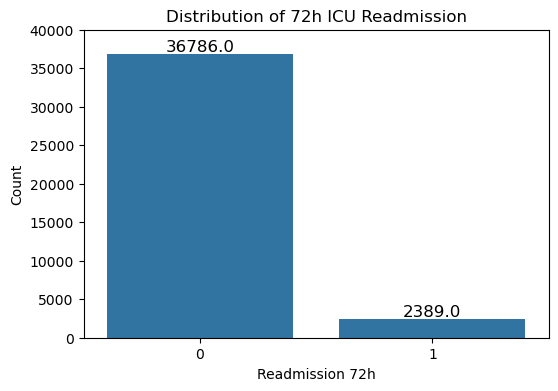

In [27]:

plt.figure(figsize=(6,4))
ax = sns.countplot(x='readmit_72h', data=df_clean)

# Add counts on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height}",
        (p.get_x() + p.get_width() / 2, height),
        ha='center', va='bottom',
        fontsize=12
    )

plt.title("Distribution of 72h ICU Readmission")
plt.xlabel("Readmission 72h")
plt.ylabel("Count")

plt.ylim(0, 40000)

plt.show()

Problème de débalancement de classe

## Distribution of key variables and correlation with outcome

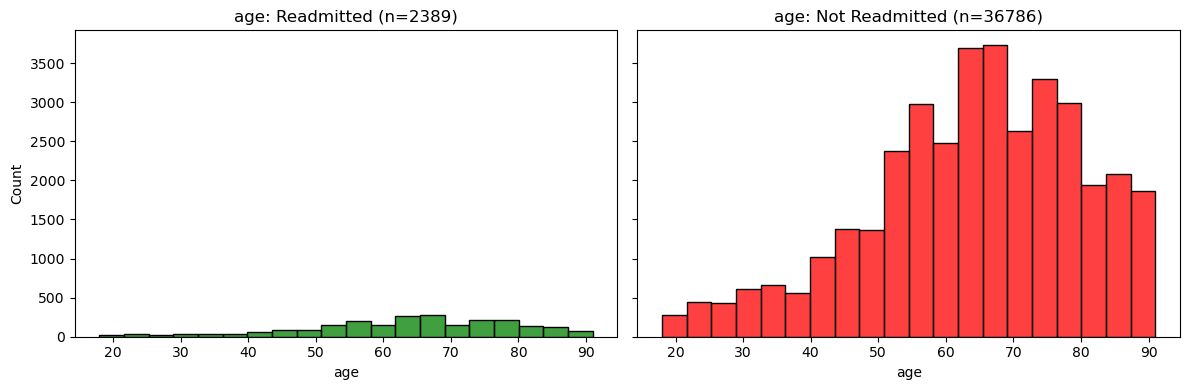

In [28]:
# Age
plot_readmit_distribution(df_clean, "age")

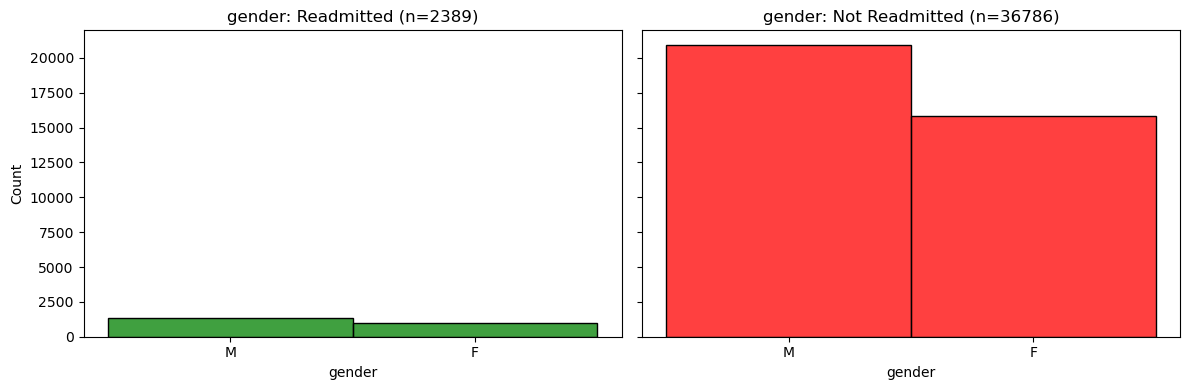

In [29]:
# Gender
plot_readmit_distribution(df_clean, "gender")

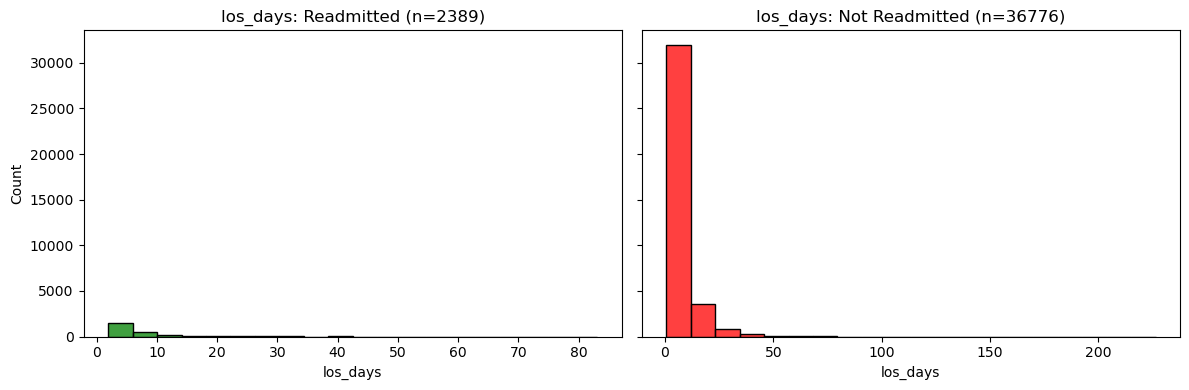

In [30]:
# los_hours
plot_readmit_distribution(df_clean, "los_days")

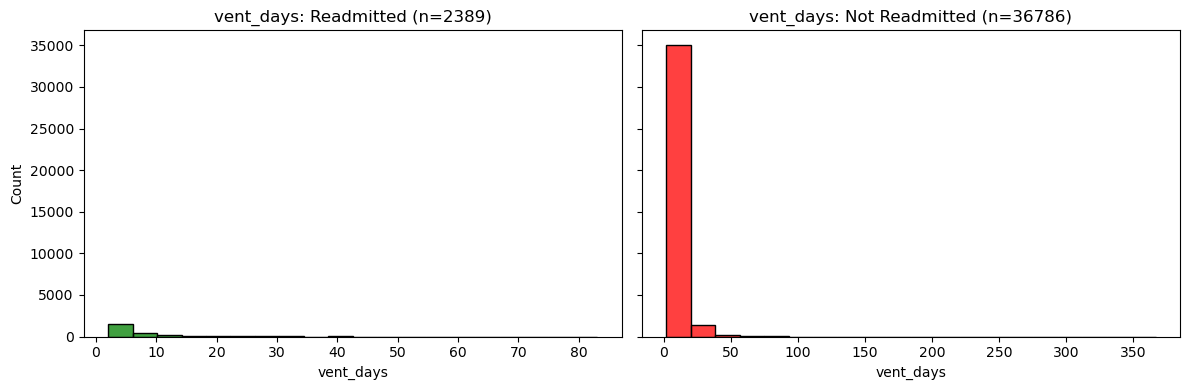

In [31]:
# vent_hours
plot_readmit_distribution(df_clean, "vent_days")

/Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/MMD6020 Fondements médecine computationnelle/Projet/models.py:175: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=readmitted.astype(int), ax=ax,
/Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/MMD6020 Fondements médecine computationnelle/Projet/models.py:193: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=not_readmitted.astype(int), ax=ax,


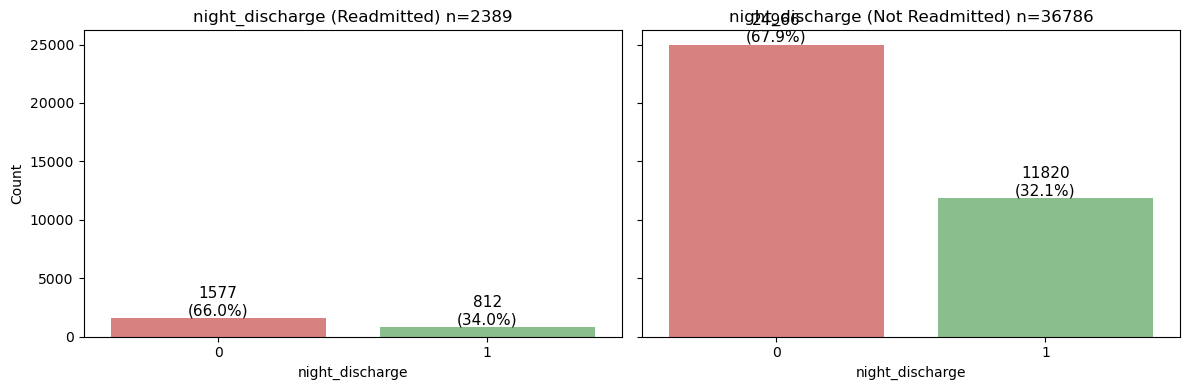

In [32]:
# night_discharge
plot_readmit_distribution(df_clean, "night_discharge", binary=True)

/Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/MMD6020 Fondements médecine computationnelle/Projet/models.py:175: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=readmitted.astype(int), ax=ax,
/Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/MMD6020 Fondements médecine computationnelle/Projet/models.py:193: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=not_readmitted.astype(int), ax=ax,


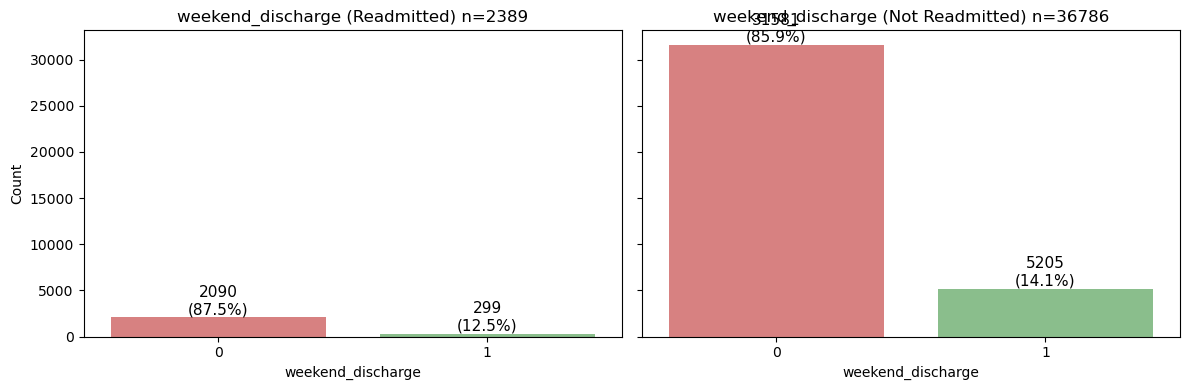

In [33]:
# weekend_discharge
plot_readmit_distribution(df_clean, "weekend_discharge", binary=True)

## Exploring missing variables and mechanisms of missingness
Nous avons vu avec `df_clean.info()` plus haut que les variables ayant le plus de valeurs manquantes étaient:
- GCS
- MAP
- FIO2
- PAO2
- lactates
- bili

Explorons les mécanismes de manquance de ces variables, pour voir si la manquance est:
- totalement aléatoire (Missing Completely At Random, MCAR)
- en lien avec d'autres variables (Missing At Random, MAR)
- en lien avec l'issue (Missing Not At Random, MNAR)

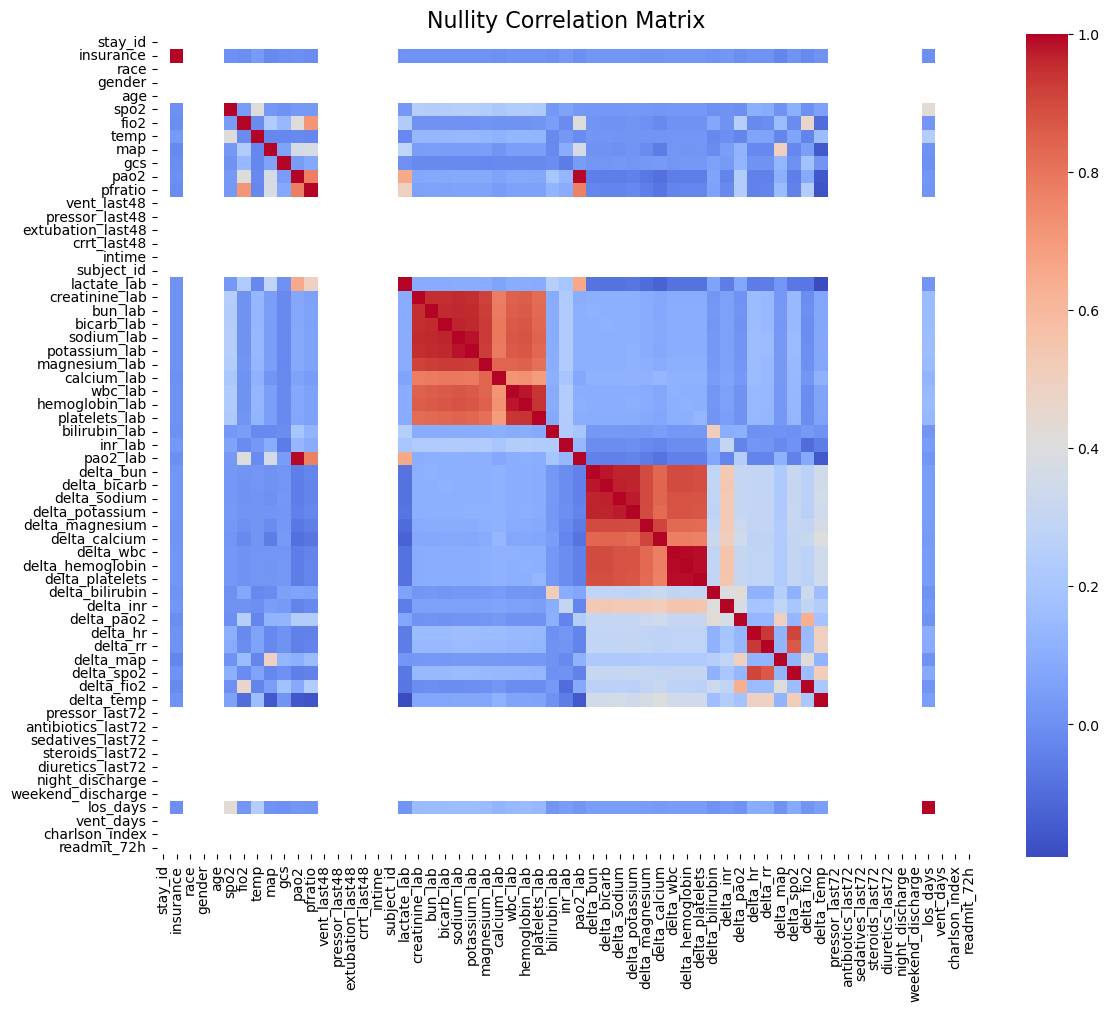

In [34]:
# Coefficient de nullité
corr_null = plot_nullity_correlation(df_clean)

/Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/MMD6020 Fondements médecine computationnelle/Projet/models.py:246: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=missing_group[outcome], palette="Blues", ax=ax)
/Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/MMD6020 Fondements médecine computationnelle/Projet/models.py:251: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["No Readmit", "Readmit"])
/Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/MMD6020 Fondements médecine computationnelle/Projet/models.py:264: FutureWarning: 

Passing `pal

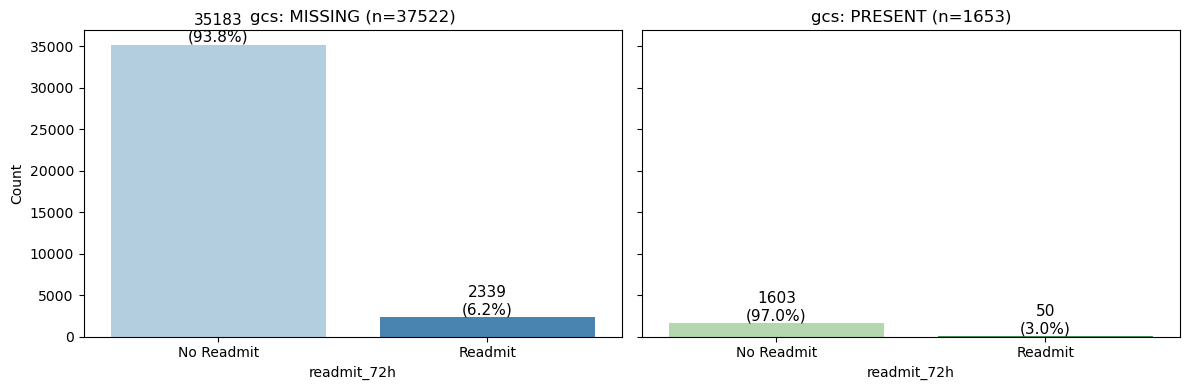

In [35]:
plot_missing_distribution(df_clean, "gcs")

/Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/MMD6020 Fondements médecine computationnelle/Projet/models.py:246: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=missing_group[outcome], palette="Blues", ax=ax)
/Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/MMD6020 Fondements médecine computationnelle/Projet/models.py:251: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["No Readmit", "Readmit"])
/Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/MMD6020 Fondements médecine computationnelle/Projet/models.py:264: FutureWarning: 

Passing `pal

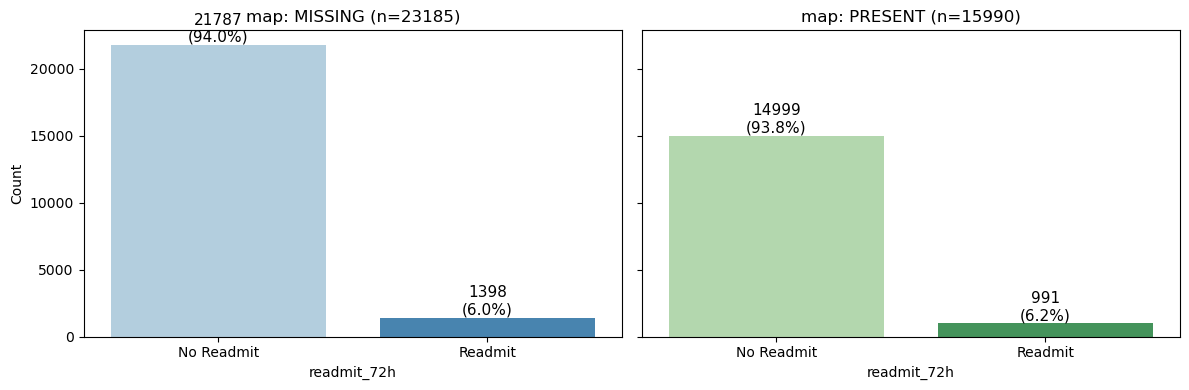

In [36]:
plot_missing_distribution(df_clean, "map")

/Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/MMD6020 Fondements médecine computationnelle/Projet/models.py:246: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=missing_group[outcome], palette="Blues", ax=ax)
/Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/MMD6020 Fondements médecine computationnelle/Projet/models.py:251: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["No Readmit", "Readmit"])
/Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/MMD6020 Fondements médecine computationnelle/Projet/models.py:264: FutureWarning: 

Passing `pal

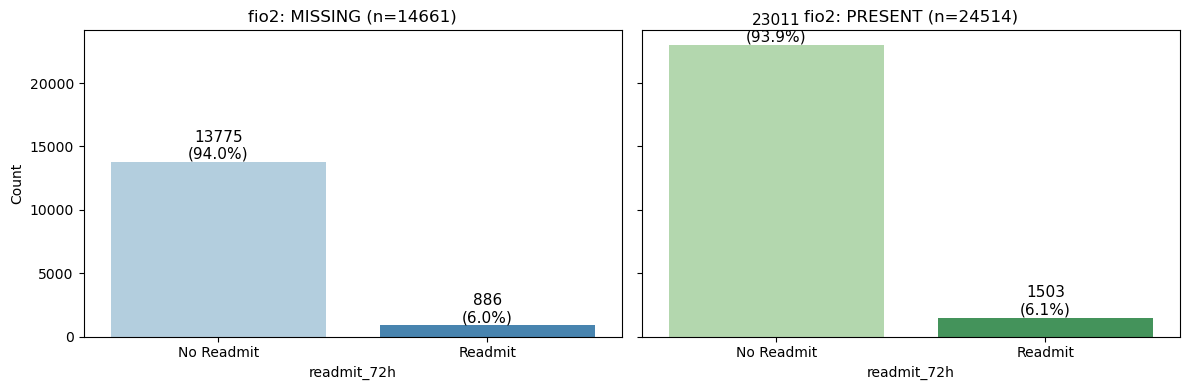

In [37]:
plot_missing_distribution(df_clean, "fio2")

/Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/MMD6020 Fondements médecine computationnelle/Projet/models.py:246: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=missing_group[outcome], palette="Blues", ax=ax)
/Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/MMD6020 Fondements médecine computationnelle/Projet/models.py:251: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["No Readmit", "Readmit"])
/Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/MMD6020 Fondements médecine computationnelle/Projet/models.py:264: FutureWarning: 

Passing `pal

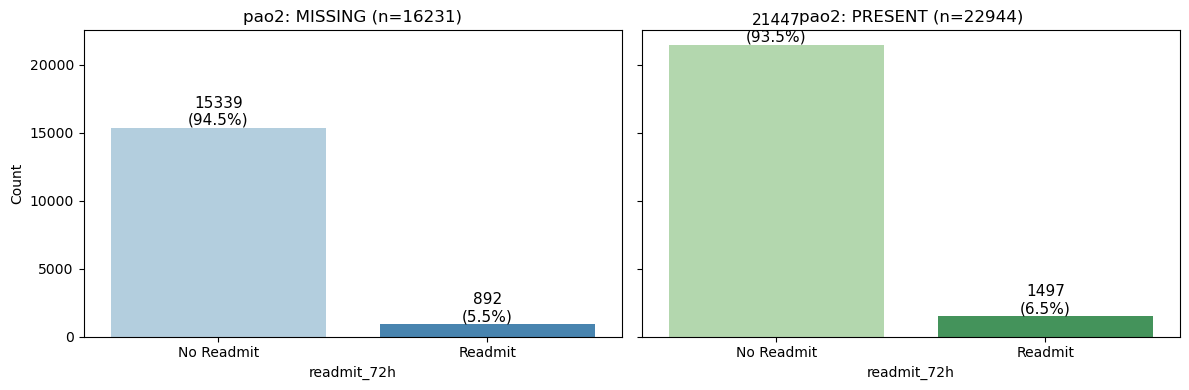

In [38]:
plot_missing_distribution(df_clean, "pao2")

/Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/MMD6020 Fondements médecine computationnelle/Projet/models.py:246: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=missing_group[outcome], palette="Blues", ax=ax)
/Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/MMD6020 Fondements médecine computationnelle/Projet/models.py:251: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["No Readmit", "Readmit"])
/Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/MMD6020 Fondements médecine computationnelle/Projet/models.py:264: FutureWarning: 

Passing `pal

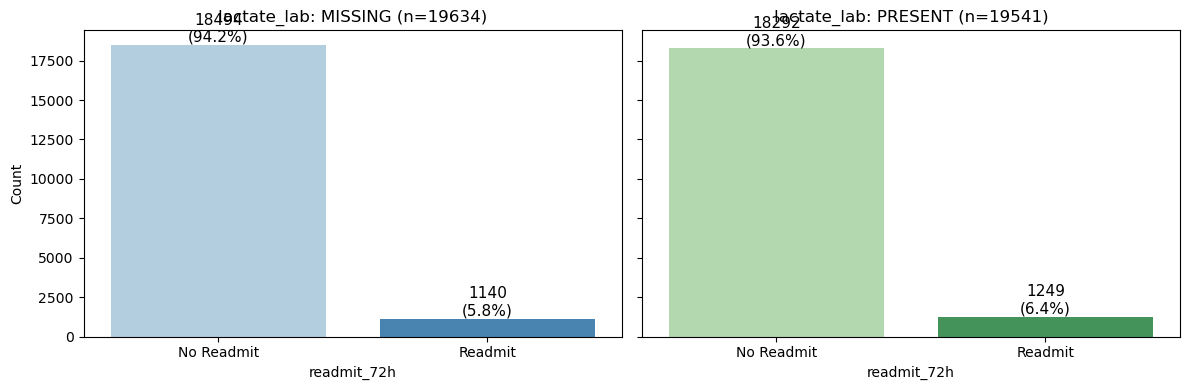

In [39]:
plot_missing_distribution(df_clean, "lactate_lab")

/Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/MMD6020 Fondements médecine computationnelle/Projet/models.py:246: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=missing_group[outcome], palette="Blues", ax=ax)
/Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/MMD6020 Fondements médecine computationnelle/Projet/models.py:251: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["No Readmit", "Readmit"])
/Users/qili/Library/CloudStorage/OneDrive-SanteetServicessociaux/Soins intensifs/Érudition/Recherche/MSc MedComp/MMD6020 Fondements médecine computationnelle/Projet/models.py:264: FutureWarning: 

Passing `pal

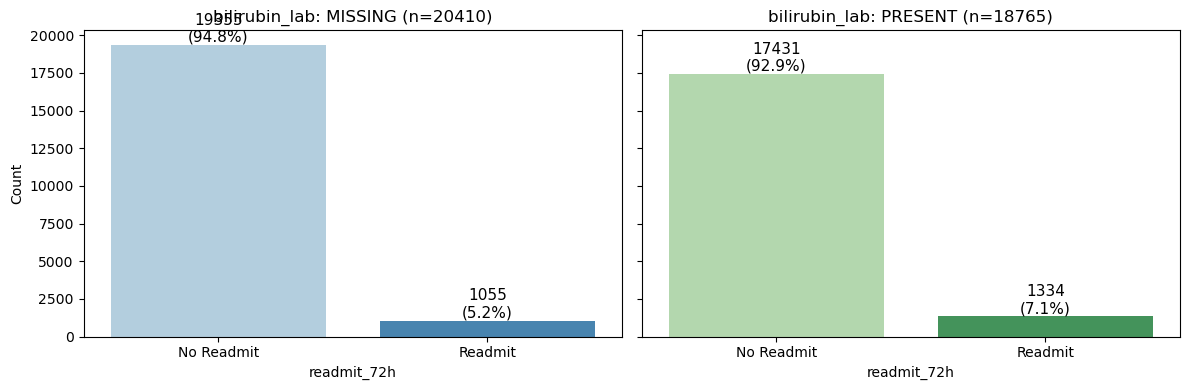

In [40]:
plot_missing_distribution(df_clean, "bilirubin_lab")

Selon notre connaissance clinique du domaine, les variables risquent davantage d'être manquantes lorsqu'un patient va bien (on tend à faire moins de prises de sang chez un patient stable). 
Ainsi, au lieu de simplement supprimer toutes les entrées avec variables manquantes, nous choisissons **d'encoder la manquance** de chacune de ces variables, et d'utiliser cette nouvelle variable de manquance comme feature prédicteur dans notre modèle. 

## Traitement des données aberrantes


--- Plotting age ---


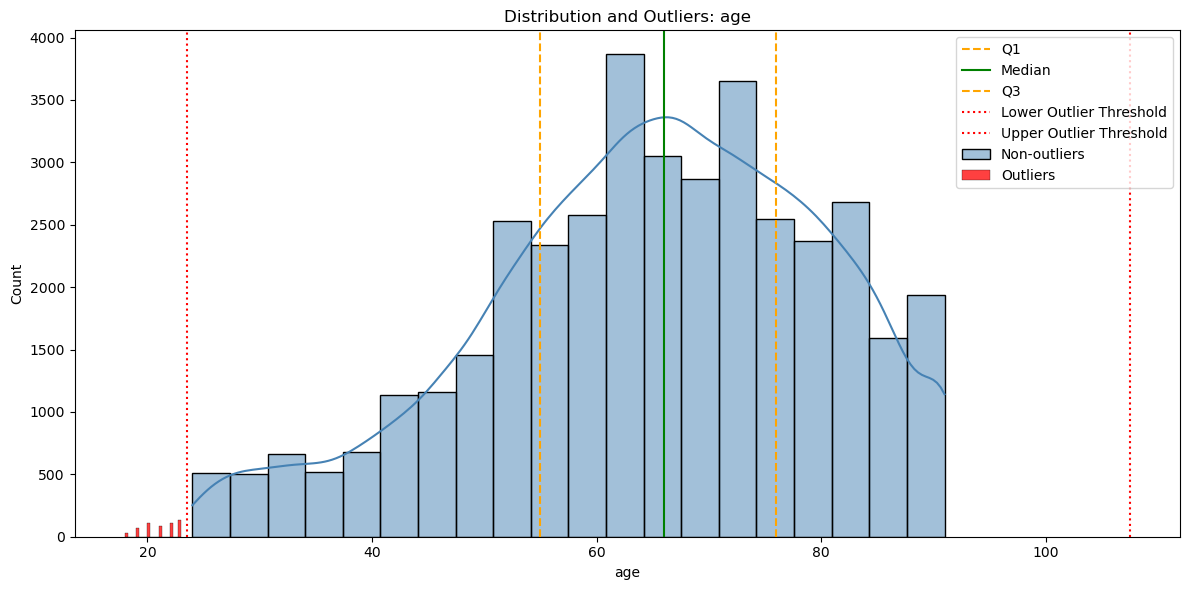

----- age -----
Q1: 55.000
Median: 66.000
Q3: 76.000
IQR: 21.000
Lower bound: 23.500
Upper bound: 107.500
Outliers detected: 541

--- Plotting spo2 ---


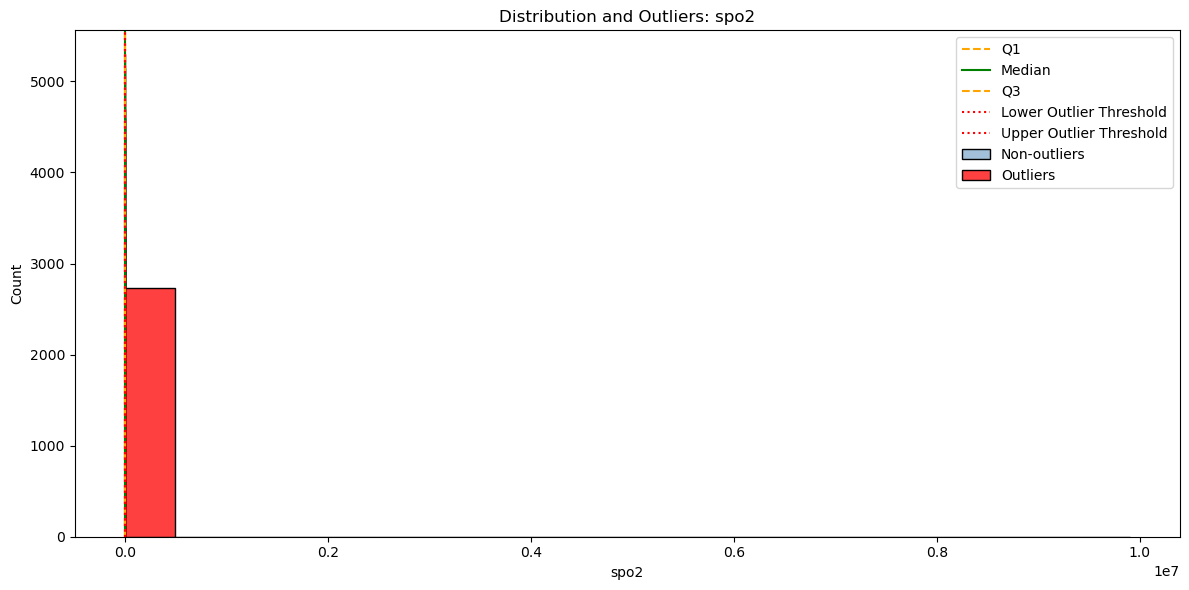

----- spo2 -----
Q1: 94.000
Median: 96.000
Q3: 98.000
IQR: 4.000
Lower bound: 88.000
Upper bound: 104.000
Outliers detected: 2733

--- Plotting fio2 ---


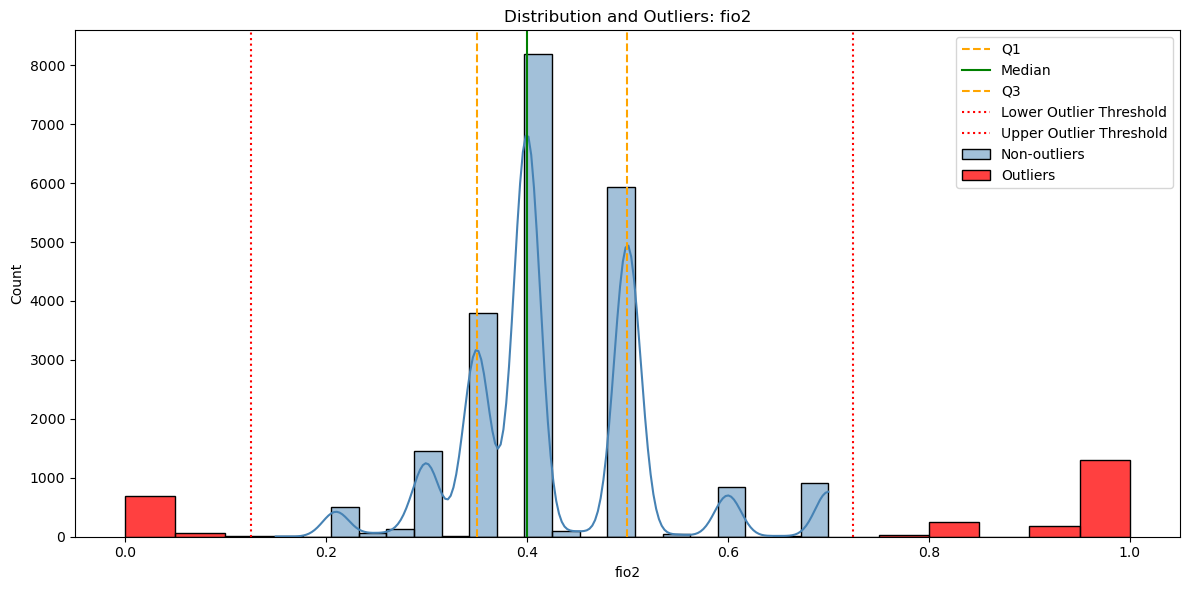

----- fio2 -----
Q1: 0.350
Median: 0.400
Q3: 0.500
IQR: 0.150
Lower bound: 0.125
Upper bound: 0.725
Outliers detected: 2515

--- Plotting map ---


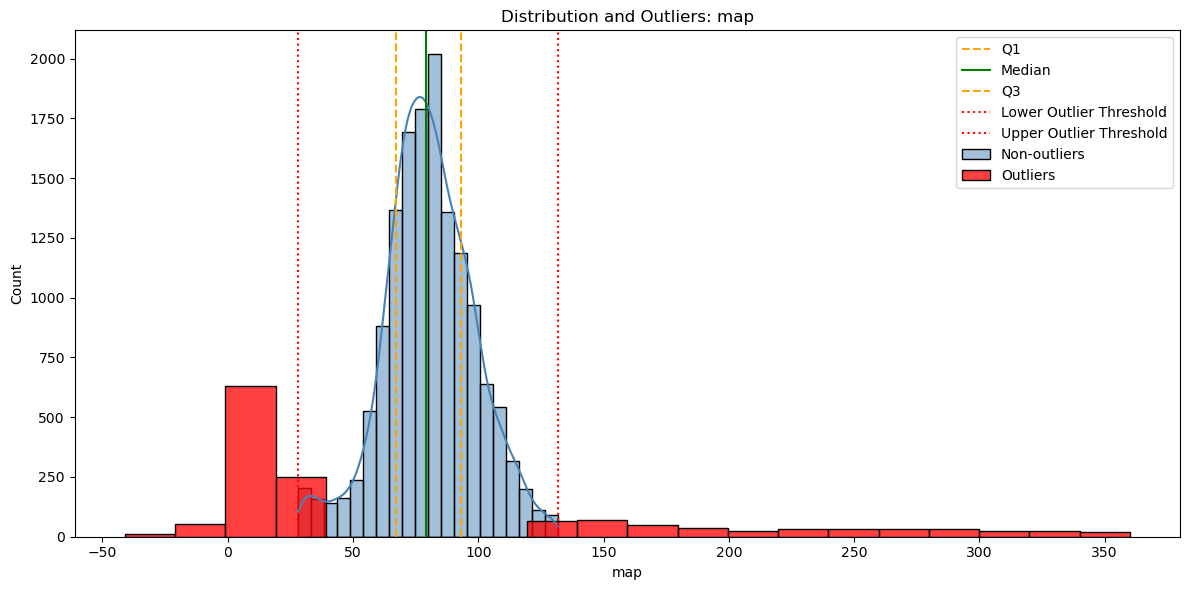

----- map -----
Q1: 67.000
Median: 79.000
Q3: 93.000
IQR: 26.000
Lower bound: 28.000
Upper bound: 132.000
Outliers detected: 1392

--- Plotting temp ---


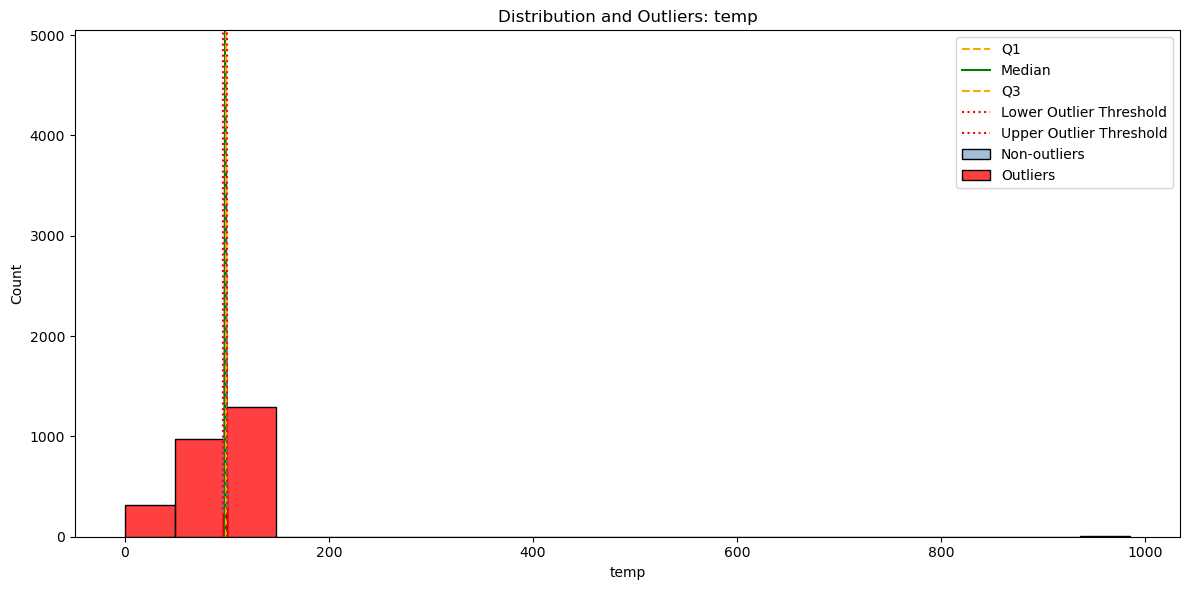

----- temp -----
Q1: 97.800
Median: 98.200
Q3: 98.700
IQR: 0.900
Lower bound: 96.450
Upper bound: 100.050
Outliers detected: 2587

--- Plotting gcs ---


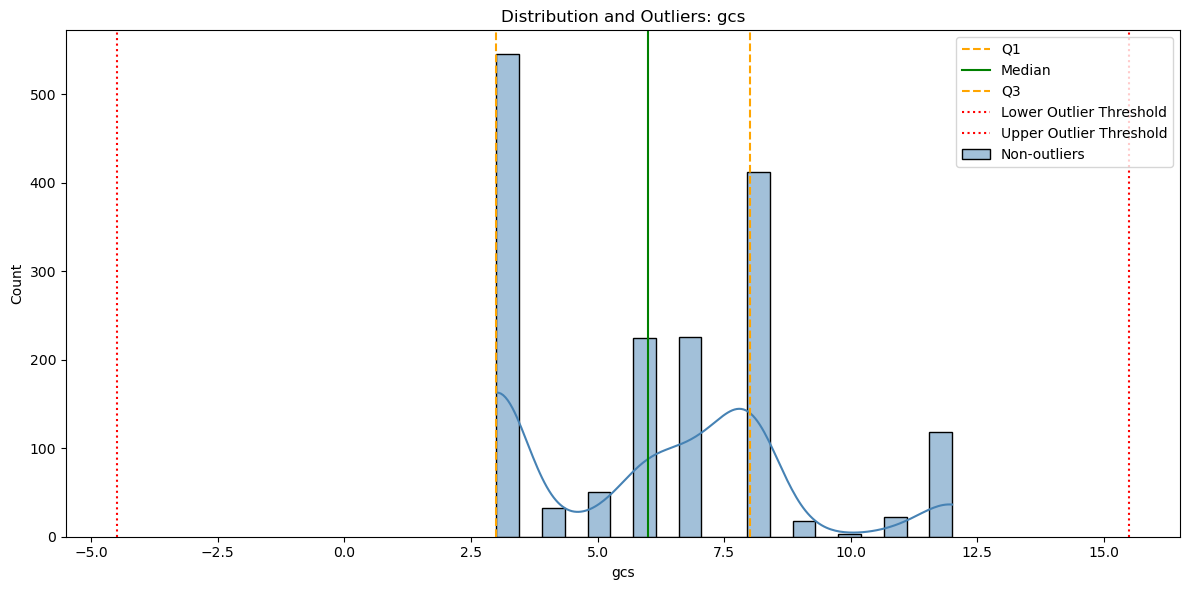

----- gcs -----
Q1: 3.000
Median: 6.000
Q3: 8.000
IQR: 5.000
Lower bound: -4.500
Upper bound: 15.500
Outliers detected: 0

--- Plotting pao2 ---


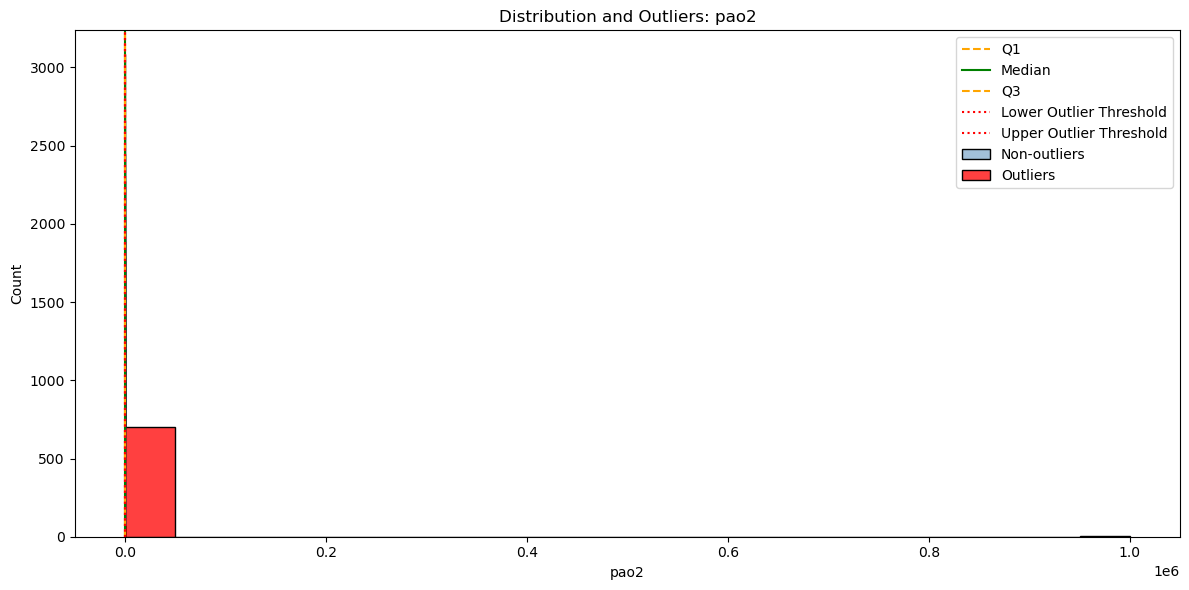

----- pao2 -----
Q1: 54.000
Median: 87.000
Q3: 120.000
IQR: 66.000
Lower bound: -45.000
Upper bound: 219.000
Outliers detected: 709

--- Plotting pfratio ---


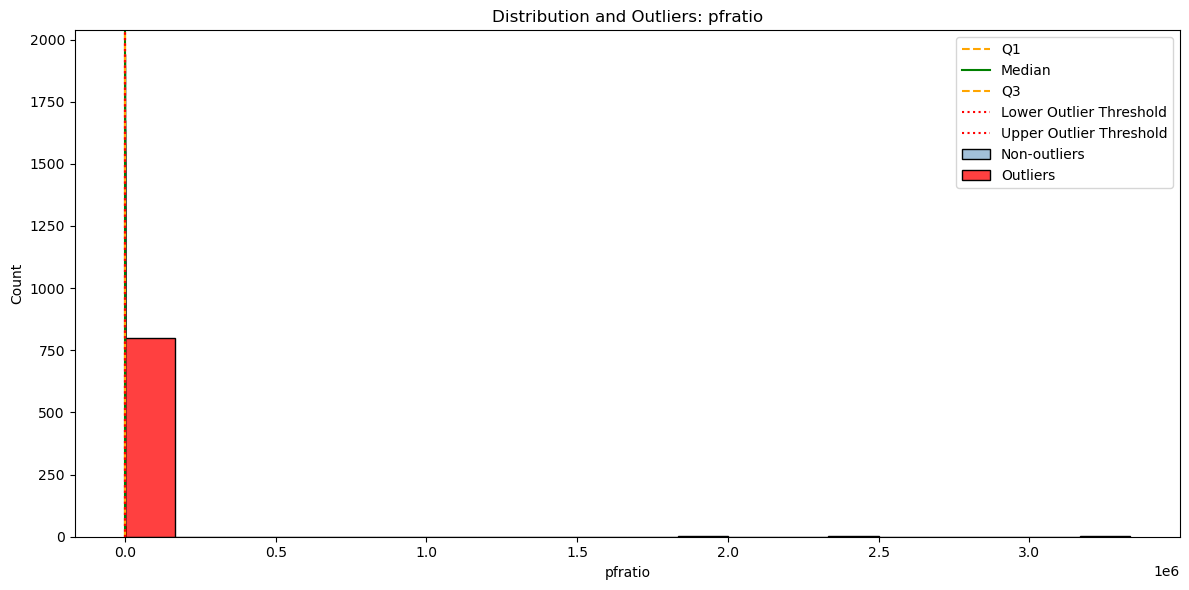

----- pfratio -----
Q1: 125.714
Median: 207.500
Q3: 307.500
IQR: 181.786
Lower bound: -146.964
Upper bound: 580.179
Outliers detected: 806

--- Plotting lactate_lab ---


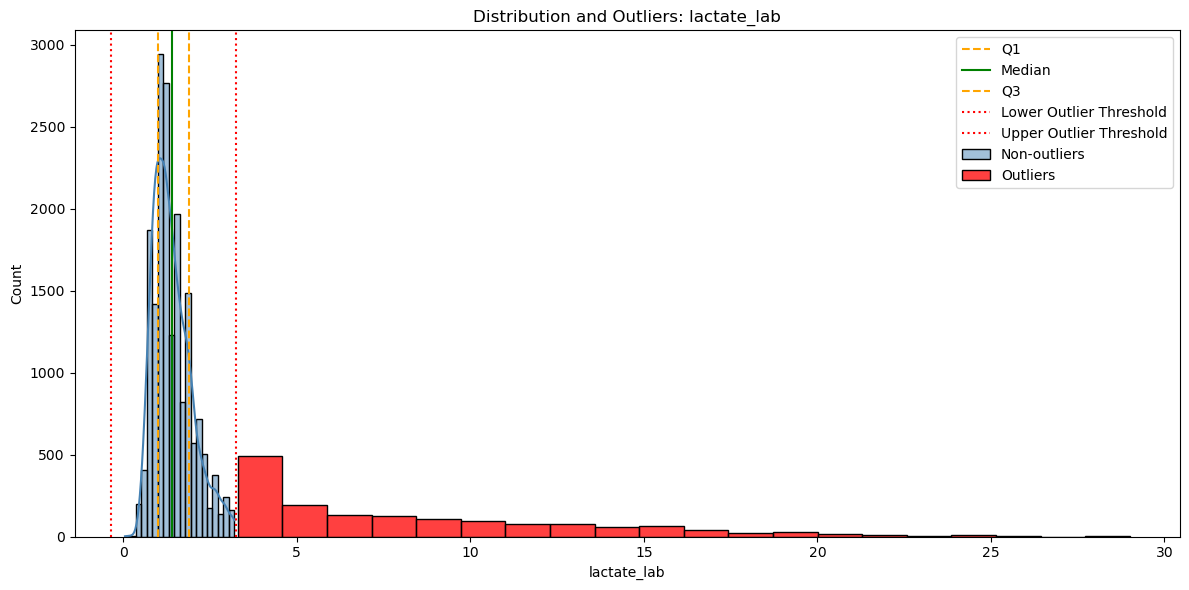

----- lactate_lab -----
Q1: 1.000
Median: 1.400
Q3: 1.900
IQR: 0.900
Lower bound: -0.350
Upper bound: 3.250
Outliers detected: 1553

--- Plotting creatinine_lab ---


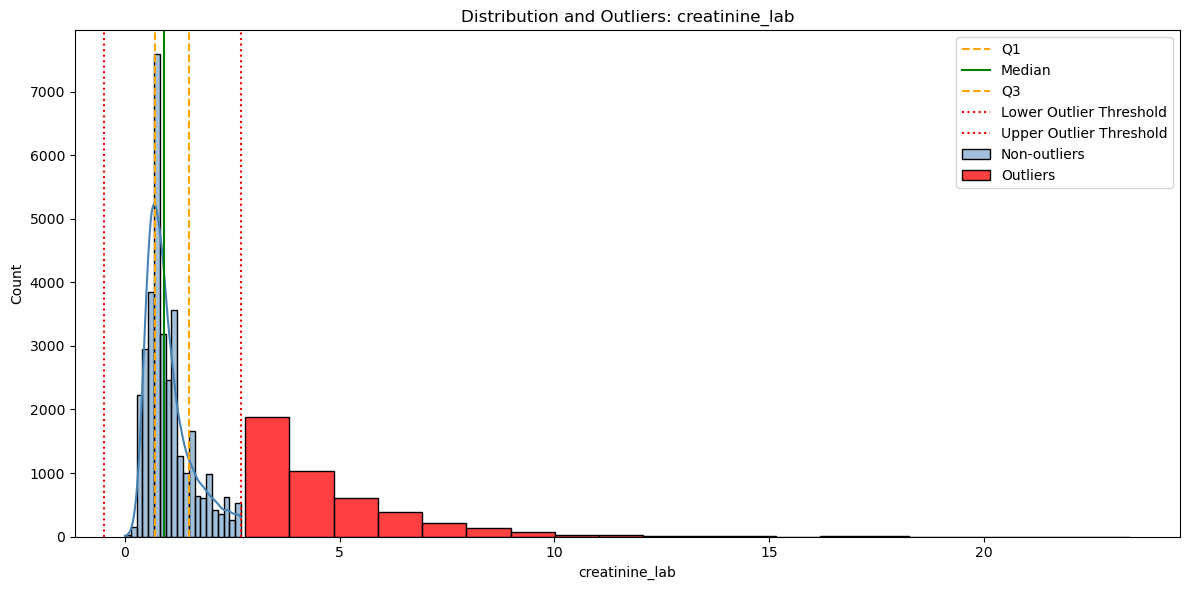

----- creatinine_lab -----
Q1: 0.700
Median: 0.900
Q3: 1.500
IQR: 0.800
Lower bound: -0.500
Upper bound: 2.700
Outliers detected: 4424

--- Plotting bun_lab ---


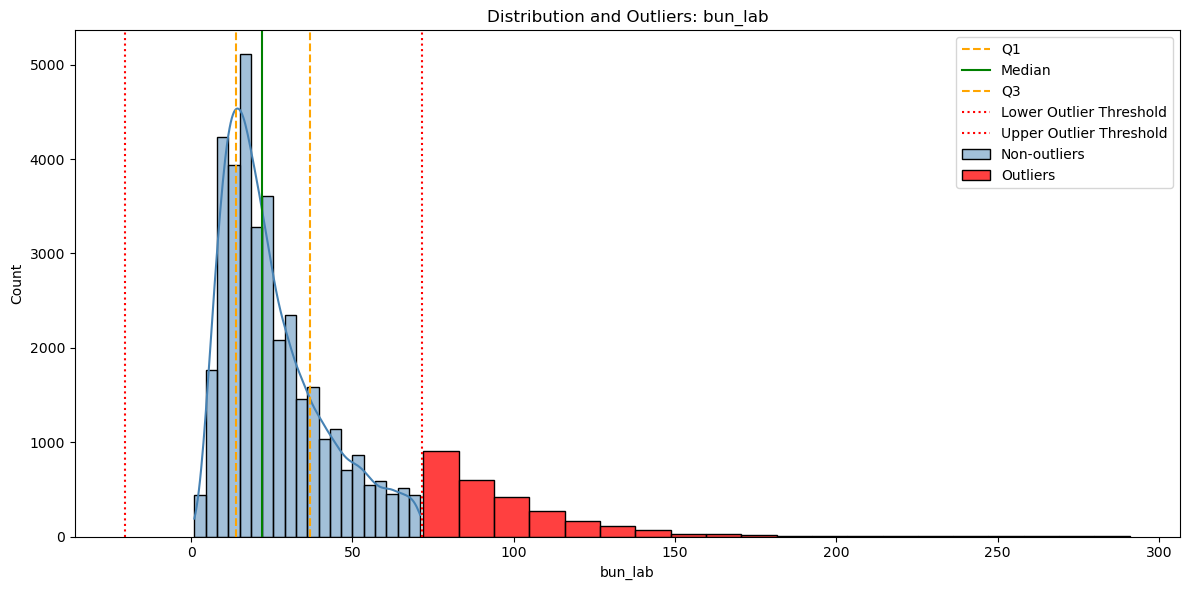

----- bun_lab -----
Q1: 14.000
Median: 22.000
Q3: 37.000
IQR: 23.000
Lower bound: -20.500
Upper bound: 71.500
Outliers detected: 2638

--- Plotting bicarb_lab ---


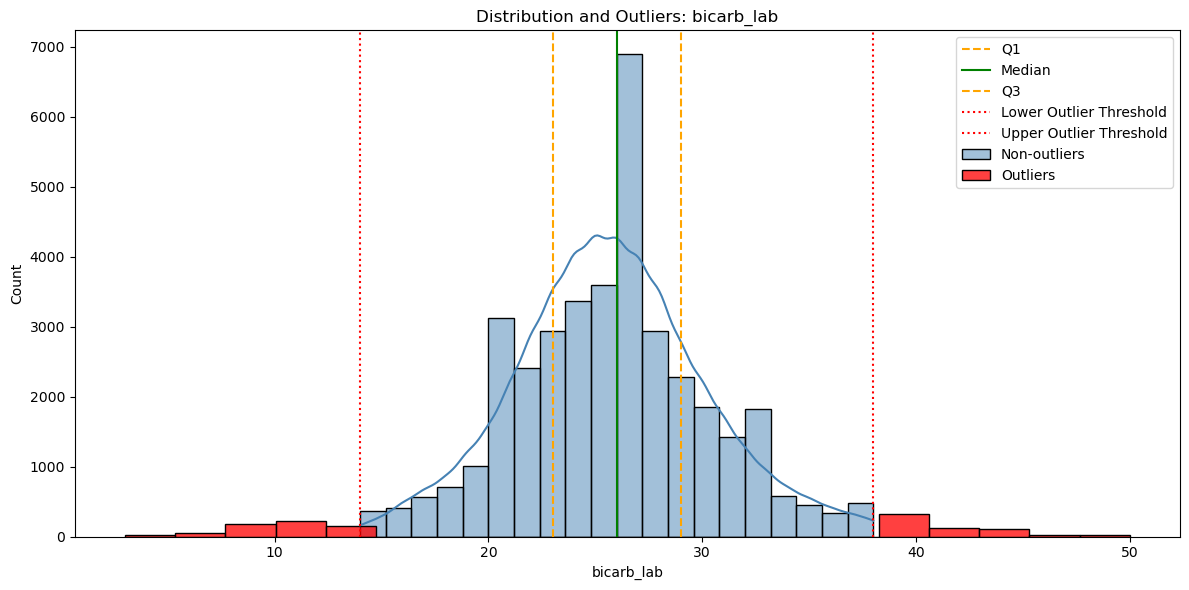

----- bicarb_lab -----
Q1: 23.000
Median: 26.000
Q3: 29.000
IQR: 6.000
Lower bound: 14.000
Upper bound: 38.000
Outliers detected: 1226

--- Plotting sodium_lab ---


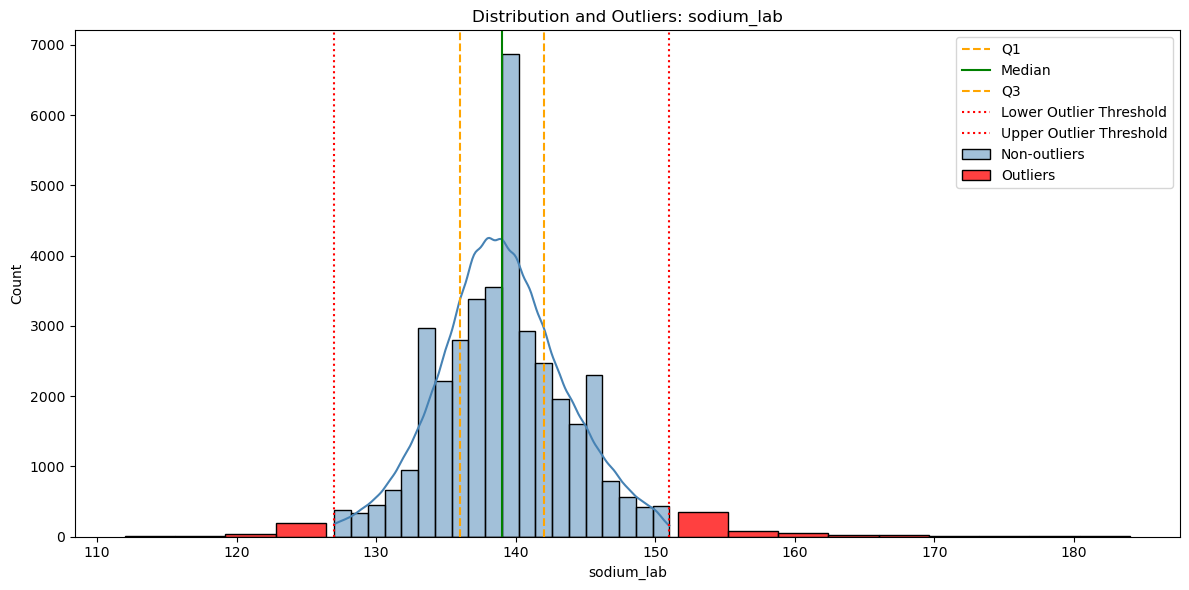

----- sodium_lab -----
Q1: 136.000
Median: 139.000
Q3: 142.000
IQR: 6.000
Lower bound: 127.000
Upper bound: 151.000
Outliers detected: 790

--- Plotting potassium_lab ---


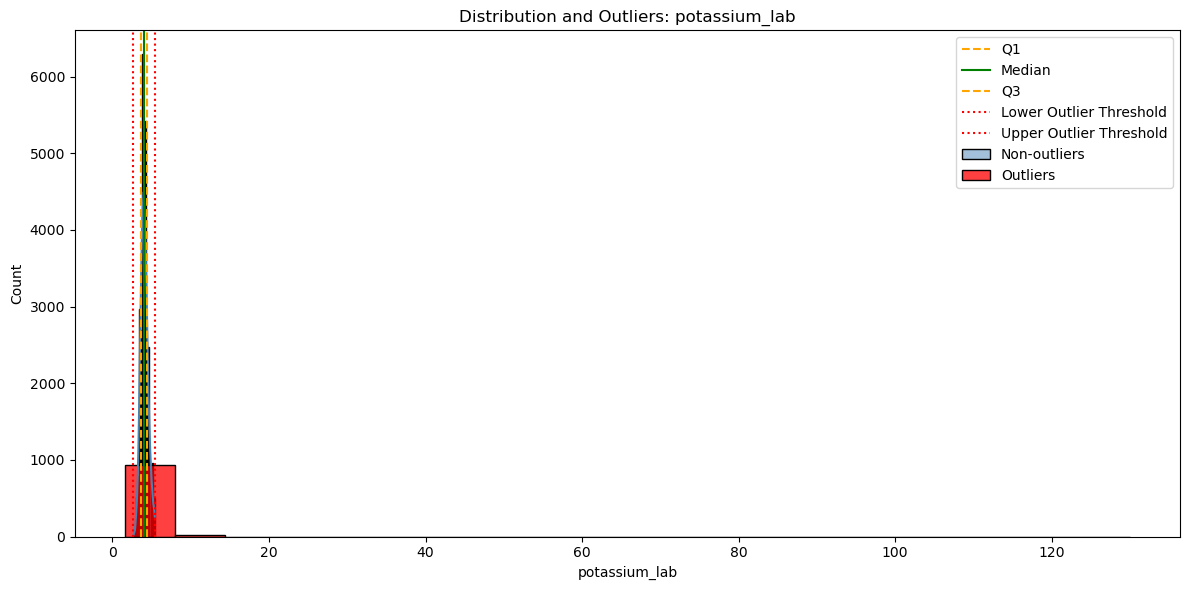

----- potassium_lab -----
Q1: 3.700
Median: 4.000
Q3: 4.400
IQR: 0.700
Lower bound: 2.650
Upper bound: 5.450
Outliers detected: 953

--- Plotting magnesium_lab ---


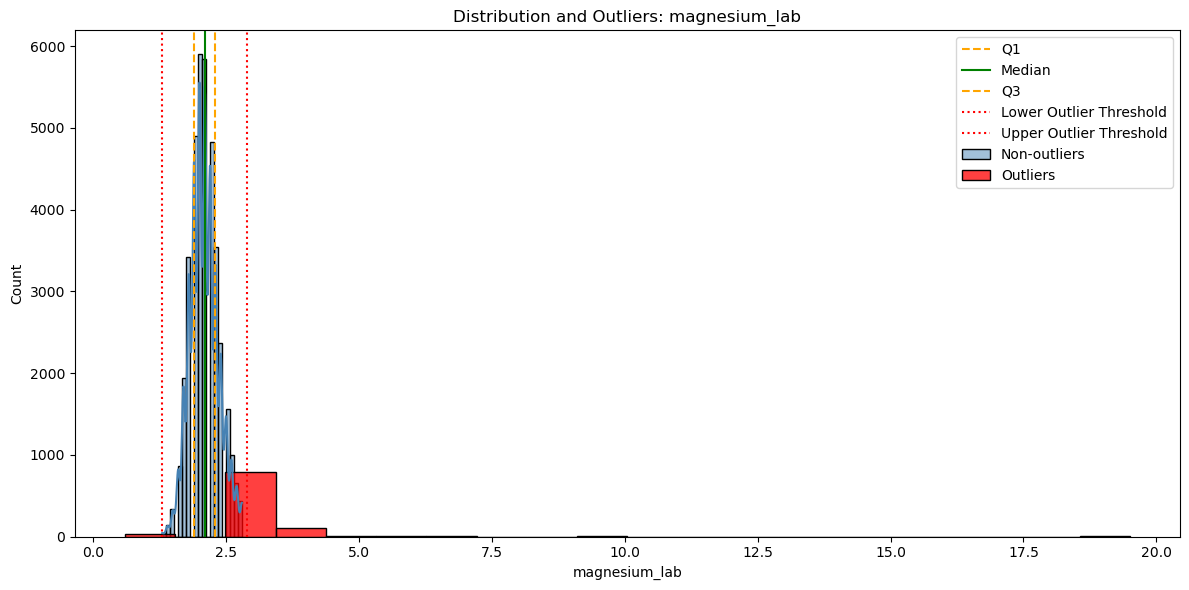

----- magnesium_lab -----
Q1: 1.900
Median: 2.100
Q3: 2.300
IQR: 0.400
Lower bound: 1.300
Upper bound: 2.900
Outliers detected: 950

--- Plotting calcium_lab ---


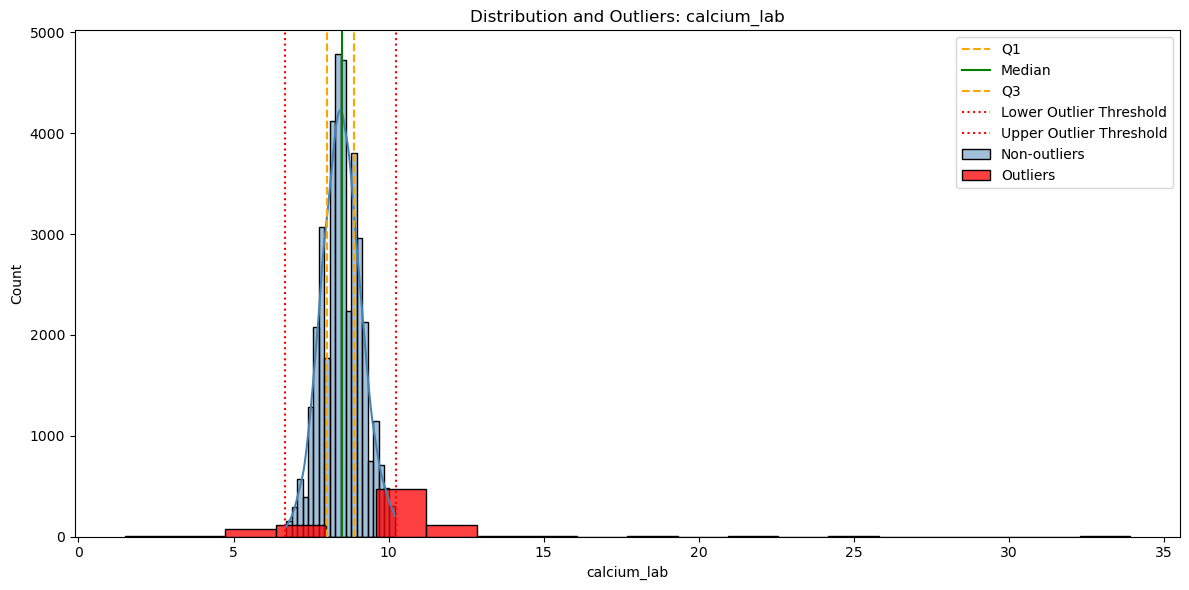

----- calcium_lab -----
Q1: 8.000
Median: 8.500
Q3: 8.900
IQR: 0.900
Lower bound: 6.650
Upper bound: 10.250
Outliers detected: 802

--- Plotting wbc_lab ---


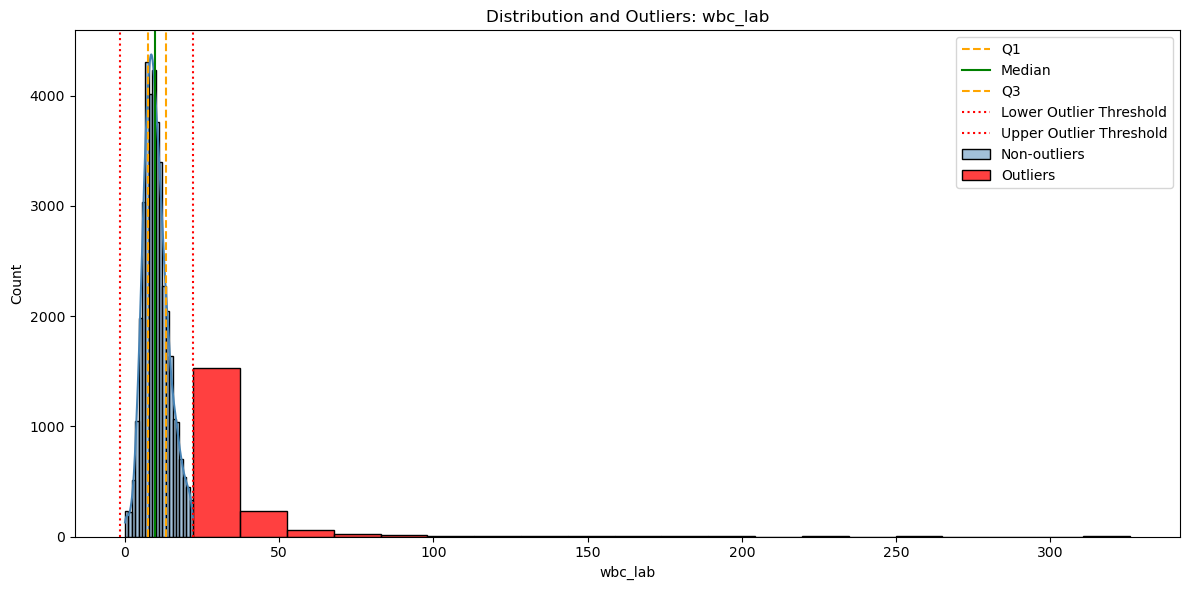

----- wbc_lab -----
Q1: 7.400
Median: 9.900
Q3: 13.300
IQR: 5.900
Lower bound: -1.450
Upper bound: 22.150
Outliers detected: 1889

--- Plotting hemoglobin_lab ---


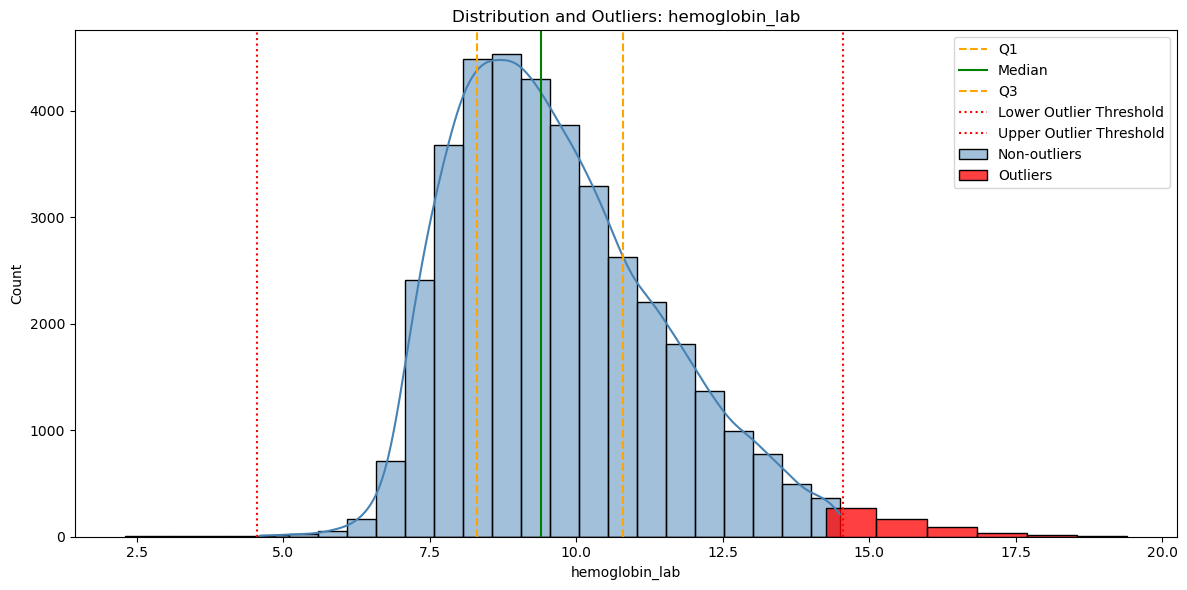

----- hemoglobin_lab -----
Q1: 8.300
Median: 9.400
Q3: 10.800
IQR: 2.500
Lower bound: 4.550
Upper bound: 14.550
Outliers detected: 589

--- Plotting platelets_lab ---


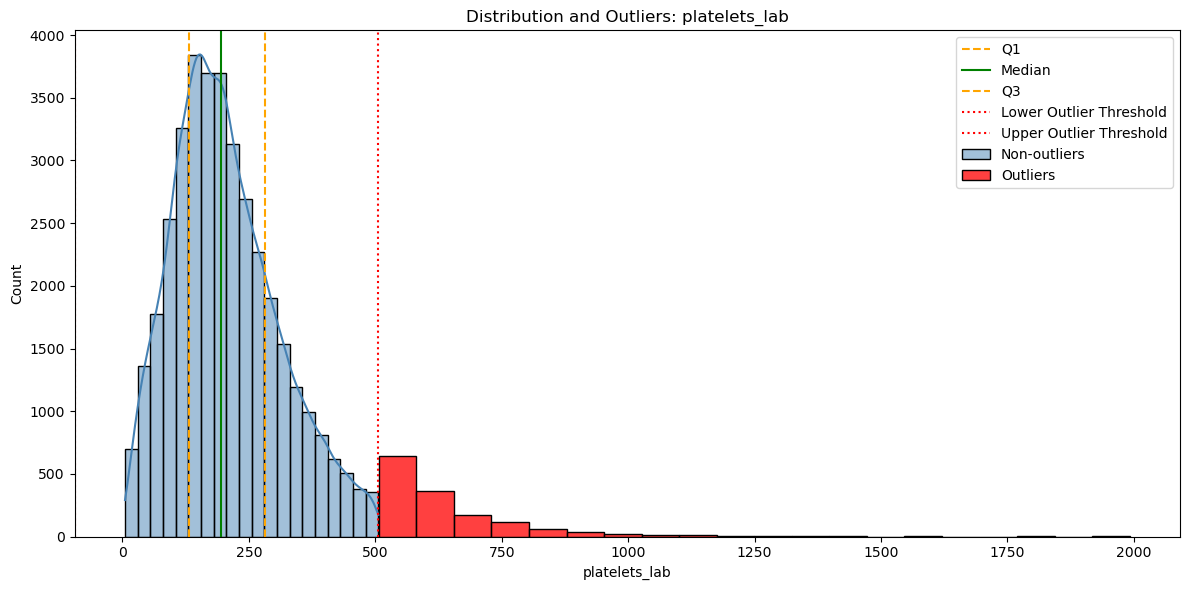

----- platelets_lab -----
Q1: 131.000
Median: 195.000
Q3: 281.000
IQR: 150.000
Lower bound: -94.000
Upper bound: 506.000
Outliers detected: 1450

--- Plotting bilirubin_lab ---


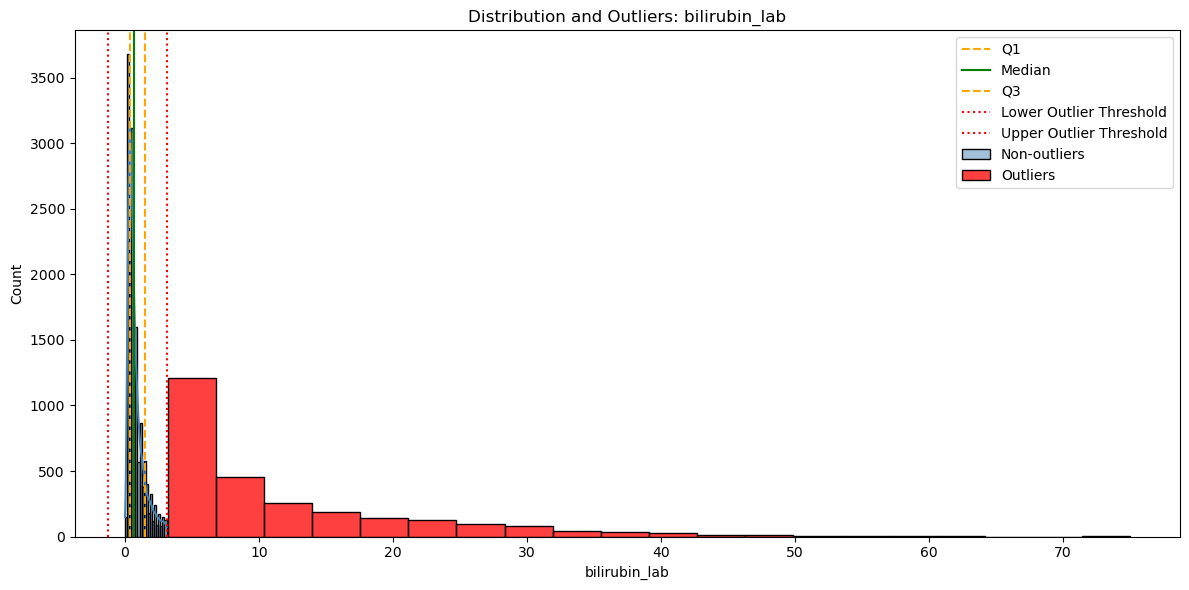

----- bilirubin_lab -----
Q1: 0.400
Median: 0.700
Q3: 1.500
IQR: 1.100
Lower bound: -1.250
Upper bound: 3.150
Outliers detected: 2699

--- Plotting inr_lab ---


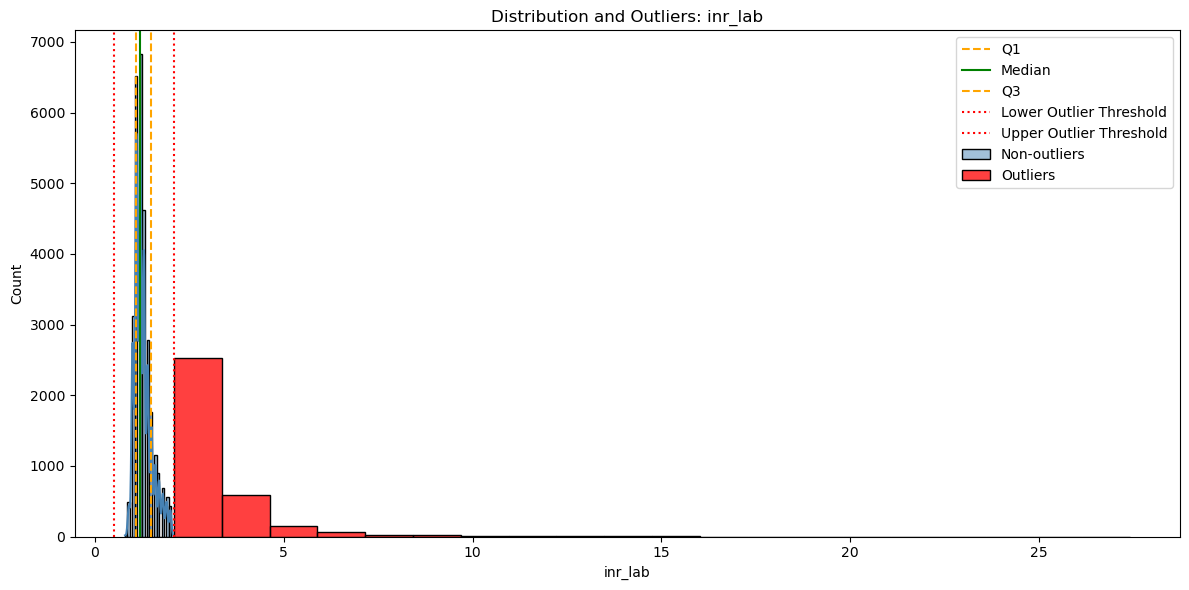

----- inr_lab -----
Q1: 1.100
Median: 1.200
Q3: 1.500
IQR: 0.400
Lower bound: 0.500
Upper bound: 2.100
Outliers detected: 3398

--- Plotting pao2_lab ---


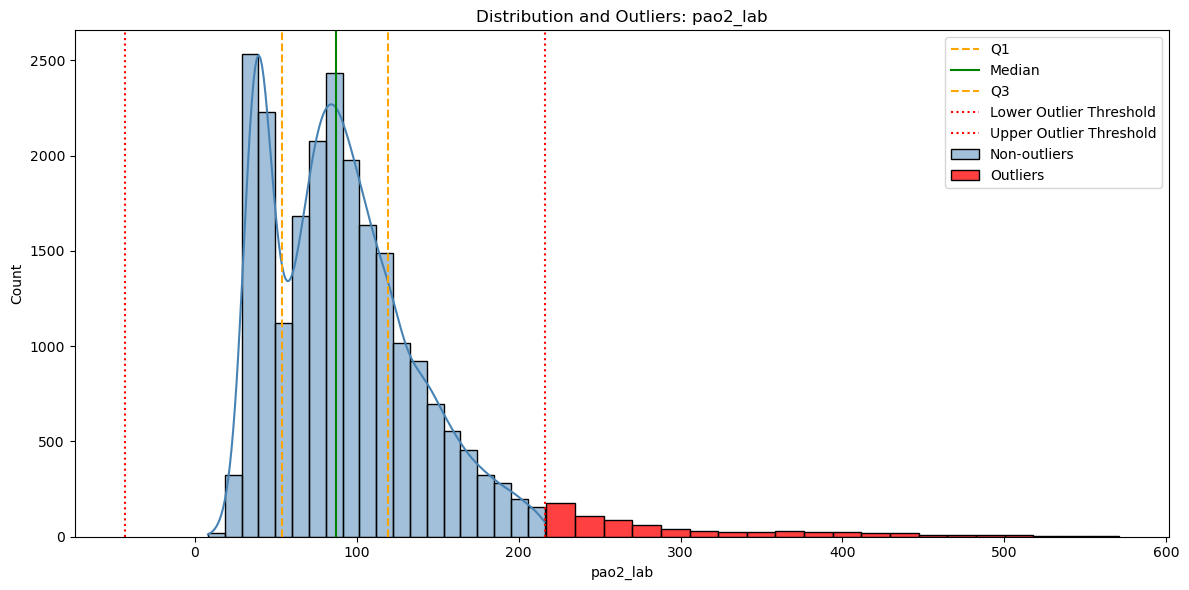

----- pao2_lab -----
Q1: 54.000
Median: 87.000
Q3: 119.000
IQR: 65.000
Lower bound: -43.500
Upper bound: 216.500
Outliers detected: 707

--- Plotting delta_bun ---


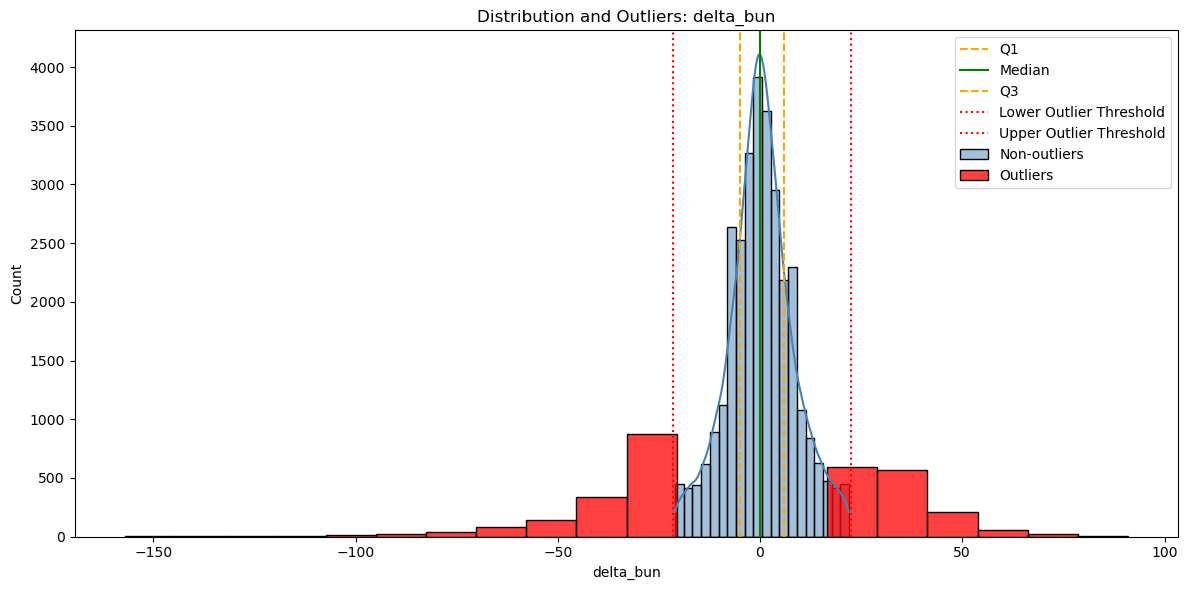

----- delta_bun -----
Q1: -5.000
Median: 0.000
Q3: 6.000
IQR: 11.000
Lower bound: -21.500
Upper bound: 22.500
Outliers detected: 2976

--- Plotting delta_bicarb ---


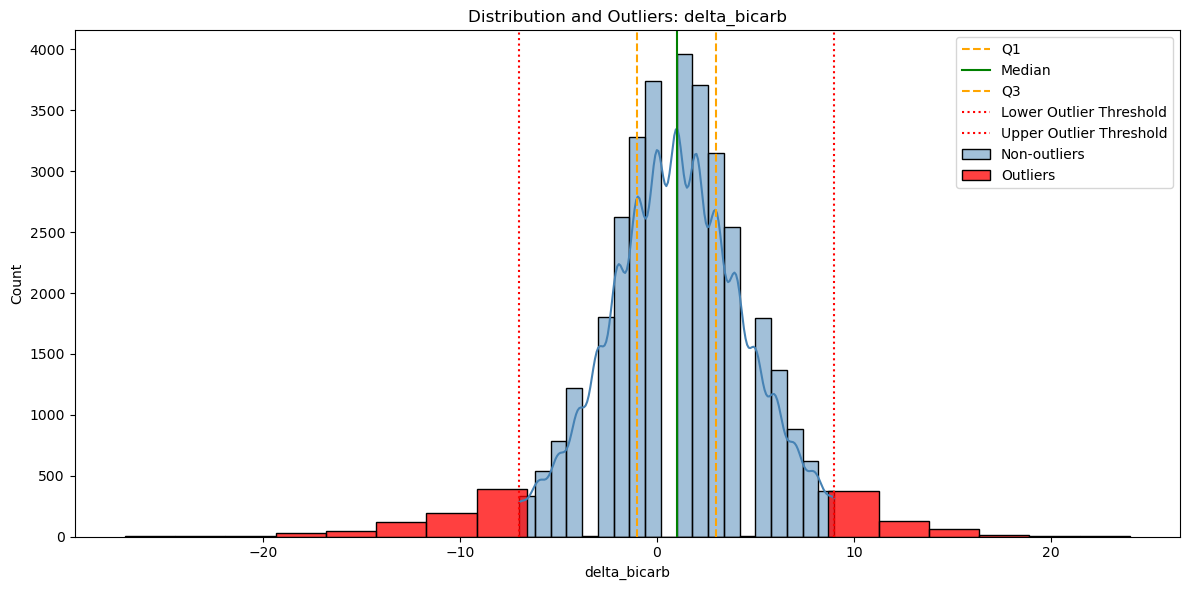

----- delta_bicarb -----
Q1: -1.000
Median: 1.000
Q3: 3.000
IQR: 4.000
Lower bound: -7.000
Upper bound: 9.000
Outliers detected: 1371

--- Plotting delta_sodium ---


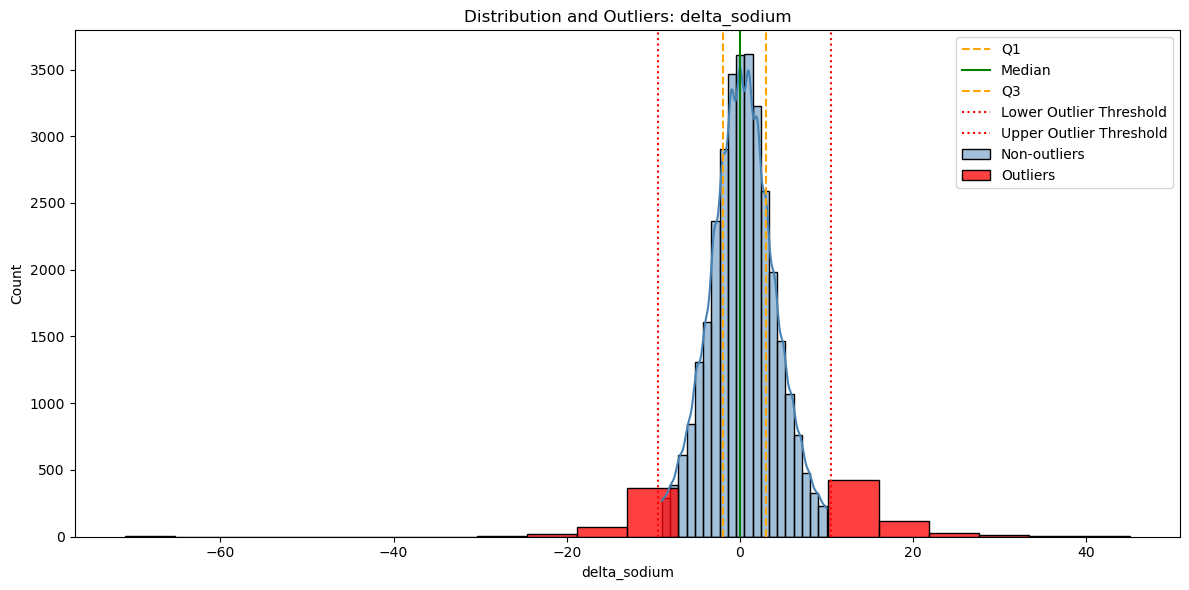

----- delta_sodium -----
Q1: -2.000
Median: 0.000
Q3: 3.000
IQR: 5.000
Lower bound: -9.500
Upper bound: 10.500
Outliers detected: 1035

--- Plotting delta_potassium ---


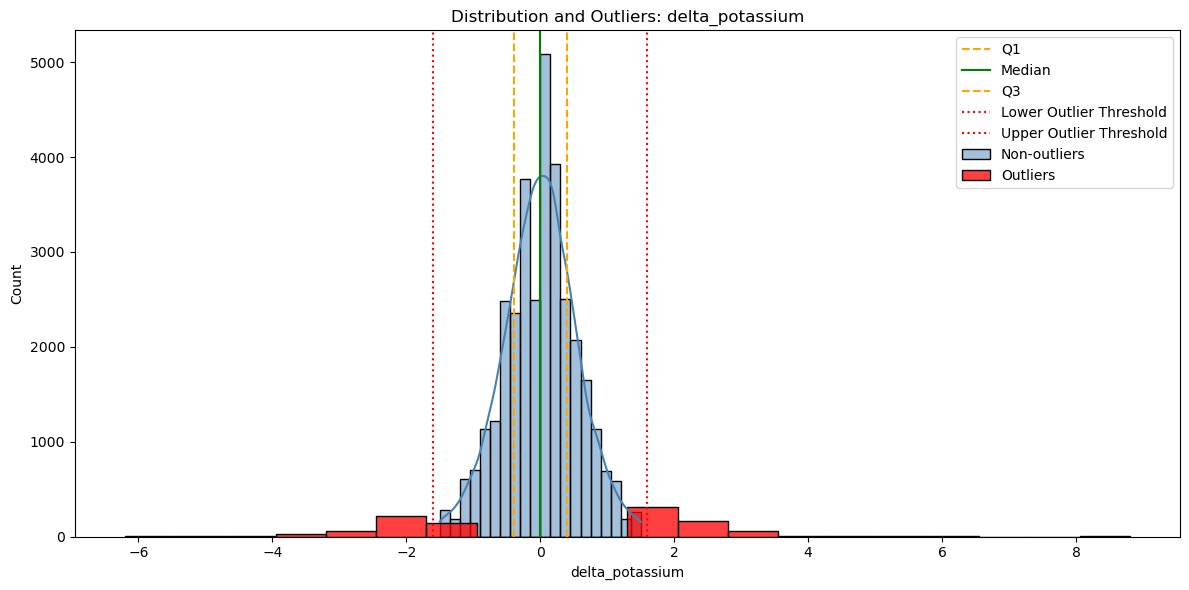

----- delta_potassium -----
Q1: -0.400
Median: 0.000
Q3: 0.400
IQR: 0.800
Lower bound: -1.600
Upper bound: 1.600
Outliers detected: 1011

--- Plotting delta_magnesium ---


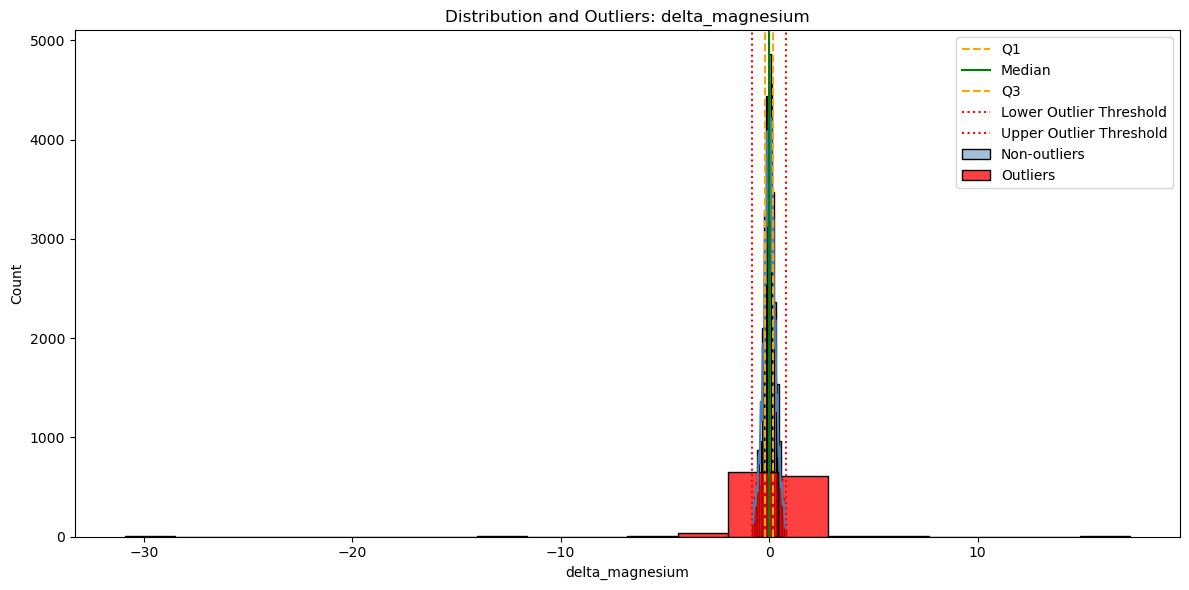

----- delta_magnesium -----
Q1: -0.200
Median: 0.000
Q3: 0.200
IQR: 0.400
Lower bound: -0.800
Upper bound: 0.800
Outliers detected: 1302

--- Plotting delta_calcium ---


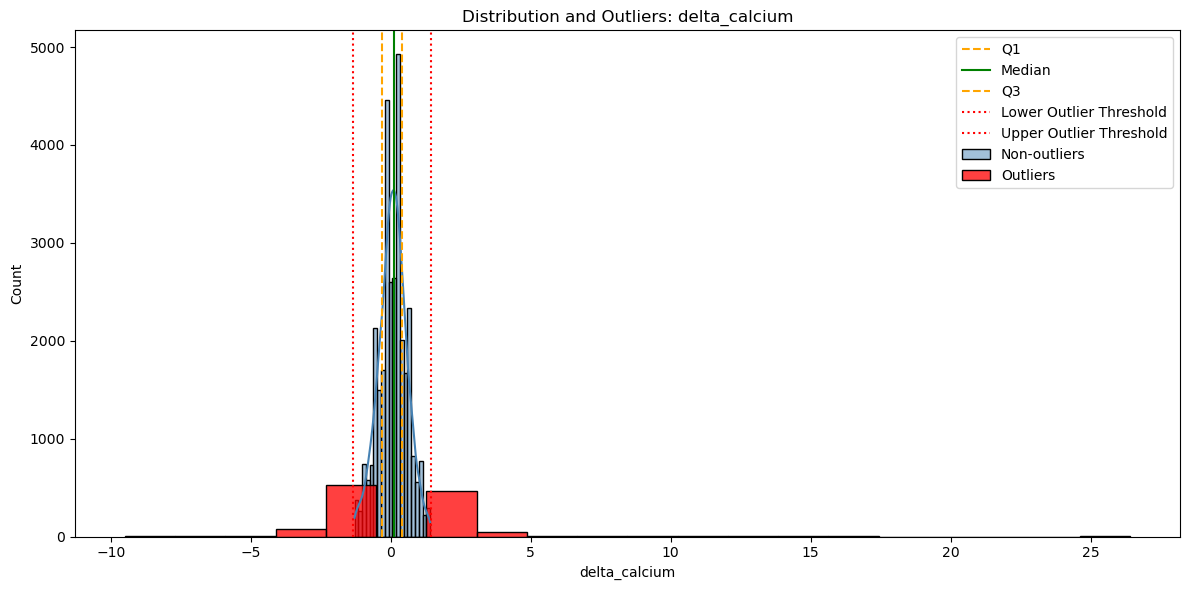

----- delta_calcium -----
Q1: -0.300
Median: 0.100
Q3: 0.400
IQR: 0.700
Lower bound: -1.350
Upper bound: 1.450
Outliers detected: 1142

--- Plotting delta_wbc ---


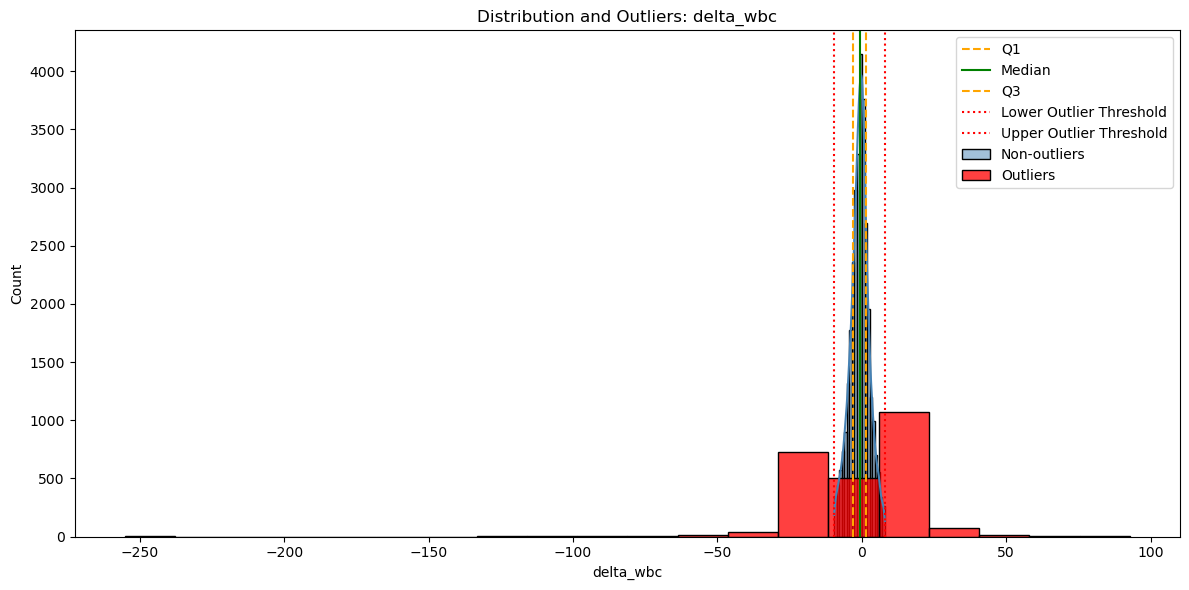

----- delta_wbc -----
Q1: -3.000
Median: -0.700
Q3: 1.400
IQR: 4.400
Lower bound: -9.600
Upper bound: 8.000
Outliers detected: 2462

--- Plotting delta_hemoglobin ---


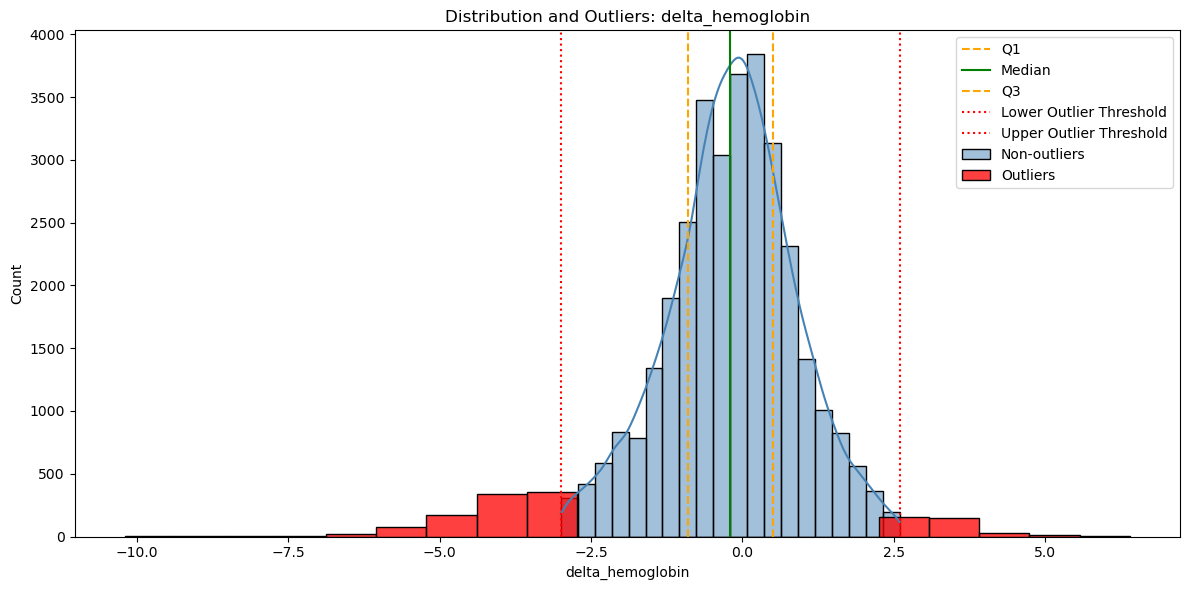

----- delta_hemoglobin -----
Q1: -0.900
Median: -0.200
Q3: 0.500
IQR: 1.400
Lower bound: -3.000
Upper bound: 2.600
Outliers detected: 1320

--- Plotting delta_platelets ---


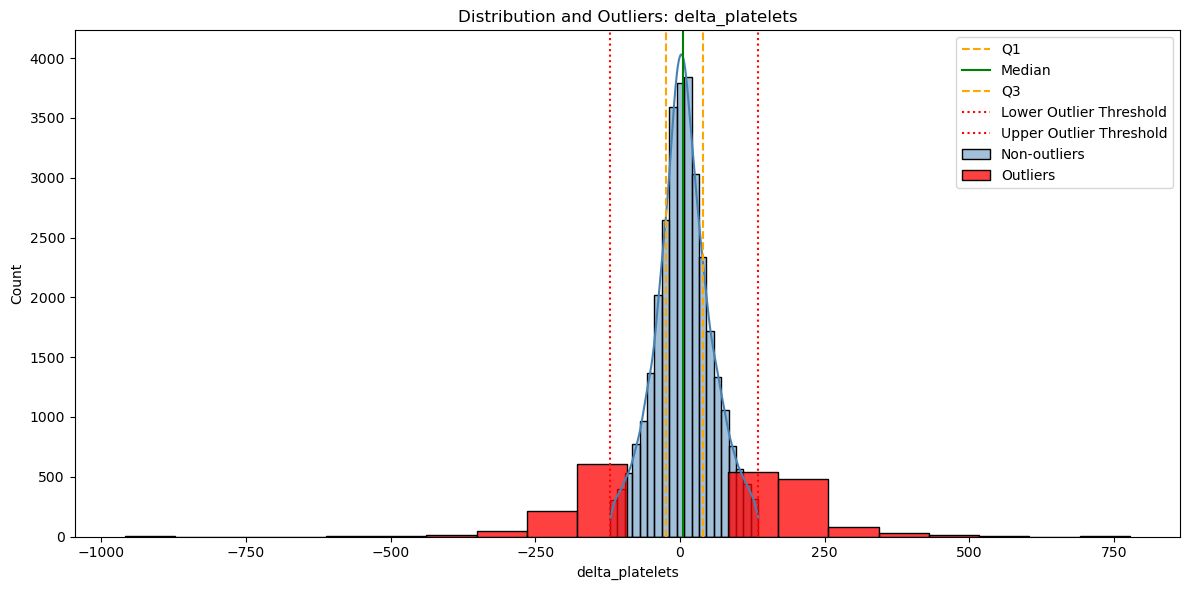

----- delta_platelets -----
Q1: -25.000
Median: 5.000
Q3: 39.000
IQR: 64.000
Lower bound: -121.000
Upper bound: 135.000
Outliers detected: 2031

--- Plotting delta_bilirubin ---


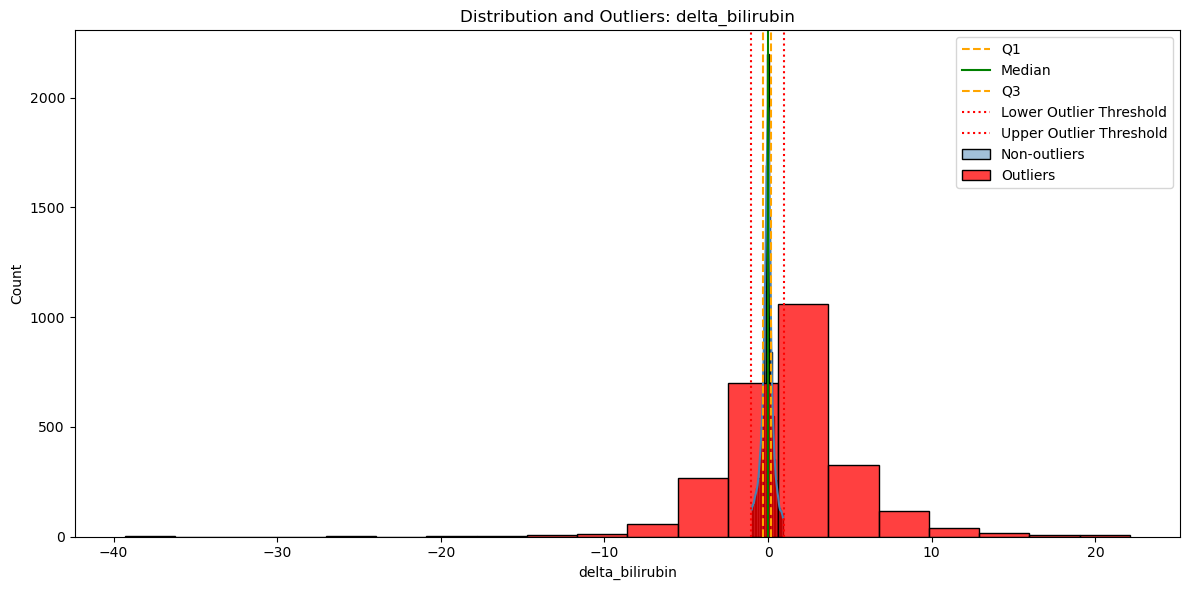

----- delta_bilirubin -----
Q1: -0.300
Median: 0.000
Q3: 0.200
IQR: 0.500
Lower bound: -1.050
Upper bound: 0.950
Outliers detected: 2624

--- Plotting delta_inr ---


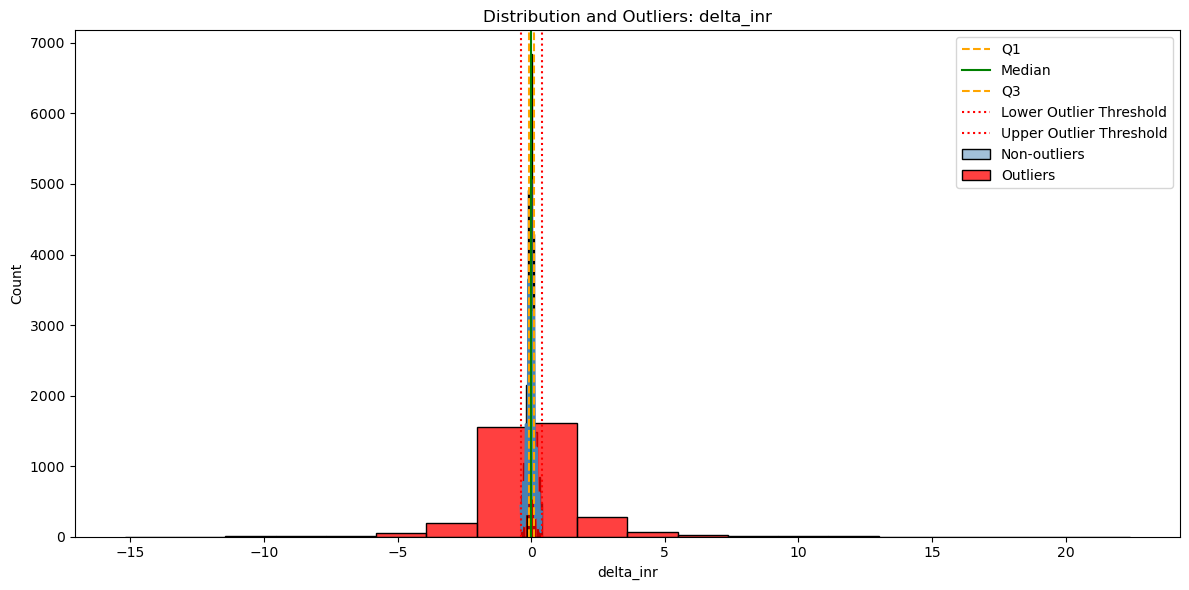

----- delta_inr -----
Q1: -0.100
Median: 0.000
Q3: 0.100
IQR: 0.200
Lower bound: -0.400
Upper bound: 0.400
Outliers detected: 3805

--- Plotting delta_pao2 ---


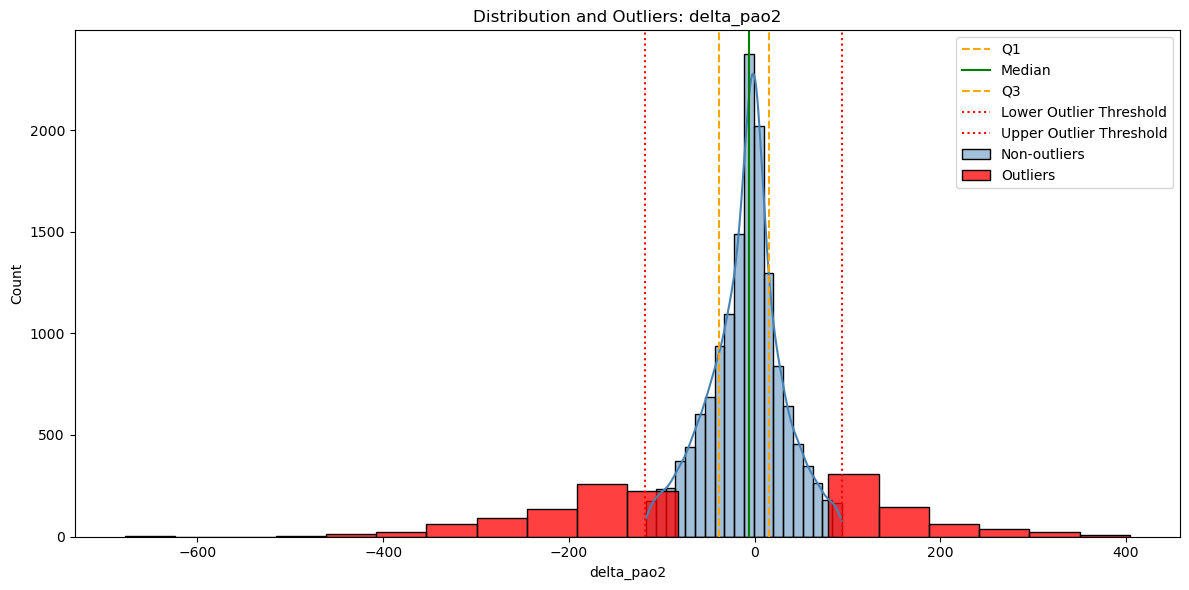

----- delta_pao2 -----
Q1: -38.000
Median: -6.000
Q3: 15.000
IQR: 53.000
Lower bound: -117.500
Upper bound: 94.500
Outliers detected: 1396

--- Plotting delta_hr ---


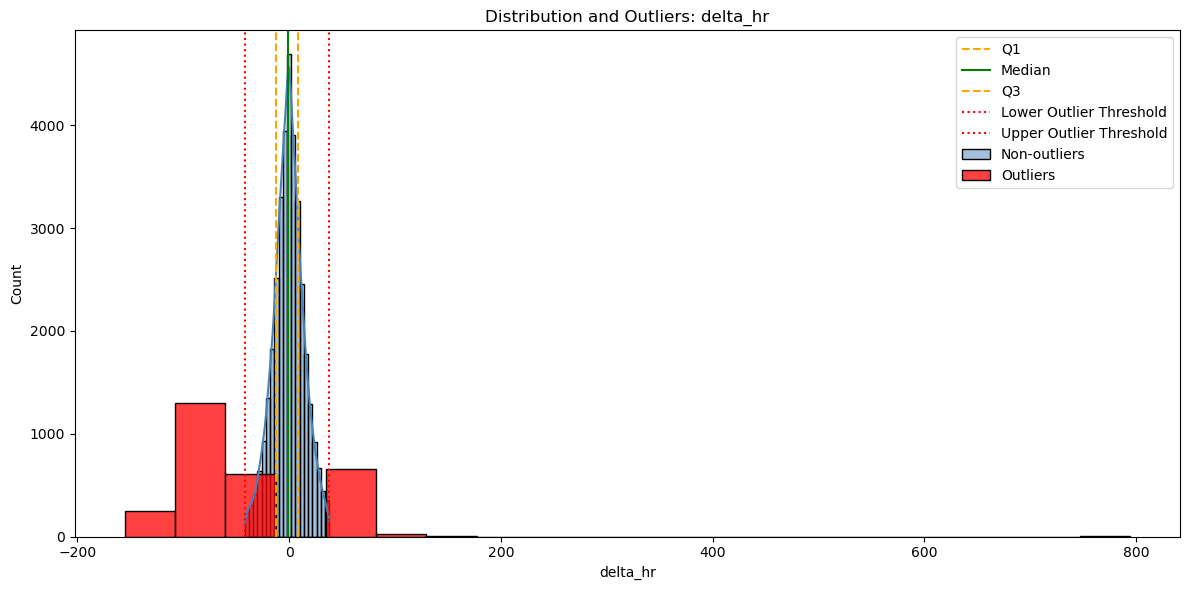

----- delta_hr -----
Q1: -12.000
Median: -1.000
Q3: 8.000
IQR: 20.000
Lower bound: -42.000
Upper bound: 38.000
Outliers detected: 2834

--- Plotting delta_rr ---


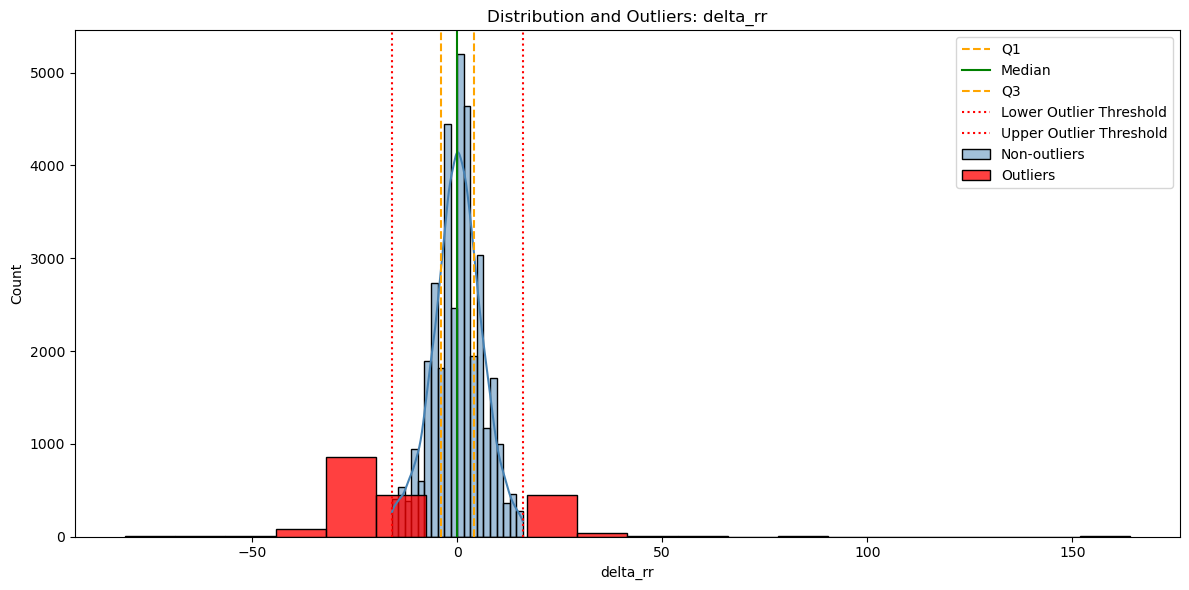

----- delta_rr -----
Q1: -4.000
Median: 0.000
Q3: 4.000
IQR: 8.000
Lower bound: -16.000
Upper bound: 16.000
Outliers detected: 1899

--- Plotting delta_map ---


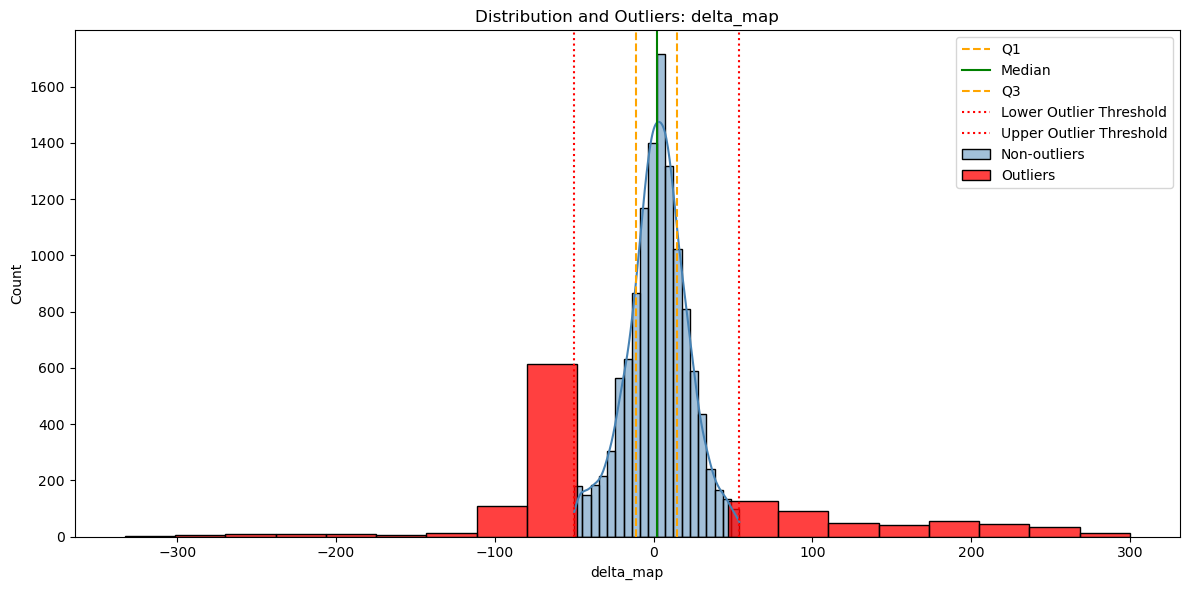

----- delta_map -----
Q1: -11.000
Median: 2.000
Q3: 15.000
IQR: 26.000
Lower bound: -50.000
Upper bound: 54.000
Outliers detected: 1227

--- Plotting delta_spo2 ---


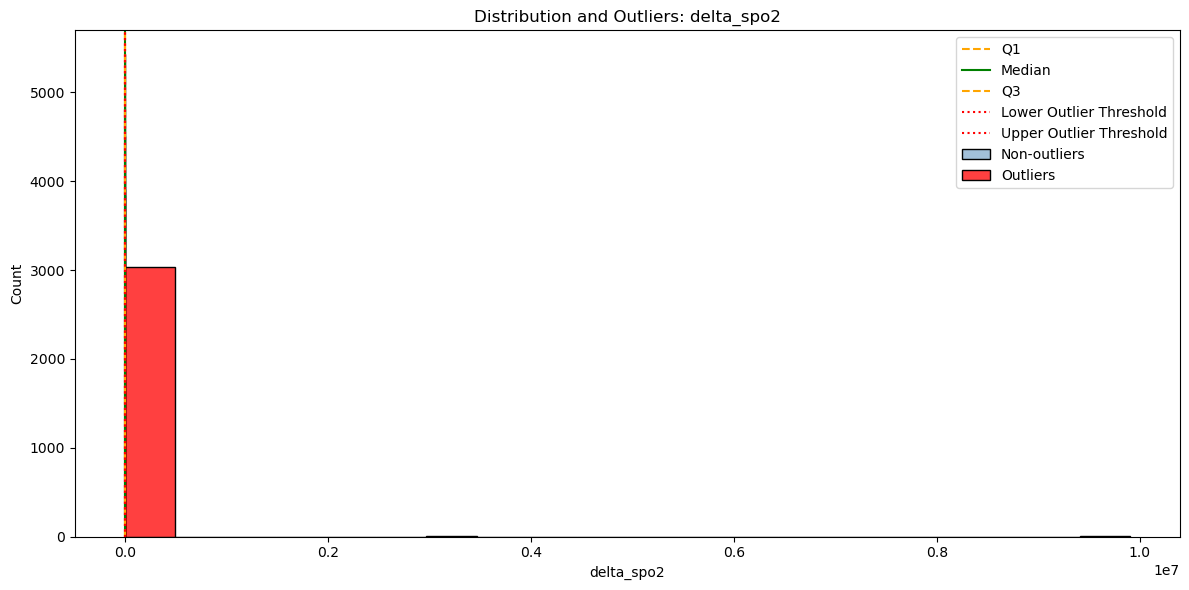

----- delta_spo2 -----
Q1: -3.000
Median: -1.000
Q3: 1.000
IQR: 4.000
Lower bound: -9.000
Upper bound: 7.000
Outliers detected: 3038

--- Plotting delta_fio2 ---


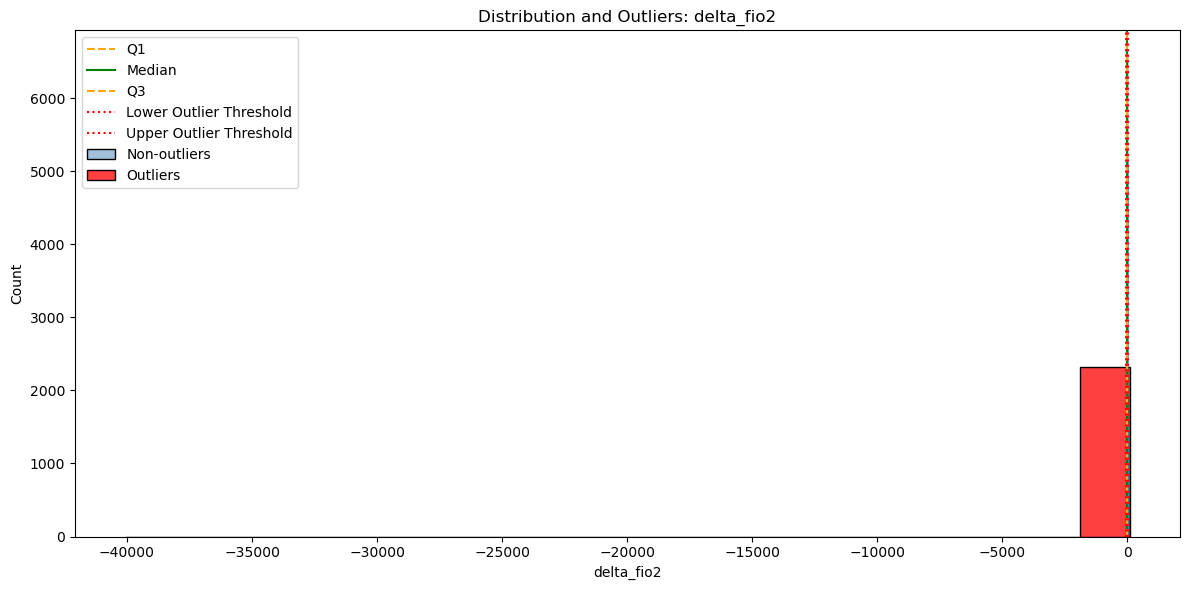

----- delta_fio2 -----
Q1: -10.000
Median: 0.000
Q3: 5.000
IQR: 15.000
Lower bound: -32.500
Upper bound: 27.500
Outliers detected: 2324

--- Plotting delta_temp ---


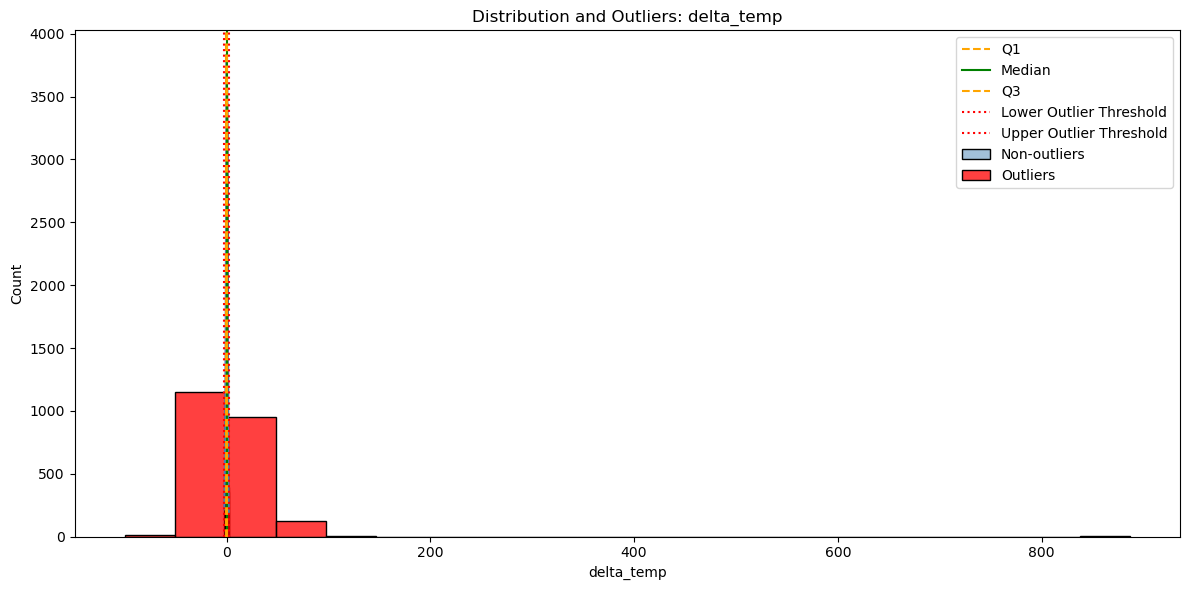

----- delta_temp -----
Q1: -0.600
Median: -0.045
Q3: 0.500
IQR: 1.100
Lower bound: -2.250
Upper bound: 2.150
Outliers detected: 2249

--- Plotting los_days ---


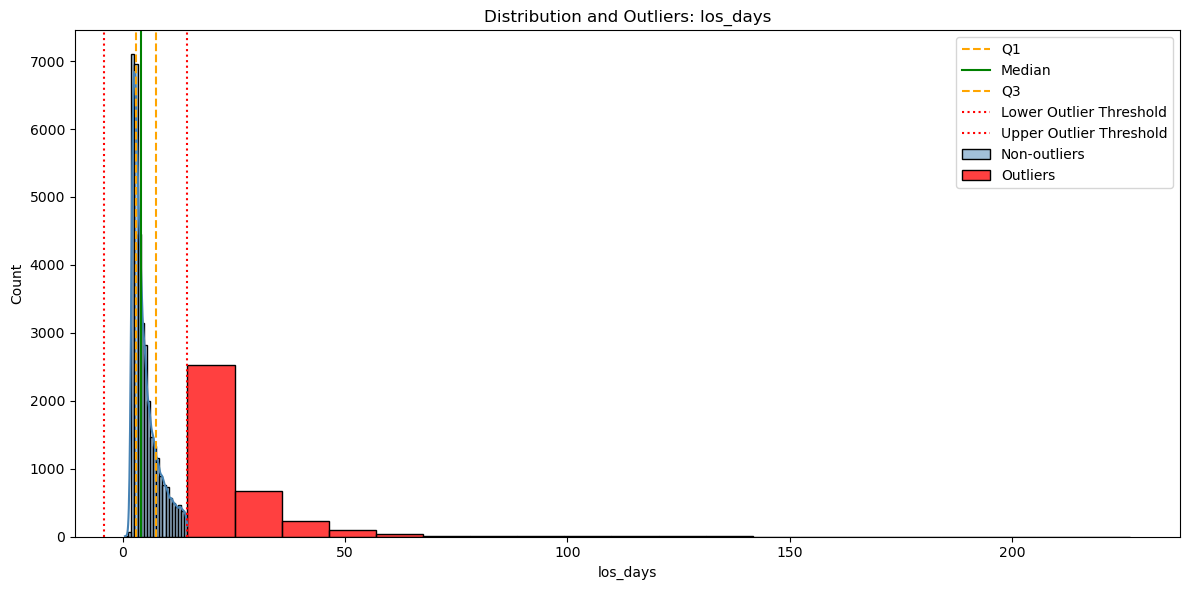

----- los_days -----
Q1: 2.922
Median: 4.220
Q3: 7.590
IQR: 4.667
Lower bound: -4.078
Upper bound: 14.590
Outliers detected: 3596

--- Plotting vent_days ---


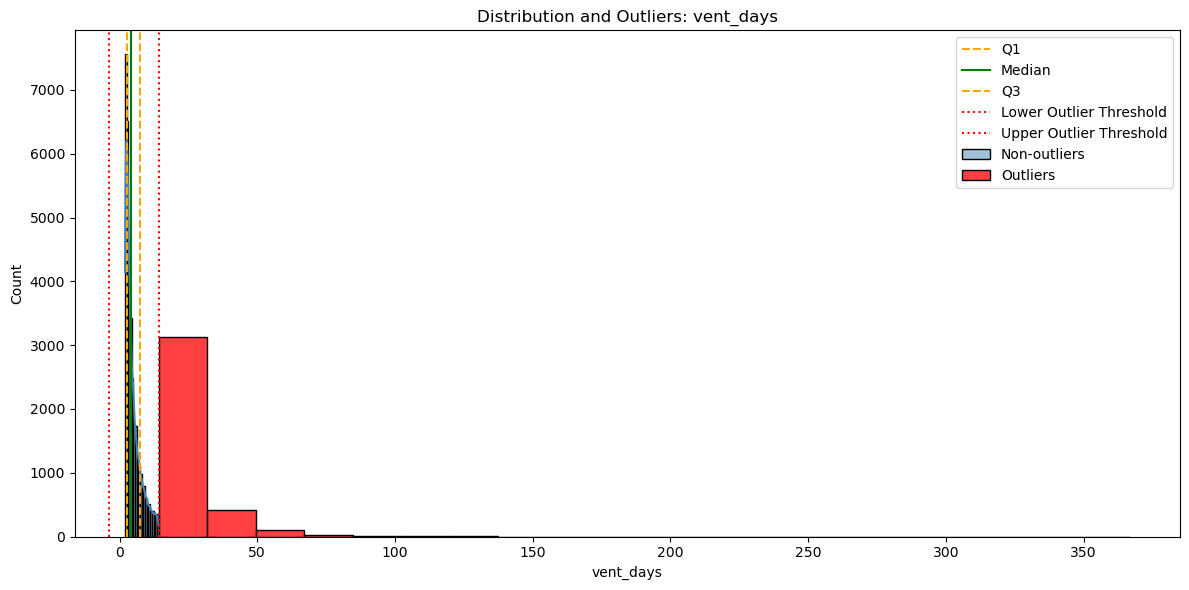

----- vent_days -----
Q1: 2.829
Median: 4.077
Q3: 7.369
IQR: 4.540
Lower bound: -3.981
Upper bound: 14.179
Outliers detected: 3694


In [41]:
# explore outliers in continuous variables
continuous_vars = [ 
    "age", "spo2", "fio2", "map", "temp", "gcs", "pao2", "pfratio", 
    "lactate_lab", "creatinine_lab", "bun_lab", "bicarb_lab",
    "sodium_lab", "potassium_lab", "magnesium_lab", "calcium_lab",
    "wbc_lab", "hemoglobin_lab", "platelets_lab", "bilirubin_lab",
    "inr_lab", "pao2_lab",

    "delta_bun", "delta_bicarb", "delta_sodium", "delta_potassium",
    "delta_magnesium", "delta_calcium", "delta_wbc", "delta_hemoglobin",
    "delta_platelets", "delta_bilirubin", "delta_inr", "delta_pao2",
    "delta_hr", "delta_rr", "delta_map", "delta_spo2", "delta_fio2",
    "delta_temp",

    "los_days", "vent_days"
]

for var in continuous_vars:
    print(f"\n--- Plotting {var} ---")
    plot_variable_with_outliers(df_clean, variable=var)

Après la visualisation de ces graphiques, nous pouvons voir que la plupart des variables contiennent des valeurs extrêmes, mais qui sont encore dans les limites des possibilités physiologiques. Les exceptions sont les variables suivantes:
- température
- ratio p/f
- delta spo2
- delta température

Pour ces variables nous avons remplacé les valeurs physiologiquement impossibles par des NaN avec la fonction suivante.
Pour le reste des variables avec les valeurs extrêmes, nous devrions tenir compte de leur impact sur la standardisation requise pour nos modèles prédictifs. Notamment, nous utiliserons l'outil `Robust_Scaler` pour la régression logistique, et le modèle `Random_Forest`, qui est capable de gérer les valeurs extrêmes. 

In [42]:
df_clean = remove_nonphysiologic_values(df_clean)

In spo2: Removed 3 non-physiologic values (39121 → 39118)
In fio2: No non-physiologic values removed.
In map: Removed 919 non-physiologic values (15990 → 15071)
In temp: Removed 38696 non-physiologic values (39009 → 313)
In gcs: No non-physiologic values removed.
In pao2: Removed 38 non-physiologic values (22944 → 22906)
In pfratio: Removed 750 non-physiologic values (17986 → 17236)
In lactate_lab: No non-physiologic values removed.
In creatinine_lab: Removed 1 non-physiologic values (38768 → 38767)
In bun_lab: Removed 22 non-physiologic values (38771 → 38749)
In bicarb_lab: No non-physiologic values removed.
In sodium_lab: No non-physiologic values removed.
In potassium_lab: Removed 25 non-physiologic values (38794 → 38769)
In magnesium_lab: Removed 27 non-physiologic values (38742 → 38715)
In calcium_lab: Removed 7 non-physiologic values (38580 → 38573)
In wbc_lab: Removed 6 non-physiologic values (38724 → 38718)
In hemoglobin_lab: No non-physiologic values removed.
In platelets_lab:

# Traitement des données manquantes
<br>
Tel que visualisé précédemment, les données manquantes ont une signification clinique ici: les patients pour lesquels l'équipe médicale fait moins de signes vitaux et moins de prises de sang sont généralement plus stables. Ce pattern peut à son tour devenir prédicteur pour la réadmission du patient ou non. <br>
Les variables avec le plus de valeurs manquantes sont:
- 

La fonction ci-dessous fait une imputation par MICE (Multivariate Imputation by Chained Equation) des valeurs manquantes, et crée une colonne `{variable}_missing` qui indique la présence ou non de valeurs manquantes pour cette variable pour chaque entrée.

In [43]:
X_train, X_val, X_test, imputer = mice_impute_splits(X_train, X_val, X_test)

# 4. Modèles prédictifs

In [44]:
# one-hot encoding pour les variables catégorielles
X_train, X_val, X_test = encode_categorical_variables(
    X_train=X_train,
    X_val=X_val,
    X_test=X_test,
    drop_first=True
)

Categorical columns detected: ['insurance', 'race', 'gender']


## 4.1 Régression logistique

In [ ]:
def train_logistic_regression(X_train, y_train):
    """
    Train a Logistic Regression model assuming categorical encoding
    has already been performed upstream.

    Only numeric features are scaled via RobustScaler.
    """

    # Identify numeric columns only
    numeric_cols = X_train.select_dtypes(include=["float", "int"]).columns

    # Preprocessor ONLY scales numeric features
    # robustscaler pour les variables continues
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", RobustScaler(), numeric_cols),
        ],
        remainder="passthrough"   # Keep already-encoded categorical columns
    )

    # Full pipeline
    model = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("logreg", LogisticRegression(
                max_iter=5000,
                solver="lbfgs",
                n_jobs=-1
            ))
        ]
    )

    # Fit model
    model.fit(X_train, y_train)

    return model

In [ ]:
# entraîne le modèle de régression logistique
model_LR = train_logistic_regression(X_train, y_train)

/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 5000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=5000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [47]:
# prédit les outcomes sur le dataset de validation
y_pred_LR = model_LR.predict(X_val)

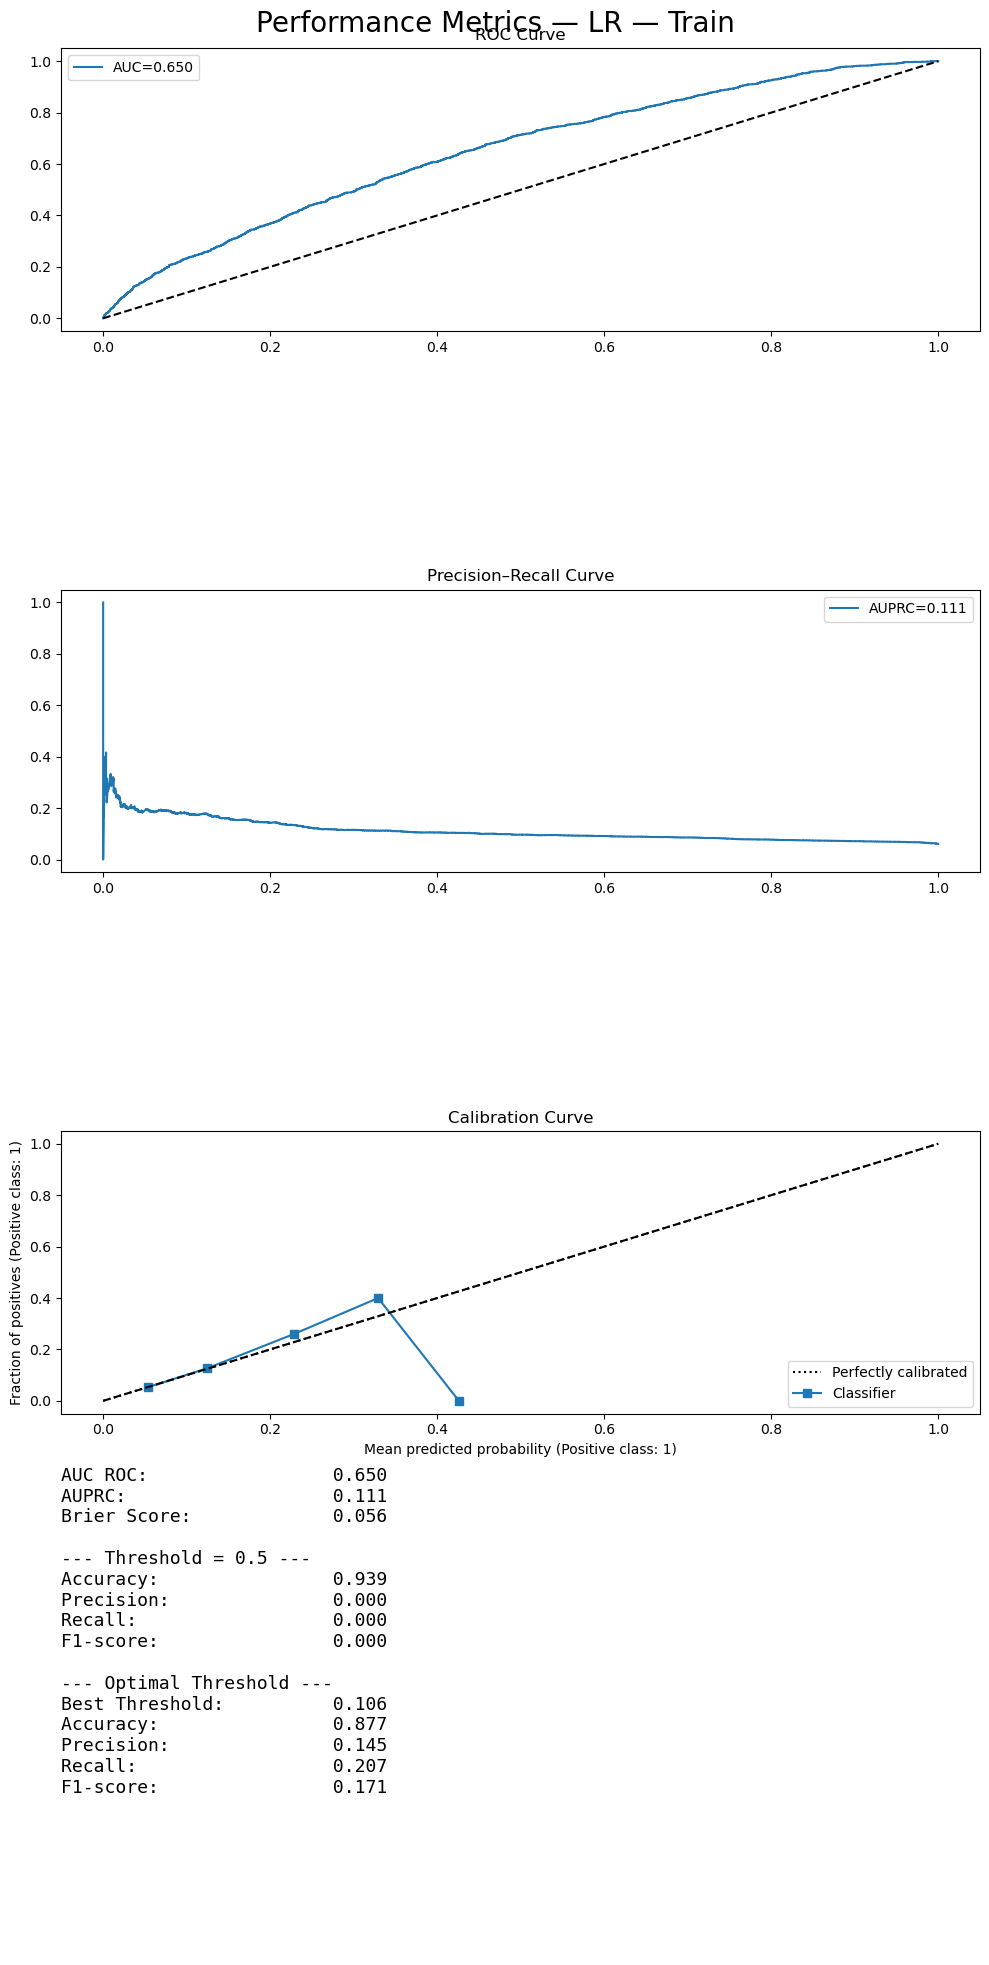

In [48]:
fig_train = plot_model_metrics(model_LR, X_train, y_train, model_name="LR — Train")

In [49]:
print(model_LR)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  Index(['age', 'spo2', 'fio2', 'temp', 'map', 'gcs', 'pao2', 'pfratio',
       'vent_last48', 'pressor_last48', 'extubation_last48', 'crrt_last48',
       'lactate_lab', 'creatinine_lab', 'bun_lab', 'bicarb_lab', 'sodium_lab',
       'potassium_lab', 'magnesium_lab', 'calcium_lab', '...
       'delta_calcium_missing', 'delta_wbc_missing',
       'delta_hemoglobin_missing', 'delta_platelets_missing',
       'delta_bilirubin_missing', 'delta_inr_missing', 'delta_pao2_missing',
       'delta_hr_missing', 'delta_rr_missing', 'delta_map_missing',
       'delta_spo2_missing', 'delta_fio2_missing', 'delta_temp_missing',
       'los_days_missing'],
      dtype='object'))])),
                ('logreg', LogisticRegression(max_iter=5000, n_jobs=-1))])


## Tuning des hyperparamètres et sélection de caractéristiques

In [85]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
from feature_selection import *
from models import *
from sklearn.linear_model import LogisticRegression

In [87]:
results_lr, best_lr_model, best_lr_params = cross_val_evaluation(
    model_class=LogisticRegression,
    X=X_train,
    y=y_train,
    param_grid=None,     
    scoring="f1",
    n_repeats=3,
    n_folds=5
)


Repeat 1/3

--- Fold 1/5 ---
Using built-in Logistic Regression hyperparameter search space.


/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/py


Best LogisticRegression Model
Best scoring metric (f1): 0.0598

Best hyperparameters:
  solver: saga
  penalty: elasticnet
  l1_ratio: 0.75
  C: 1

--- Fold 2/5 ---
Using built-in Logistic Regression hyperparameter search space.


/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/py


Best LogisticRegression Model
Best scoring metric (f1): 0.0000

Best hyperparameters:
  solver: saga
  penalty: elasticnet
  l1_ratio: 0.5
  C: 1

--- Fold 3/5 ---
Using built-in Logistic Regression hyperparameter search space.


/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/py


Best LogisticRegression Model
Best scoring metric (f1): 0.0585

Best hyperparameters:
  solver: saga
  penalty: elasticnet
  l1_ratio: 0.5
  C: 1

--- Fold 4/5 ---
Using built-in Logistic Regression hyperparameter search space.


/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/py


Best LogisticRegression Model
Best scoring metric (f1): 0.0550

Best hyperparameters:
  solver: saga
  penalty: elasticnet
  l1_ratio: 0.5
  C: 1

--- Fold 5/5 ---
Using built-in Logistic Regression hyperparameter search space.


/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/py


Best LogisticRegression Model
Best scoring metric (f1): 0.0566

Best hyperparameters:
  solver: saga
  penalty: elasticnet
  l1_ratio: 0.5
  C: 1

Repeat 2/3

--- Fold 1/5 ---
Using built-in Logistic Regression hyperparameter search space.


/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/py


Best LogisticRegression Model
Best scoring metric (f1): 0.0640

Best hyperparameters:
  solver: saga
  penalty: elasticnet
  l1_ratio: 0.5
  C: 1

--- Fold 2/5 ---
Using built-in Logistic Regression hyperparameter search space.


/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/py


Best LogisticRegression Model
Best scoring metric (f1): 0.0571

Best hyperparameters:
  solver: saga
  penalty: elasticnet
  l1_ratio: 0.5
  C: 1

--- Fold 3/5 ---
Using built-in Logistic Regression hyperparameter search space.


/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/py


Best LogisticRegression Model
Best scoring metric (f1): 0.0656

Best hyperparameters:
  solver: saga
  penalty: elasticnet
  l1_ratio: 0.5
  C: 1

--- Fold 4/5 ---
Using built-in Logistic Regression hyperparameter search space.


/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/py


Best LogisticRegression Model
Best scoring metric (f1): 0.0000

Best hyperparameters:
  solver: saga
  penalty: elasticnet
  l1_ratio: 0.5
  C: 1

--- Fold 5/5 ---
Using built-in Logistic Regression hyperparameter search space.


/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/py


Best LogisticRegression Model
Best scoring metric (f1): 0.0549

Best hyperparameters:
  solver: saga
  penalty: elasticnet
  l1_ratio: 0.5
  C: 1

Repeat 3/3

--- Fold 1/5 ---
Using built-in Logistic Regression hyperparameter search space.


/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/py


Best LogisticRegression Model
Best scoring metric (f1): 0.0536

Best hyperparameters:
  solver: saga
  penalty: elasticnet
  l1_ratio: 0.25
  C: 0.1

--- Fold 2/5 ---
Using built-in Logistic Regression hyperparameter search space.


/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/py


Best LogisticRegression Model
Best scoring metric (f1): 0.0000

Best hyperparameters:
  solver: saga
  penalty: elasticnet
  l1_ratio: 0.5
  C: 1

--- Fold 3/5 ---
Using built-in Logistic Regression hyperparameter search space.


/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/py


Best LogisticRegression Model
Best scoring metric (f1): 0.0621

Best hyperparameters:
  solver: saga
  penalty: elasticnet
  l1_ratio: 0.5
  C: 1

--- Fold 4/5 ---
Using built-in Logistic Regression hyperparameter search space.


/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/py


Best LogisticRegression Model
Best scoring metric (f1): 0.0674

Best hyperparameters:
  solver: saga
  penalty: elasticnet
  l1_ratio: 0.5
  C: 0.1

--- Fold 5/5 ---
Using built-in Logistic Regression hyperparameter search space.


/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/py


Best LogisticRegression Model
Best scoring metric (f1): 0.0651

Best hyperparameters:
  solver: saga
  penalty: elasticnet
  l1_ratio: 0.5
  C: 1

 BEST MODEL ACROSS ALL REPEATS
Mean F1 across folds = 0.1195
Best hyperparameters: {'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.5, 'C': 1}


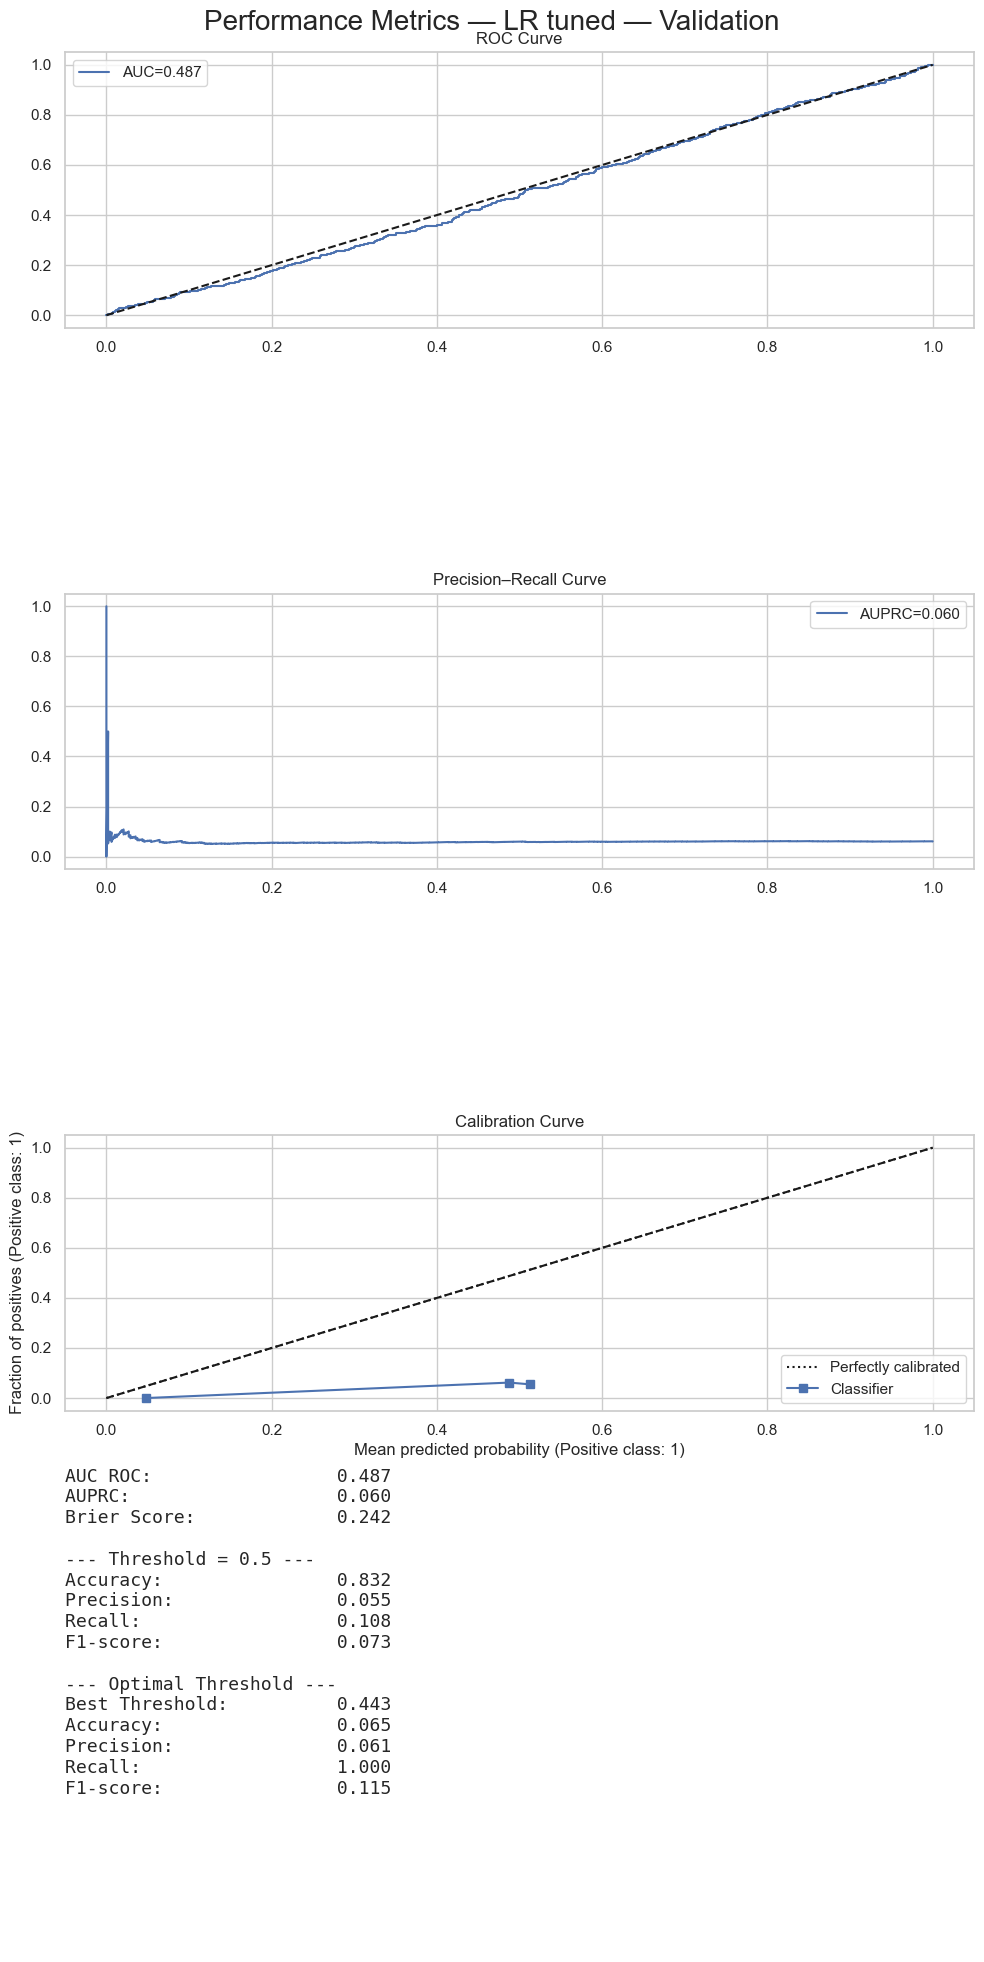

In [88]:
fig_val_LR_tuned = plot_model_metrics(best_lr_model, X_val, y_val, model_name="LR tuned — Validation")


[Statistical FS] Method=mutual_info, k=10
  → Selected features (10): ['vent_last48', 'antibiotics_last72', 'map_missing', 'gcs_missing', 'pfratio_missing', 'bilirubin_lab_missing', 'delta_bilirubin_missing', 'delta_map_missing', 'delta_fio2_missing', 'insurance_Medicare']

[Statistical FS] Method=chi2, k=10
  → Selected features (10): ['spo2', 'map', 'gcs', 'pao2', 'pfratio', 'bun_lab', 'pao2_lab', 'delta_hr', 'delta_map', 'delta_spo2']

[SFS] Direction=forward, k=10
  → Selected features (10): ['fio2', 'extubation_last48', 'wbc_lab', 'delta_hr', 'delta_rr', 'charlson_index', 'bilirubin_lab_missing', 'delta_calcium_missing', 'delta_map_missing', 'race_WHITE - BRAZILIAN']

[Logistic Regularization] Searching over penalties + C (+ l1_ratio for EN)


/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1305: UserWarning: 'n_jo

  → Best params: {'clf__C': np.float64(0.046415888336127795), 'clf__l1_ratio': 0.5, 'clf__penalty': 'elasticnet', 'clf__solver': 'saga'}
  → Best CV AUC: 0.618
  → Validation AUC with best model: 0.624
  → Penalty used: elasticnet
  → Selected features (85): ['fio2', 'pao2', 'vent_last48', 'pressor_last48', 'extubation_last48', 'crrt_last48', 'lactate_lab', 'bun_lab', 'bicarb_lab', 'sodium_lab', 'potassium_lab', 'magnesium_lab', 'calcium_lab', 'wbc_lab', 'hemoglobin_lab', 'platelets_lab', 'pao2_lab', 'delta_bun', 'delta_potassium', 'delta_magnesium', 'delta_hemoglobin', 'delta_platelets', 'delta_inr', 'delta_pao2', 'delta_hr', 'delta_rr', 'delta_temp', 'pressor_last72', 'antibiotics_last72', 'sedatives_last72', 'steroids_last72', 'diuretics_last72', 'night_discharge', 'weekend_discharge', 'charlson_index', 'spo2_missing', 'fio2_missing', 'temp_missing', 'map_missing', 'gcs_missing', 'pao2_missing', 'pfratio_missing', 'lactate_lab_missing', 'bicarb_lab_missing', 'hemoglobin_lab_missing'

/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/ift6758/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


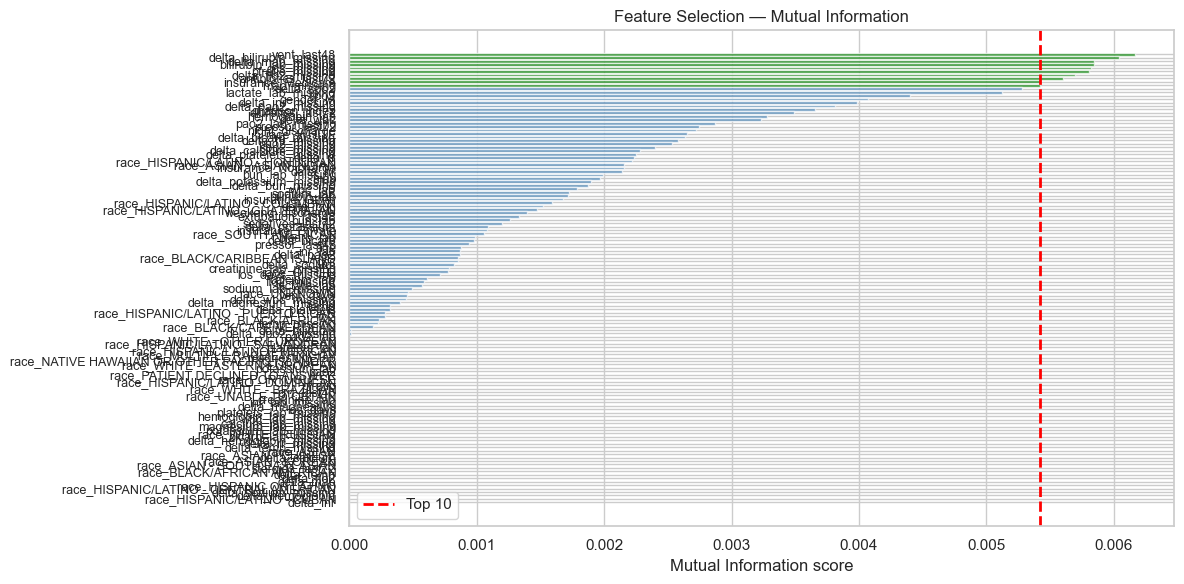

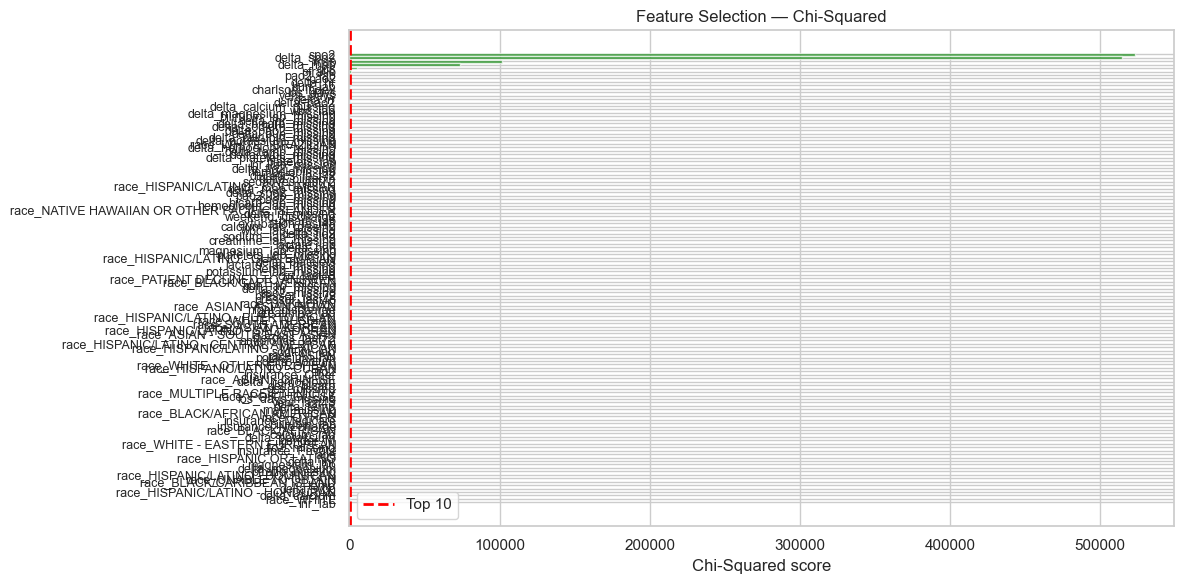

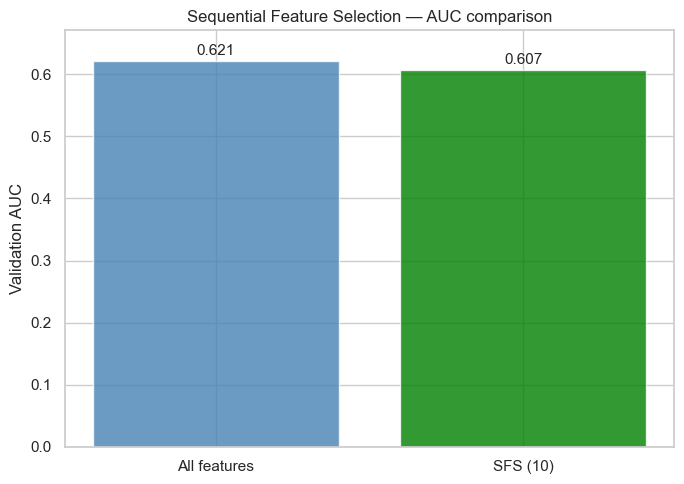

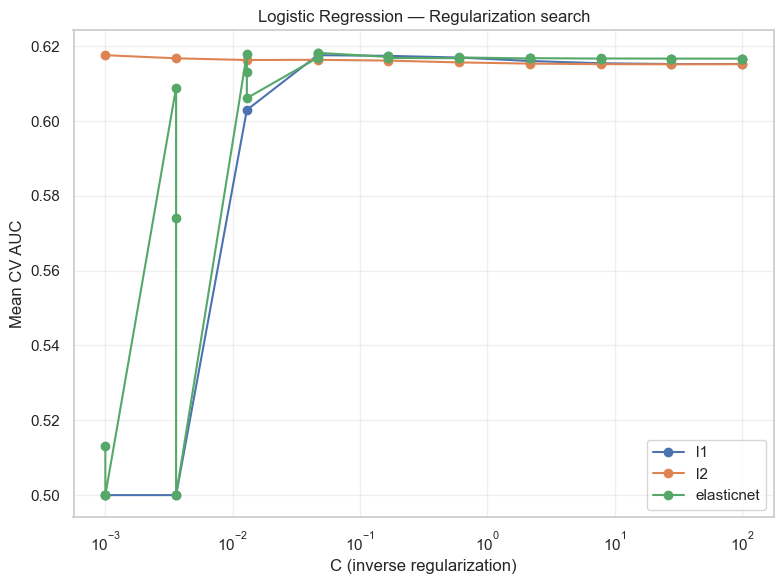

In [89]:
leaderboard_lr, fs_lr, small_lr = run_feature_selection(
    X_train, y_train,
    X_val, y_val,
    tuned_model=best_lr_model,   # your tuned logistic regression
    n_features=10
)

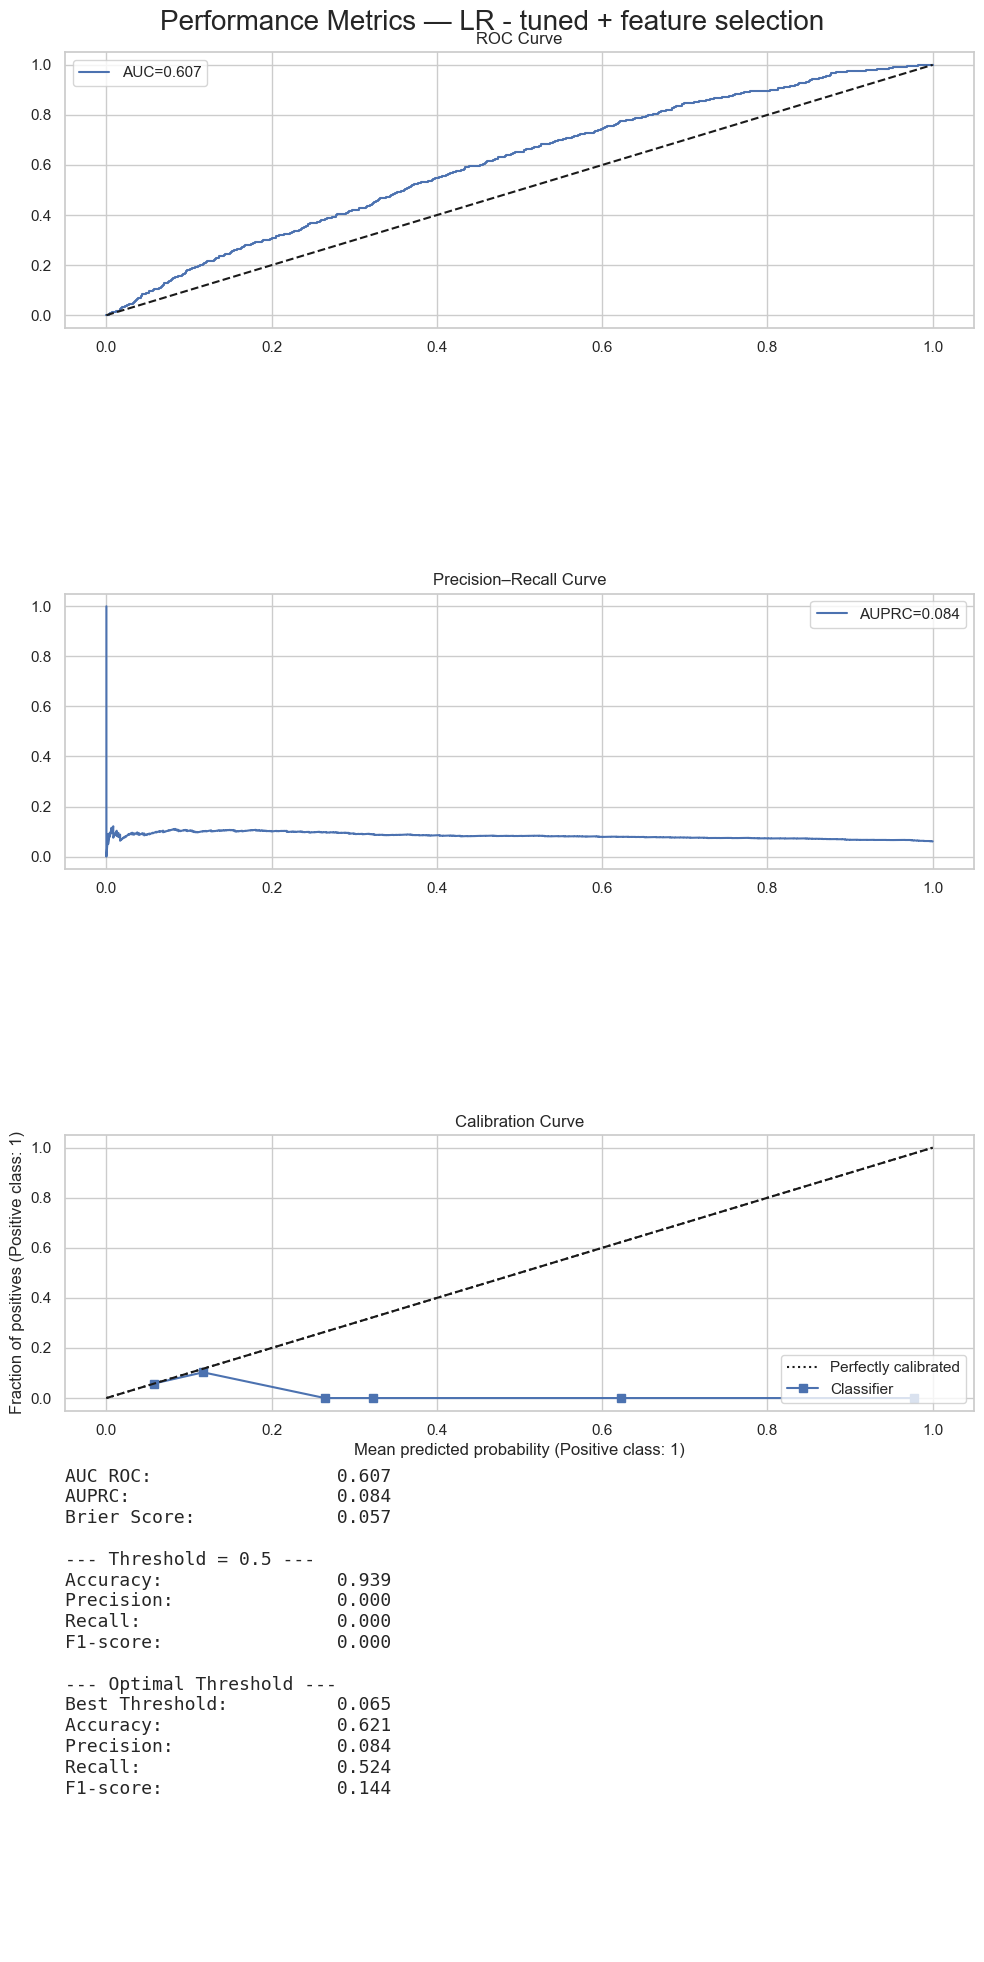

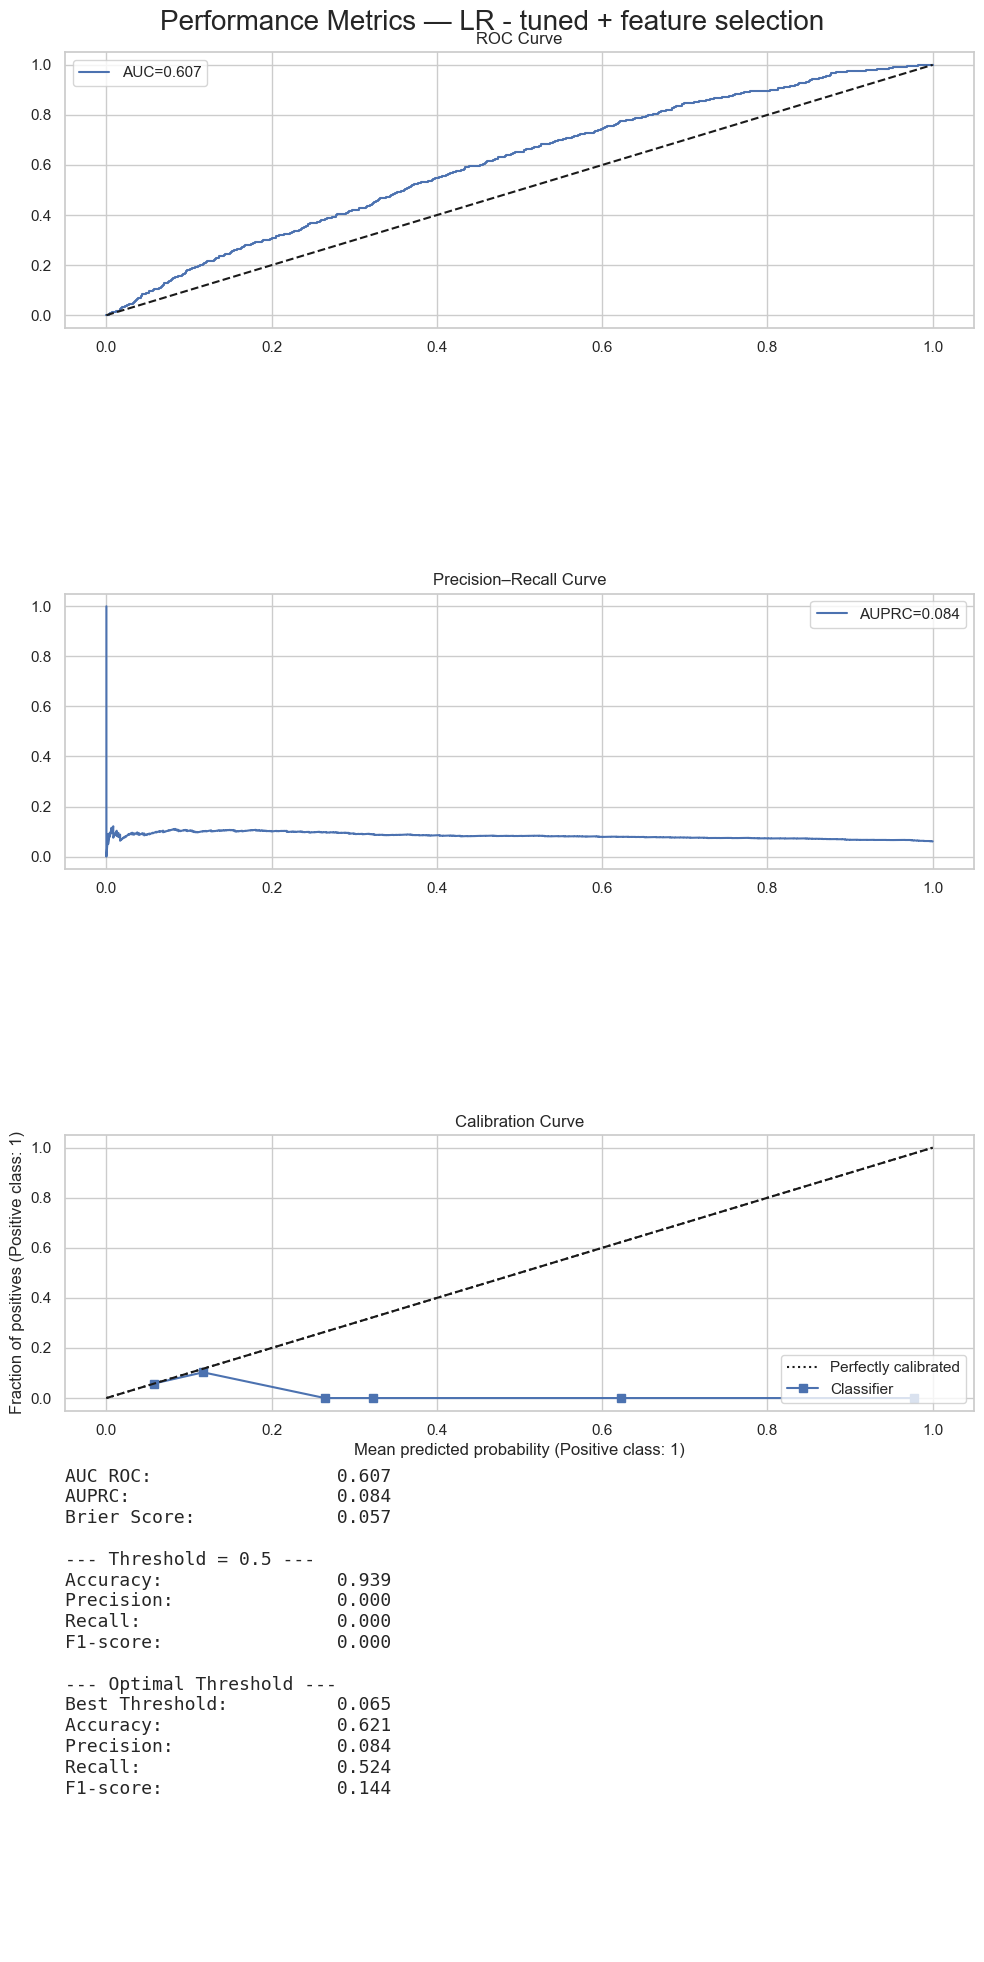

In [90]:
best_feats_lr = leaderboard_lr.iloc[0]["features"]
plot_model_metrics(small_lr, X_val[best_feats_lr], y_val, model_name="LR - tuned + feature selection")

## RandomForest
Arbre décisionnel, robuste aux valeurs extrêmes

In [75]:
model_RF = train_random_forest(X_train, y_train)

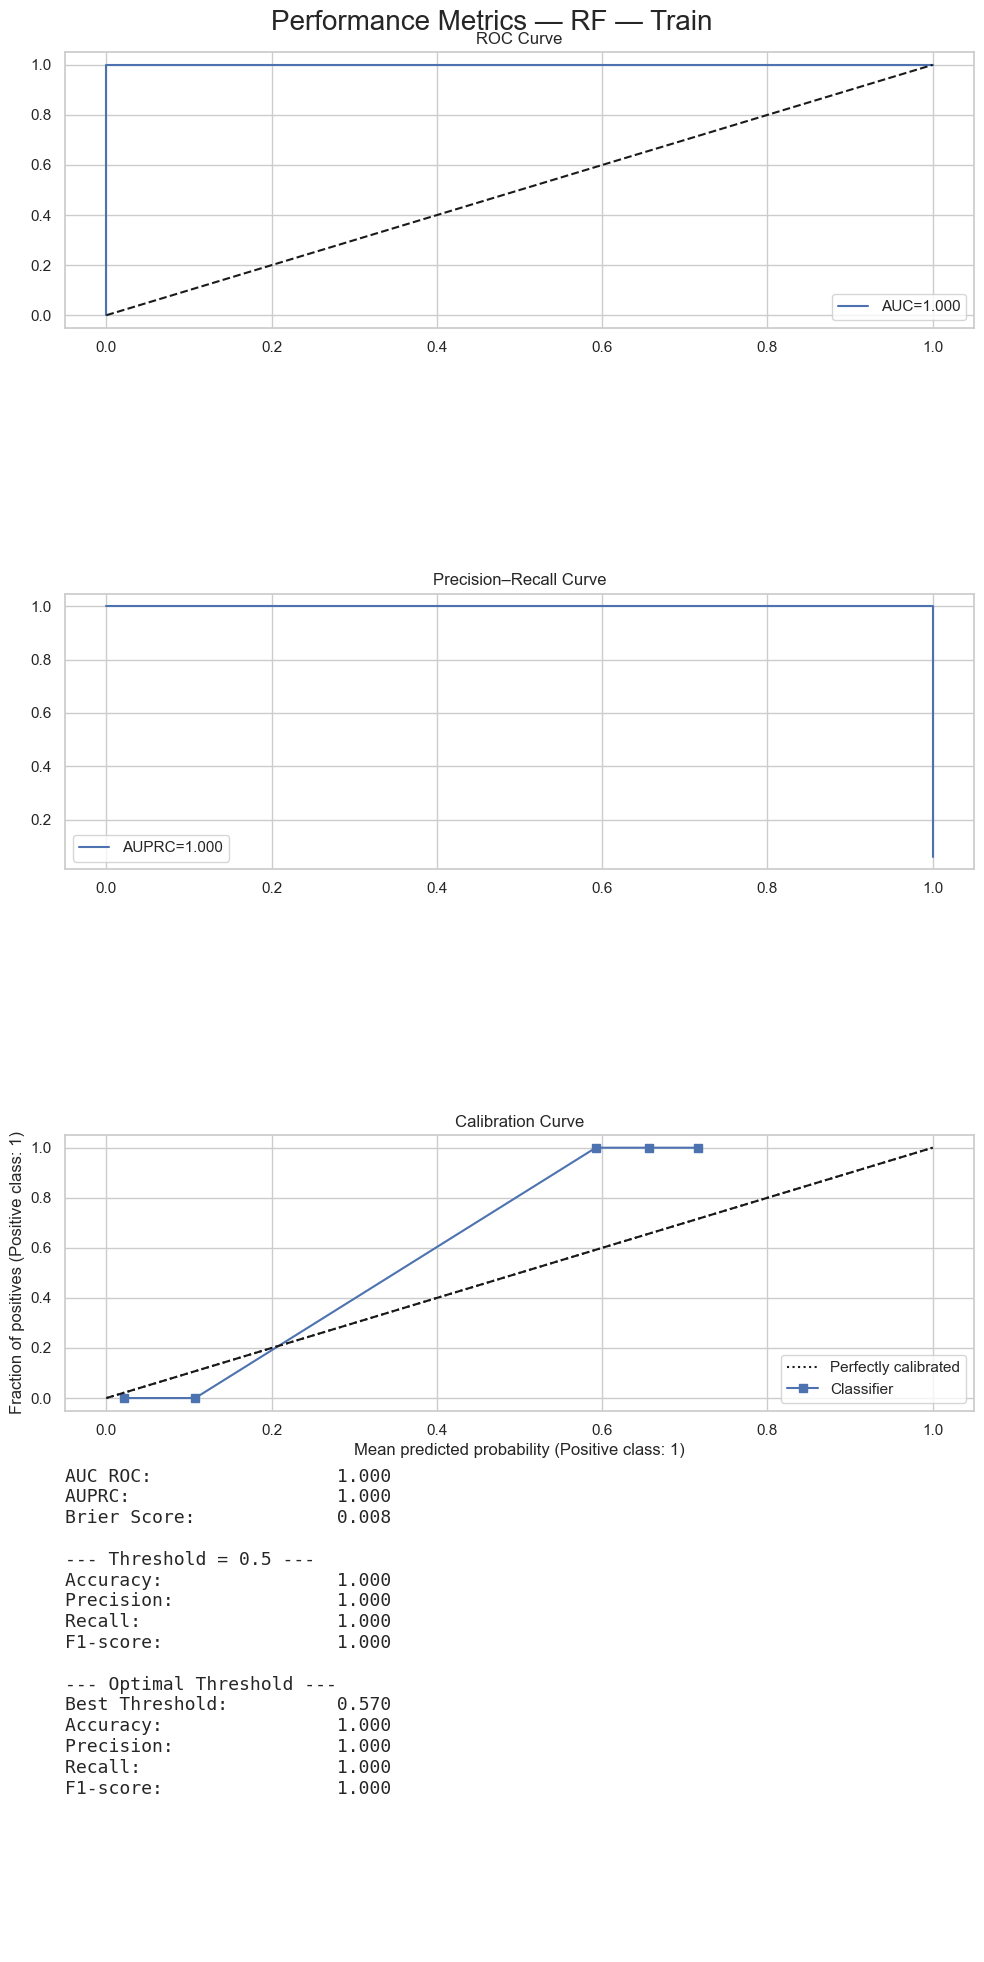

In [76]:
fig_rf_train = plot_model_metrics(model_RF, X_train, y_train, model_name="RF — Train")

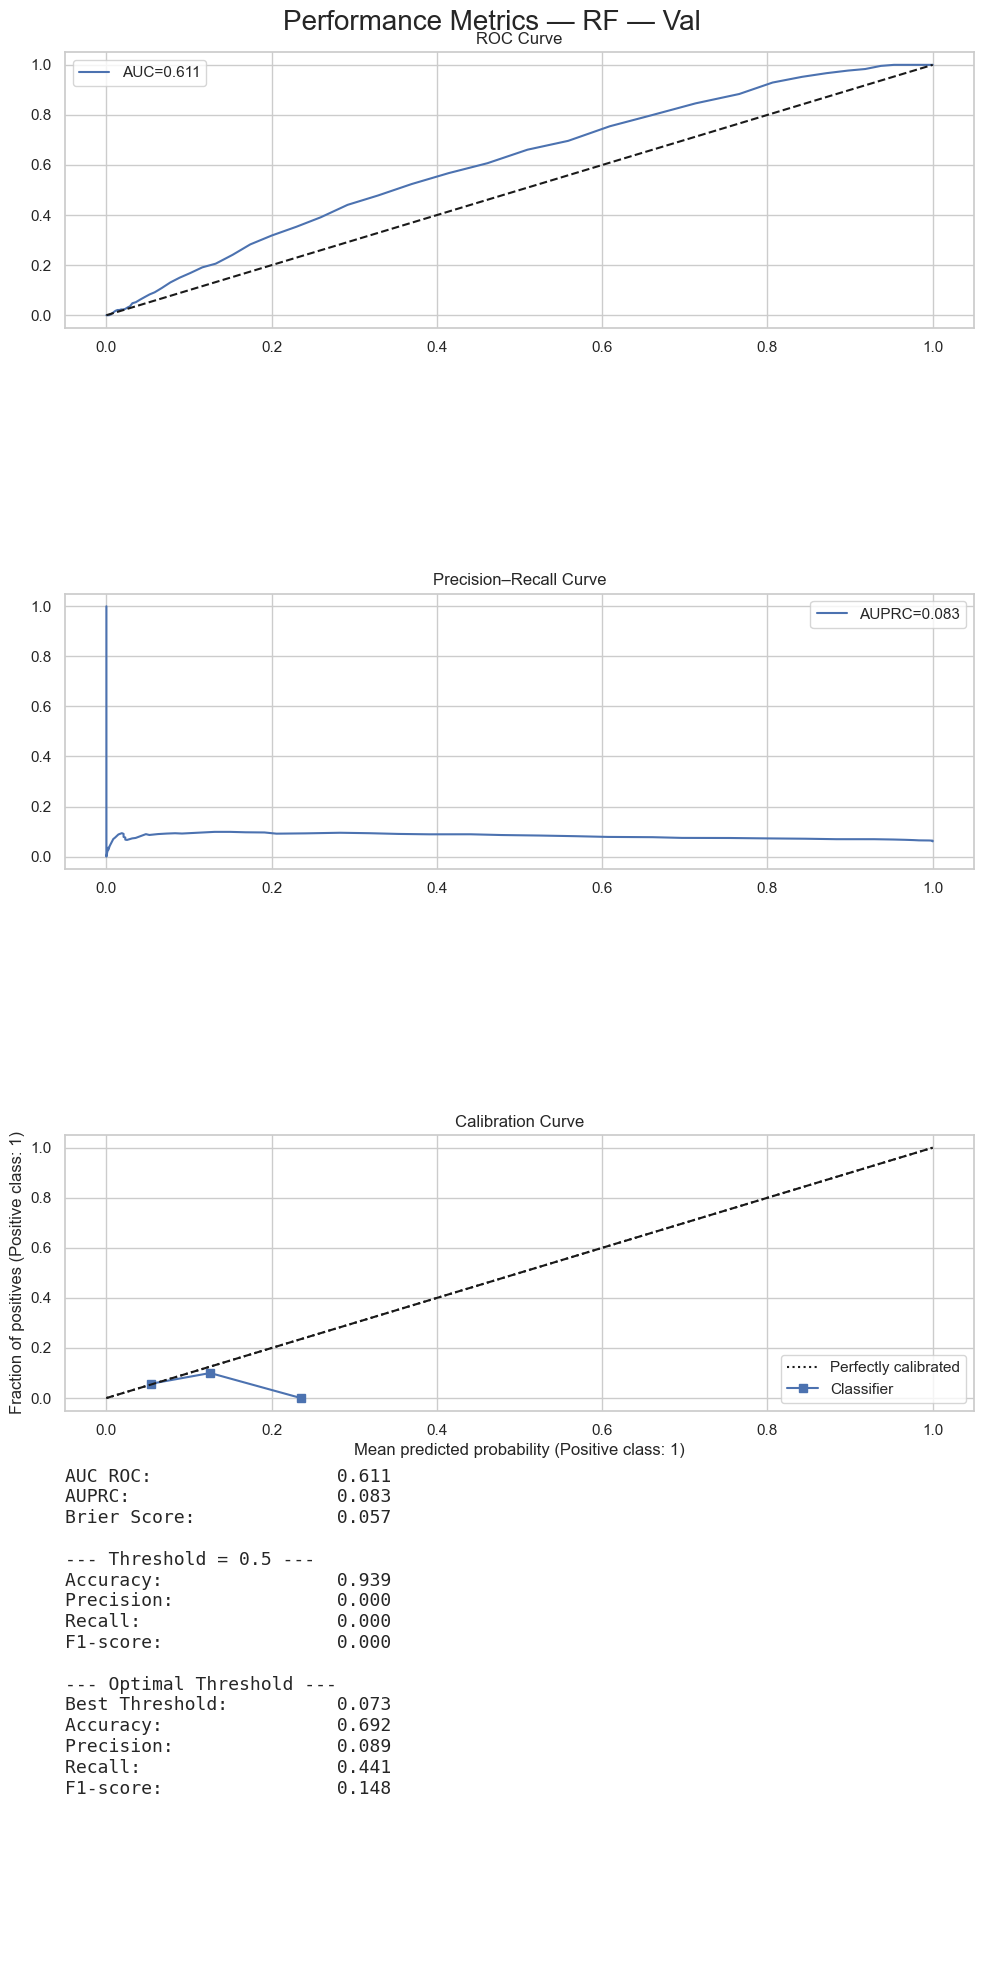

In [77]:
fig_rf_val = plot_model_metrics(model_RF, X_val, y_val, model_name="RF — Val")

In [78]:
rf_grid = {
    "n_estimators": [200, 300, 500],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
    "class_weight": ["balanced"]
}

from sklearn.ensemble import RandomForestClassifier

In [80]:
results_rf, best_rf_model, best_rf_params = cross_val_evaluation(
    model_class=RandomForestClassifier,
    X=X_train,
    y=y_train,
    param_grid=rf_grid,
    scoring="f1",
    n_repeats=10,
    n_folds=5
)


Repeat 1/10

--- Fold 1/5 ---

Best RandomForestClassifier Model
Best scoring metric (f1): 0.1586

Best hyperparameters:
  n_estimators: 300
  min_samples_split: 2
  min_samples_leaf: 4
  max_features: sqrt
  max_depth: 5
  class_weight: balanced

--- Fold 2/5 ---

Best RandomForestClassifier Model
Best scoring metric (f1): 0.1559

Best hyperparameters:
  n_estimators: 300
  min_samples_split: 2
  min_samples_leaf: 4
  max_features: sqrt
  max_depth: 5
  class_weight: balanced

--- Fold 3/5 ---

Best RandomForestClassifier Model
Best scoring metric (f1): 0.1570

Best hyperparameters:
  n_estimators: 300
  min_samples_split: 2
  min_samples_leaf: 4
  max_features: sqrt
  max_depth: 5
  class_weight: balanced

--- Fold 4/5 ---

Best RandomForestClassifier Model
Best scoring metric (f1): 0.1540

Best hyperparameters:
  n_estimators: 300
  min_samples_split: 2
  min_samples_leaf: 4
  max_features: sqrt
  max_depth: 5
  class_weight: balanced

--- Fold 5/5 ---

Best RandomForestClassifier 

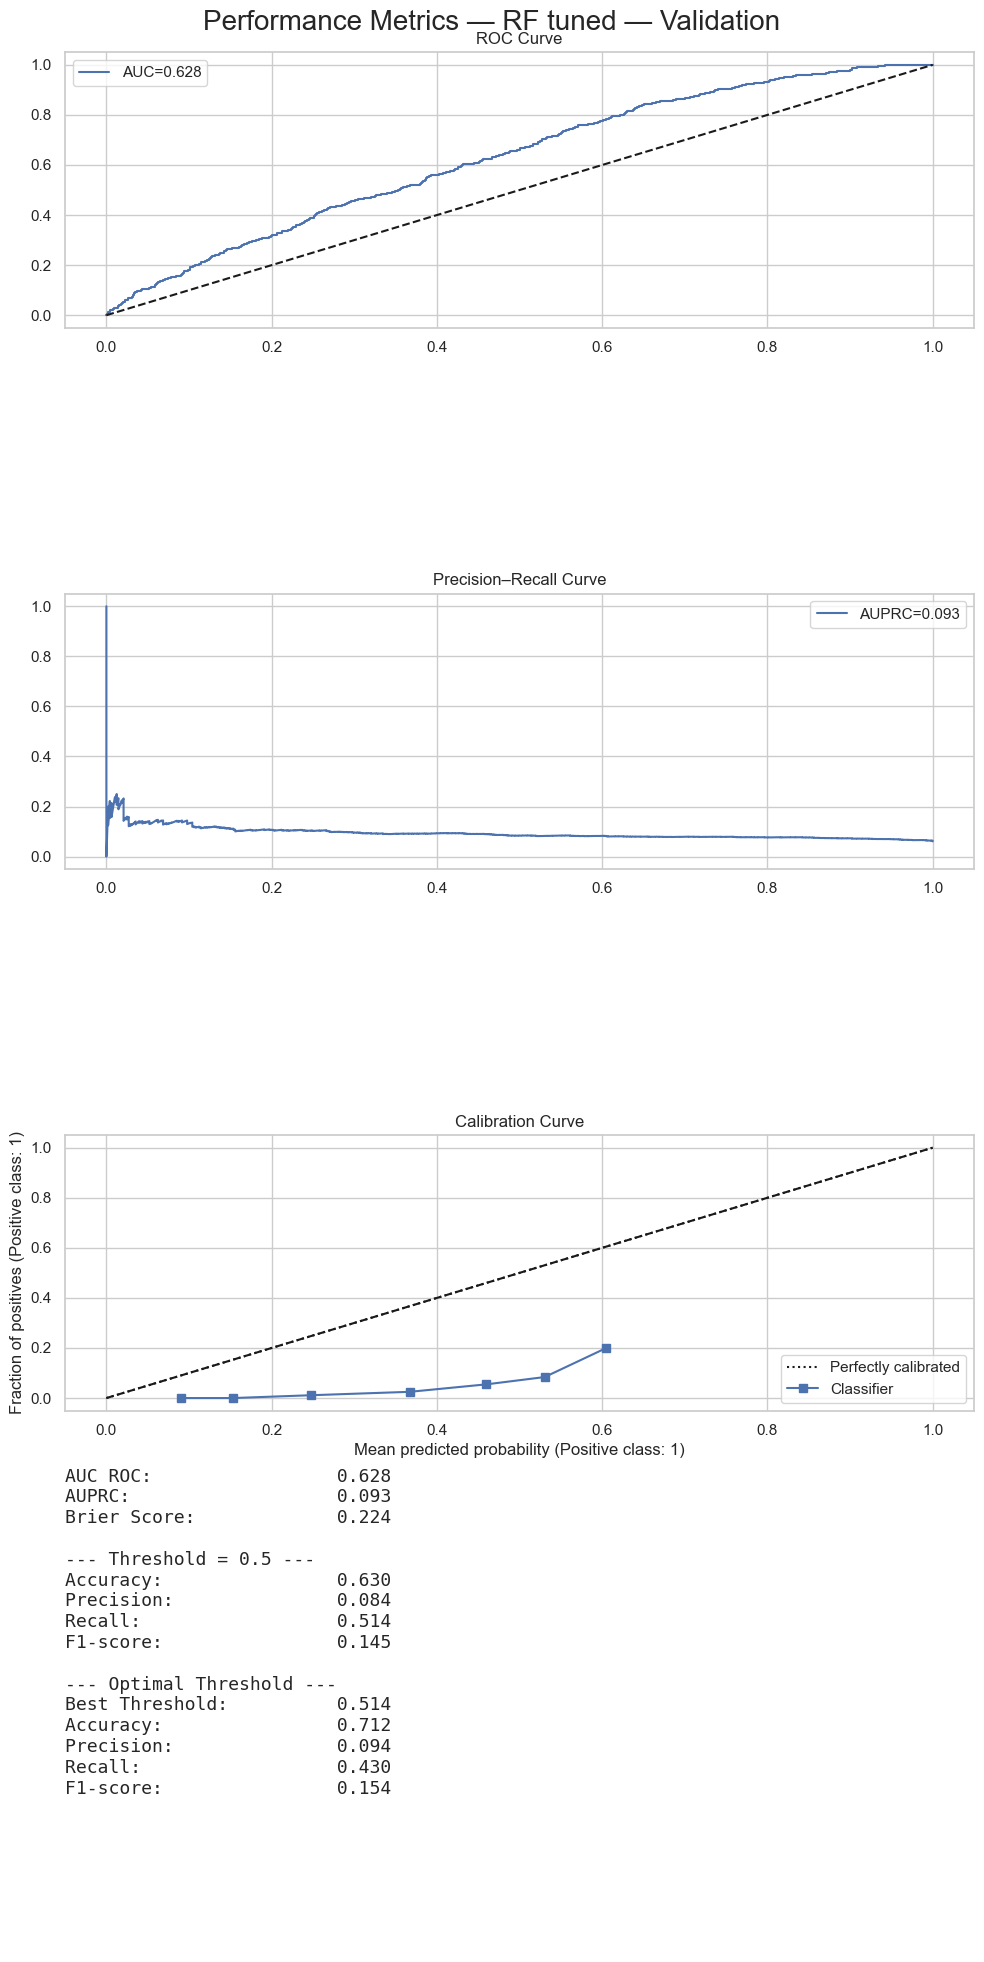

In [82]:
fig_rf_val_tuned = plot_model_metrics(best_rf_model, X_val, y_val, model_name="RF tuned — Validation")


[Statistical FS] Method=mutual_info, k=10
  → Selected features (10): ['vent_last48', 'antibiotics_last72', 'map_missing', 'gcs_missing', 'pfratio_missing', 'bilirubin_lab_missing', 'delta_bilirubin_missing', 'delta_map_missing', 'delta_fio2_missing', 'insurance_Medicare']

[Statistical FS] Method=chi2, k=10
  → Selected features (10): ['spo2', 'map', 'gcs', 'pao2', 'pfratio', 'bun_lab', 'pao2_lab', 'delta_hr', 'delta_map', 'delta_spo2']

[SFS] Direction=forward, k=10
  → Selected features (10): ['sedatives_last72', 'charlson_index', 'temp_missing', 'gcs_missing', 'delta_pao2_missing', 'race_ASIAN - ASIAN INDIAN', 'race_BLACK/AFRICAN AMERICAN', 'race_HISPANIC/LATINO - GUATEMALAN', 'race_PATIENT DECLINED TO ANSWER', 'race_WHITE - BRAZILIAN']


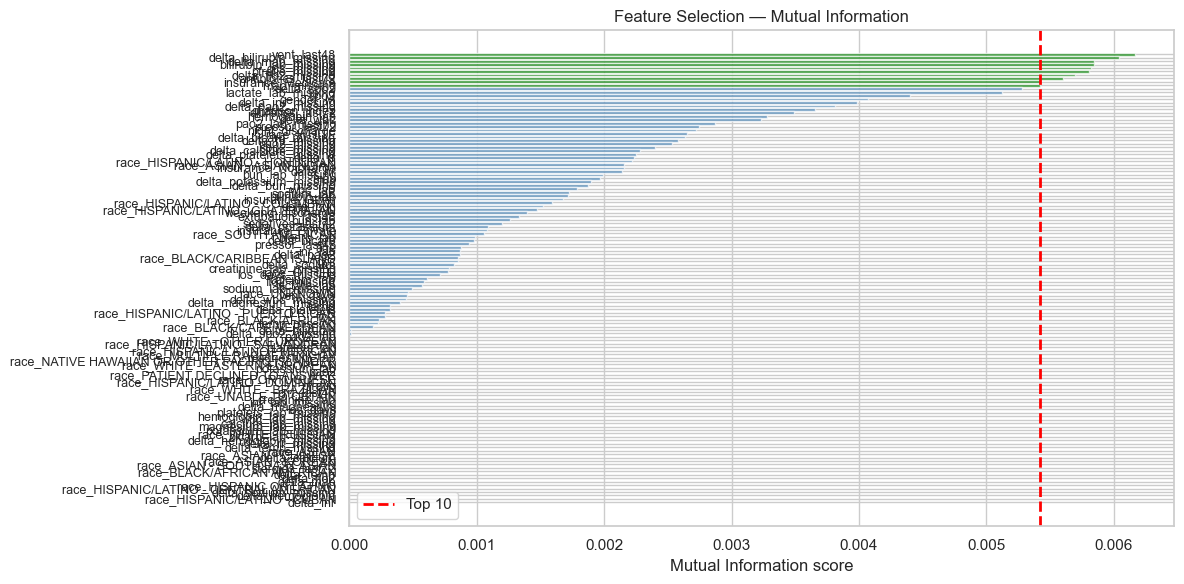

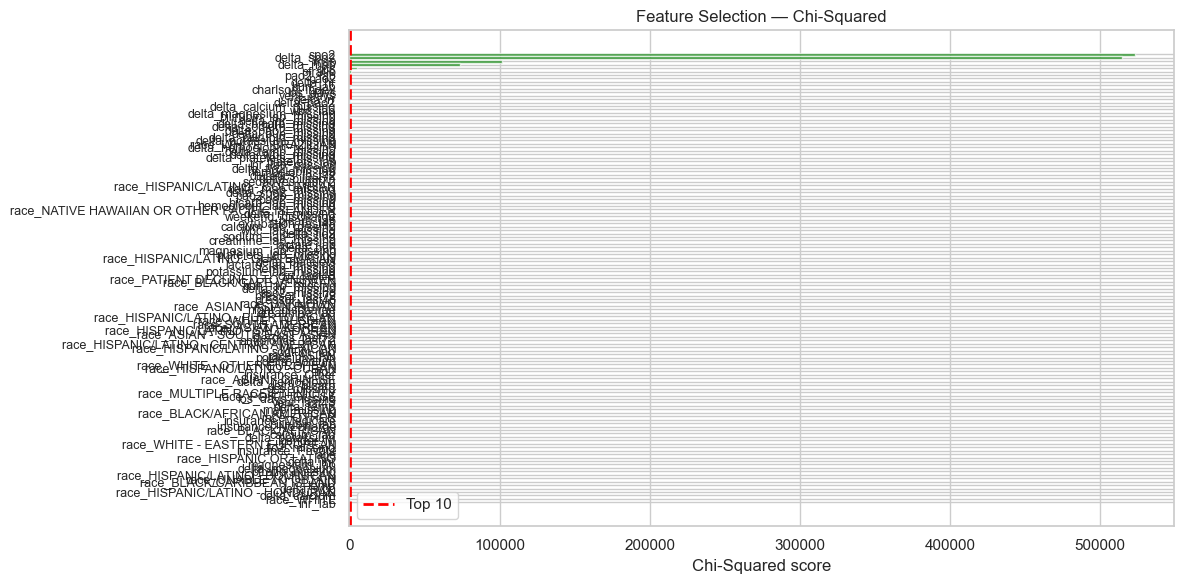

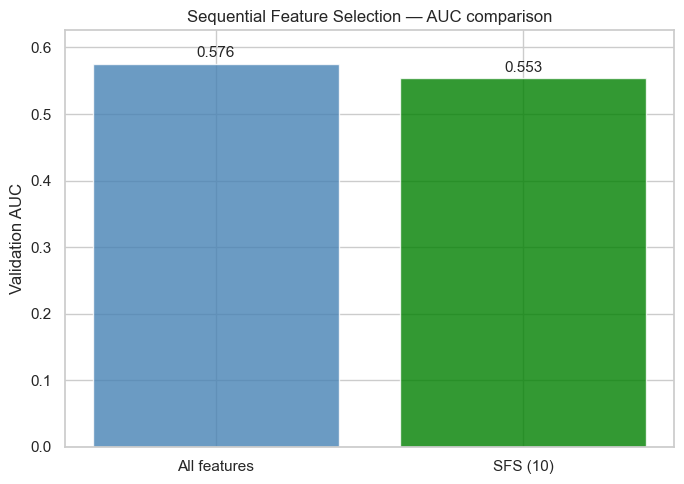

In [83]:
leaderboard_rf, fs_rf, small_rf = run_feature_selection(
    X_train, y_train,
    X_val, y_val,
    tuned_model=best_rf_model,   # your tuned random forest
    n_features=10
)

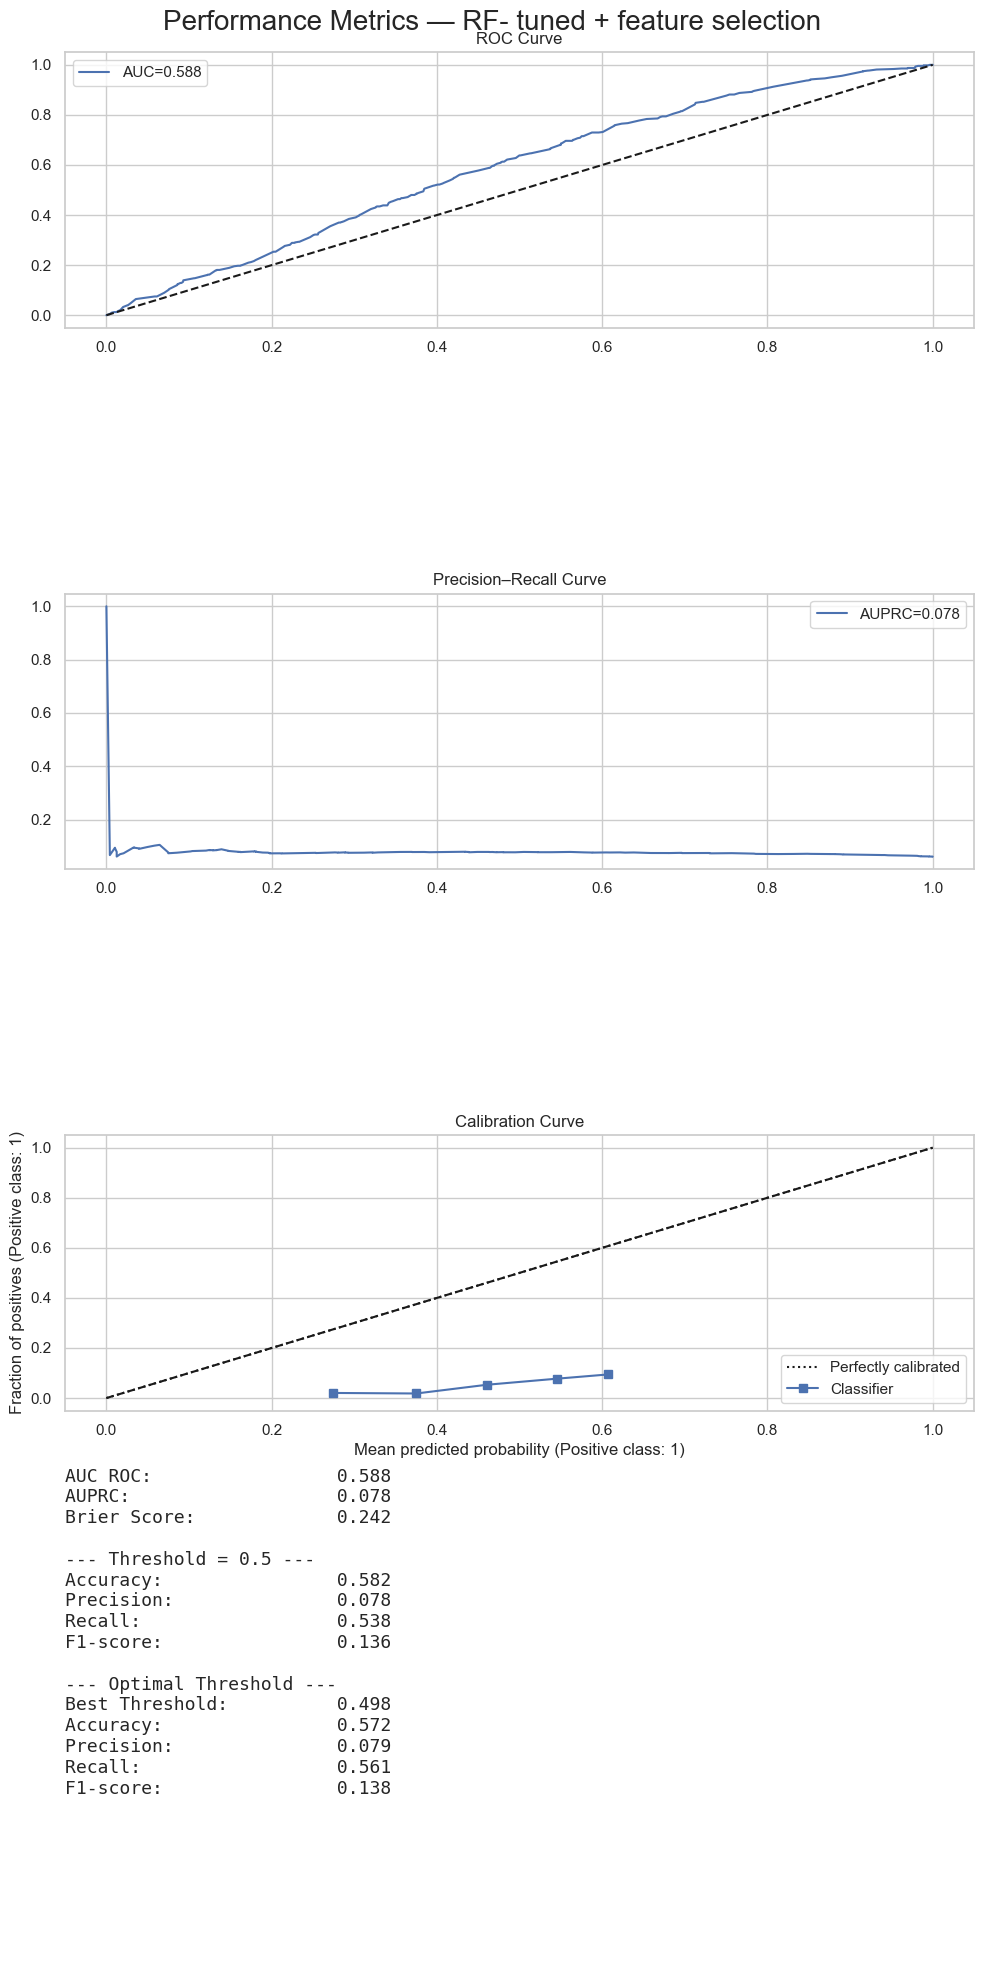

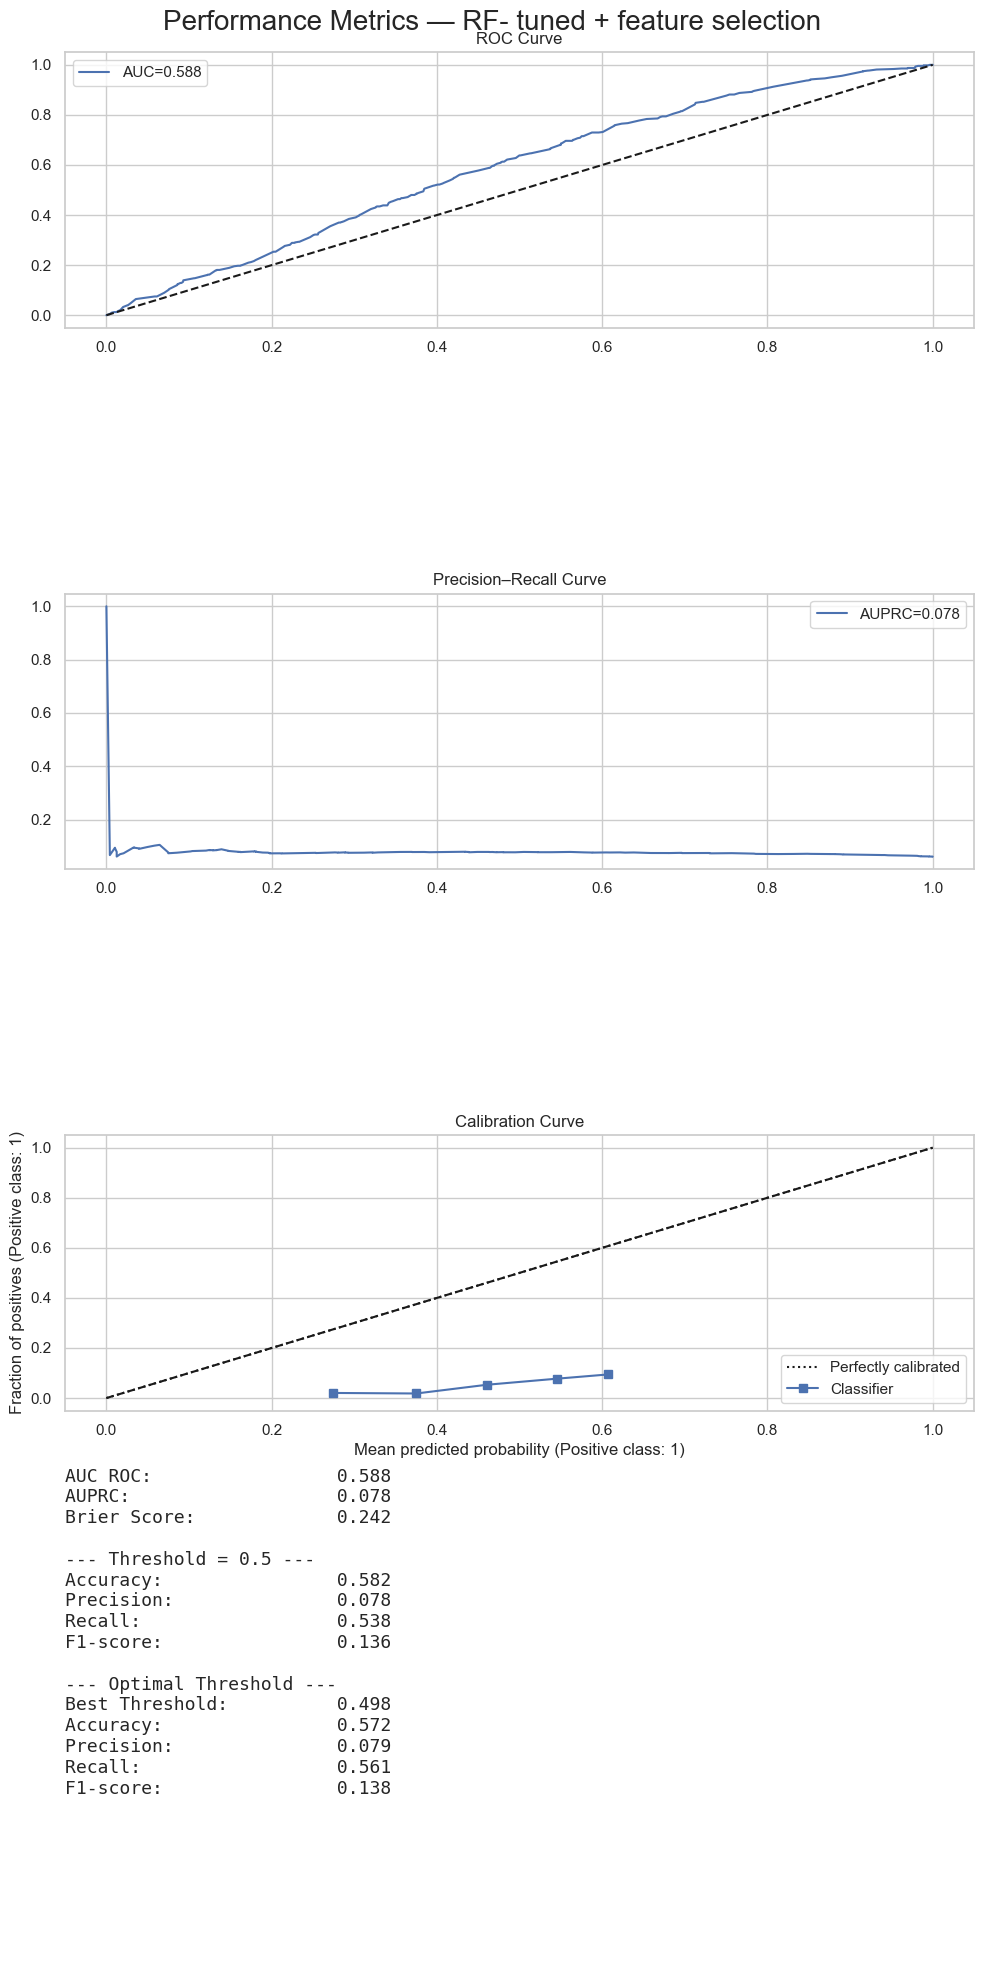

In [84]:
best_feats_rf = leaderboard_rf.iloc[0]["features"]
plot_model_metrics(small_rf, X_val[best_feats_rf], y_val, model_name="RF- tuned + feature selection")

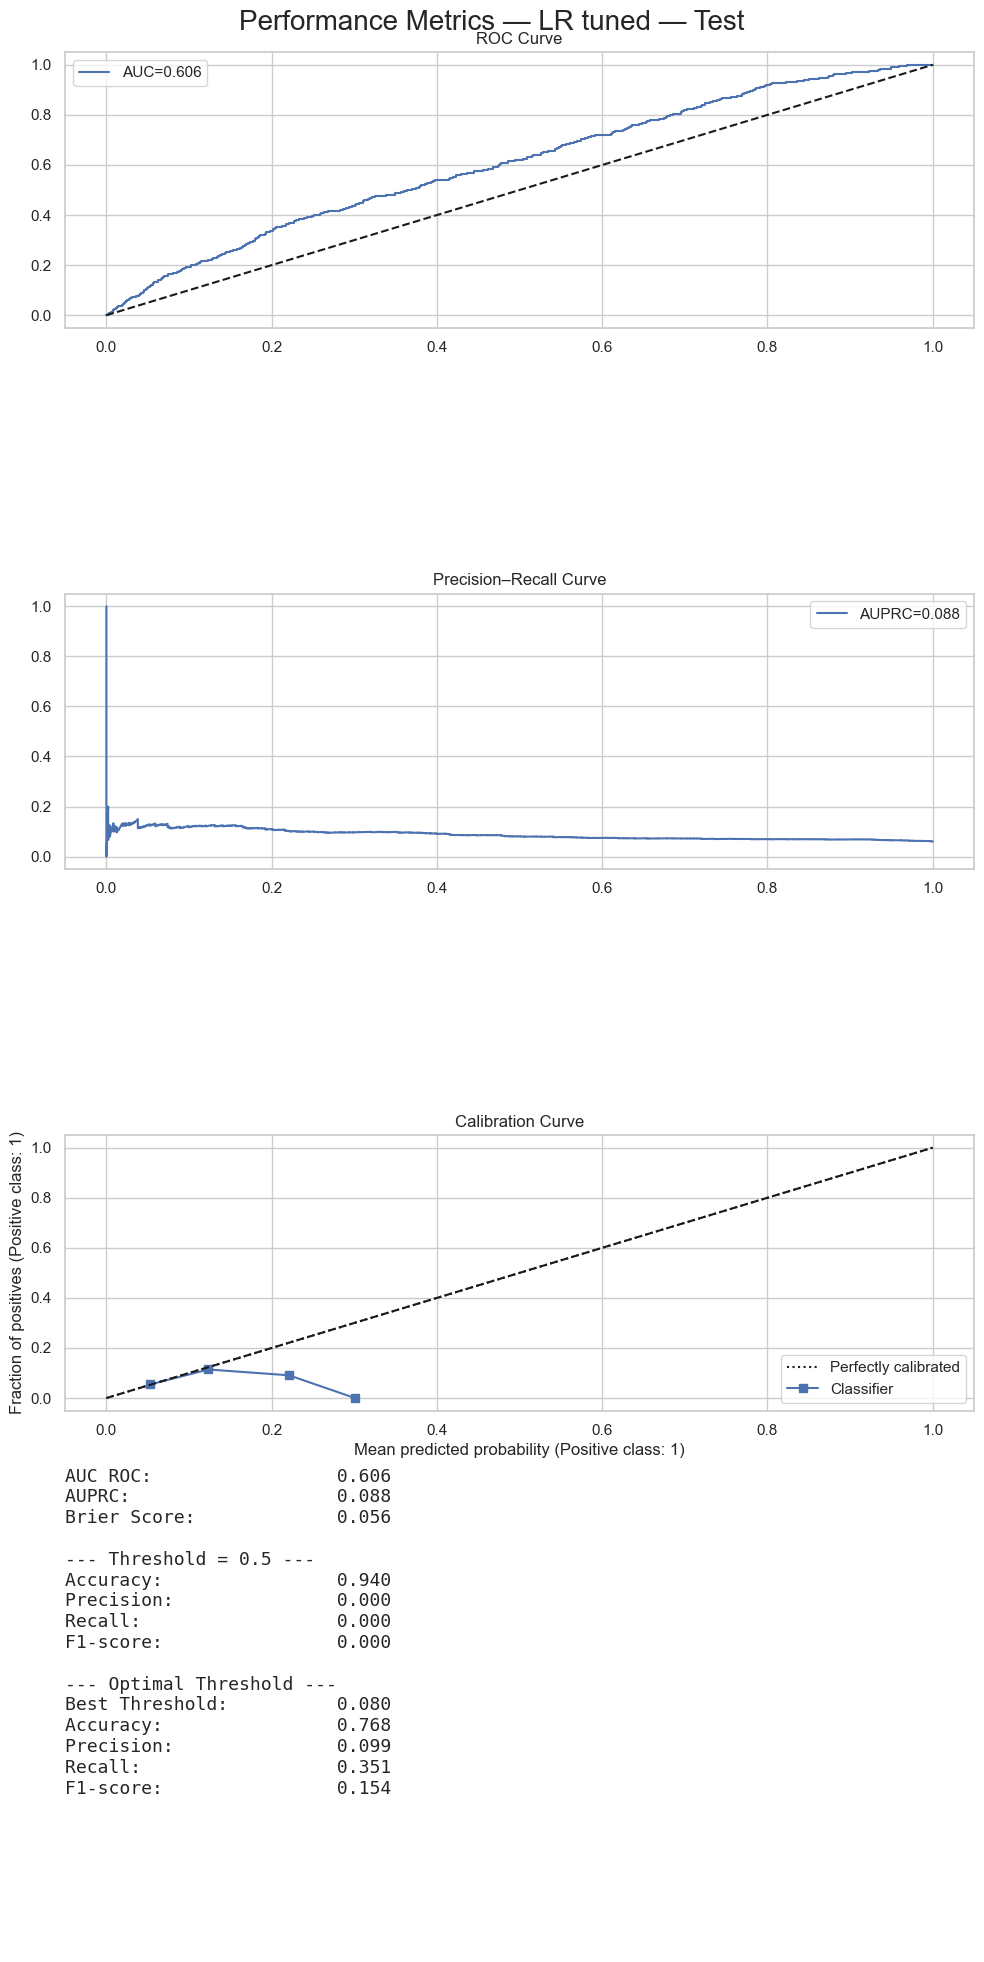

In [92]:
fig_lr_test = plot_model_metrics(model_LR, X_test, y_test, model_name="LR tuned — Test")

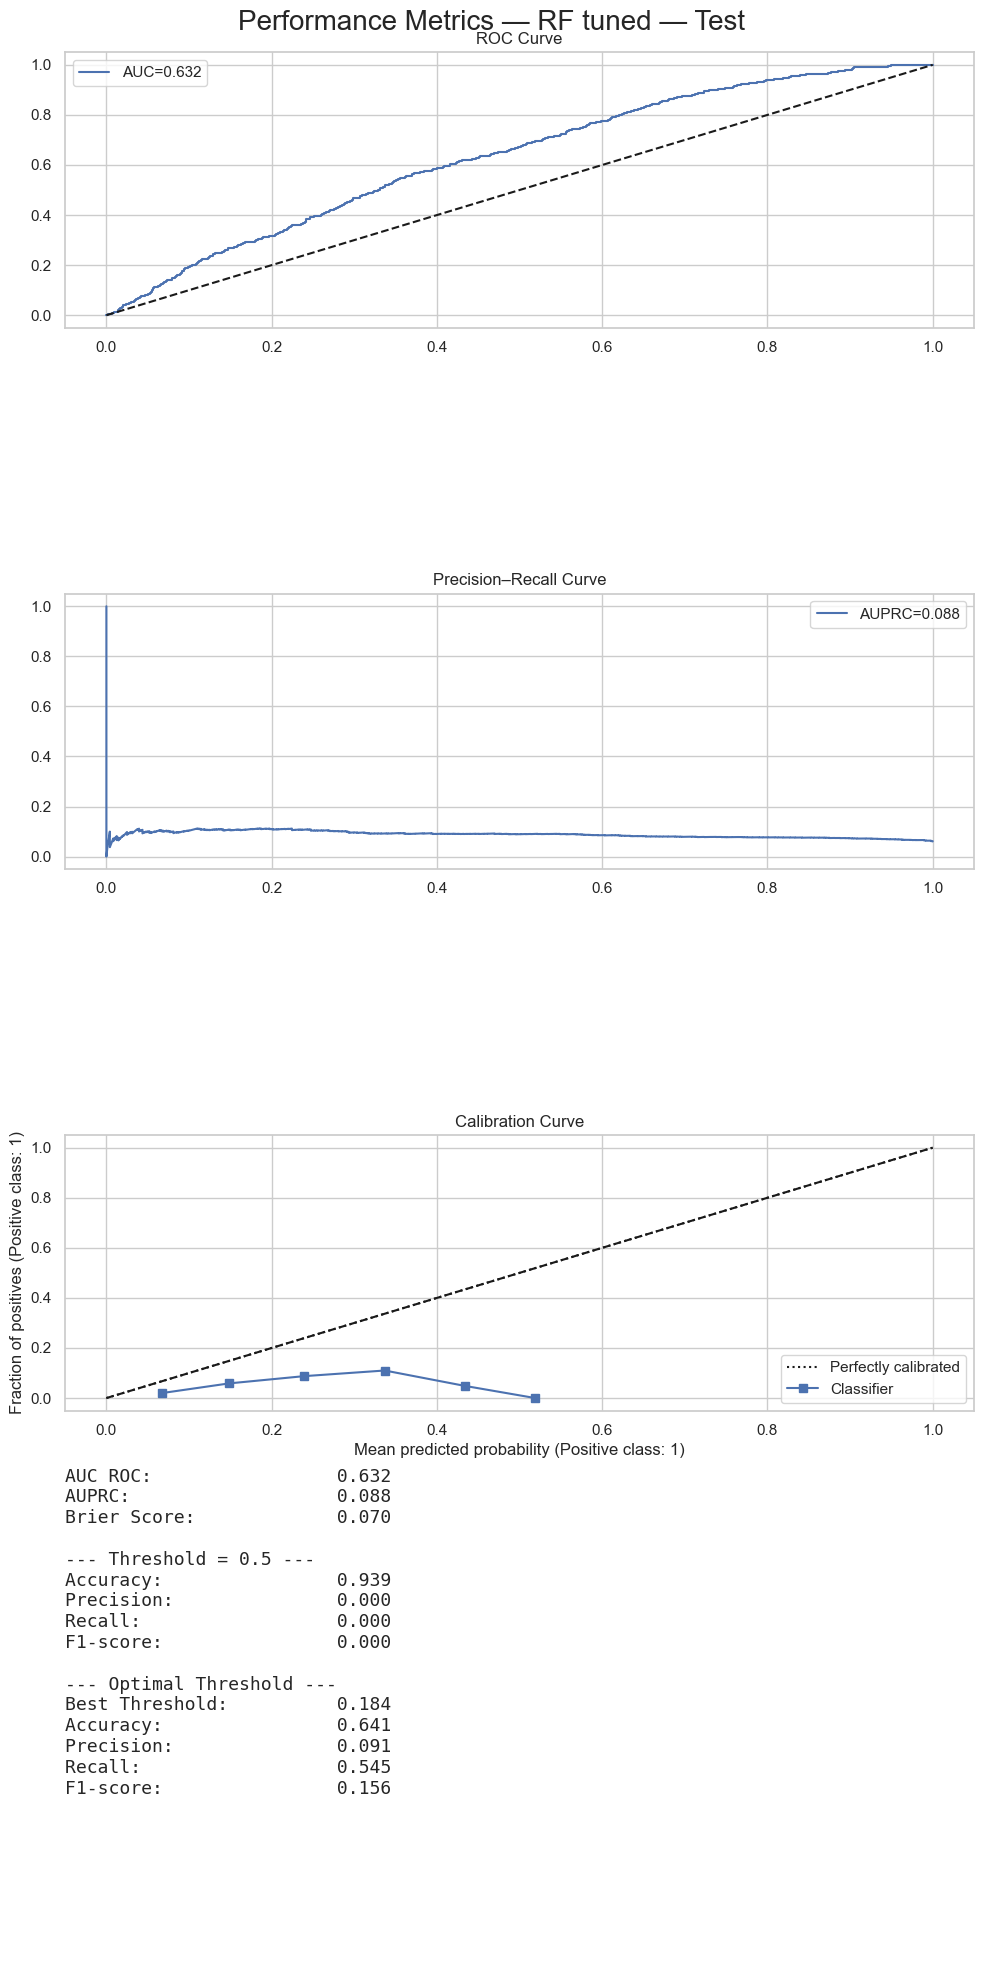

In [ ]:
fig_rf_test = plot_model_metrics(best_rf_model, X_val, y_val, model_name="RF tuned — Test")